This script explores the effect of temperature threshold exceedances on global GDP.

Key research questions we look at are 
 - What is a good model for relating GDP to metrics describing GMT? 
 - What is the marginial effect of cumulative exceedane depth & global GDP? 
 - What is the marginial effect of cumulative exceedane depth on country-level GDP? 

The goal of this script is to find a suitable model for answering the above questions. 
To this end we explore a variety of different linear models that all use different 
sets of predictive variables and explore different target variables descirbing future GDP. 
We assess/compare the models based on their BIC and discard any models that lead to insignificant
predictor variables.  

In [76]:
import sys
sys.path.append('/Users/schoens/Documents/Projekte/Econ/Code/v3/')

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pathlib import Path
import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm


## Step 1: Data Preparation

In [77]:
gdp_df   = pd.read_csv(Path.joinpath(cset.path_GDP, 'Full Data BHM Main Result.csv')).loc[:, ['iso', 'scen', 'run', 'year', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
# compute mean impact at 1.5°C: 
gdp_refline = gdp_df[(gdp_df.scen == 'Ref') & (gdp_df.year == 2100)].loc[:, ['iso','year','SSP2_clim']].groupby(['iso']).mean().reset_index()
gdp_refline = gdp_refline.rename(columns={'SSP2_clim': 'SSP2_refline'})
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df s
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
gdp_new_df = gdp_df.merge(gdp_refline[['iso', 'SSP2_refline']], on='iso')
gdp_new_df['diff_SSP2'] = gdp_new_df['SSP2_clim']/gdp_new_df['SSP2_refline']


KeyboardInterrupt: 

In [60]:
# loading & preparing tas_baseline data
tas_df = pd.read_csv(Path.joinpath(cset.path_GDP, '2310_countrylevel_total.csv'))
tas_df = tas_df[tas_df.year == 2015].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Ref_1p5'), 'scen_run'] = tas_df['scen_run'].str.replace('Ref_1p5', 'Ref')

# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, 'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_new_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_eoc_rel'] = regression_df['gmt_eoc'] - regression_df['gmt_soc']
regression_df['gmt_max_rel'] = regression_df['gmt_max'] - regression_df['gmt_soc']
regression_df['gmt_os']      = regression_df['gmt_max'] - regression_df['gmt_eoc']

In [104]:
# loading & preparing gdp data
gdp_df   = pd.read_csv(Path.joinpath(cset.path_GDP, 'Full Data BHM Main Result.csv')).loc[:, ['iso', 'scen', 'run', 'year', 'SSP2']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_baseline = gdp_df[gdp_df.year == 2015]['SSP2'].values
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df s
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

# loading & preparing tas_baseline data
tas_df = pd.read_csv(Path.joinpath(cset.path_GDP, '2310_countrylevel_total.csv'))
tas_df = tas_df[tas_df.year == 2015].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Ref_1p5'), 'scen_run'] = tas_df['scen_run'].str.replace('Ref_1p5', 'Ref')

# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, 'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_eoc_rel'] = regression_df['gmt_eoc'] - regression_df['gmt_soc']
regression_df['gmt_max_rel'] = regression_df['gmt_max'] - regression_df['gmt_soc']
regression_df['gmt_os']      = regression_df['gmt_max'] - regression_df['gmt_eoc']
# clear up storage
# del gdp_df, glmt_char_df, tas_df

In [349]:
# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, 'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_os']      = regression_df['gmt_max'] - regression_df['gmt_eoc']
regression_df['gmt_eoc_rel'] = regression_df['gmt_eoc'] - regression_df['gmt_soc']
regression_df['gmt_max_rel'] = regression_df['gmt_max'] - regression_df['gmt_soc']
regression_df['gmt_os']      = regression_df['gmt_max'] - regression_df['gmt_eoc']
regression_df['gmt_exc_lb'] = regression_df['gmt_frac_os']*1.5+((1-regression_df['gmt_frac_os'])*1.5-regression_df['gmt_uxc'])

## Step 2: Predictor importance

#### a. Basic understanding of feature importance in each country individually

In [61]:
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'model_id', 'gmt_frac_os'])
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names = poly.get_feature_names_out(predictors)
predictor_df       = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


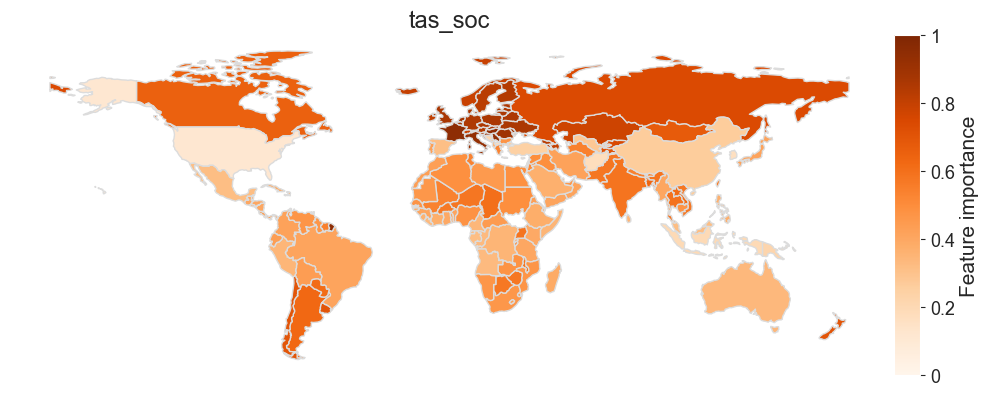

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


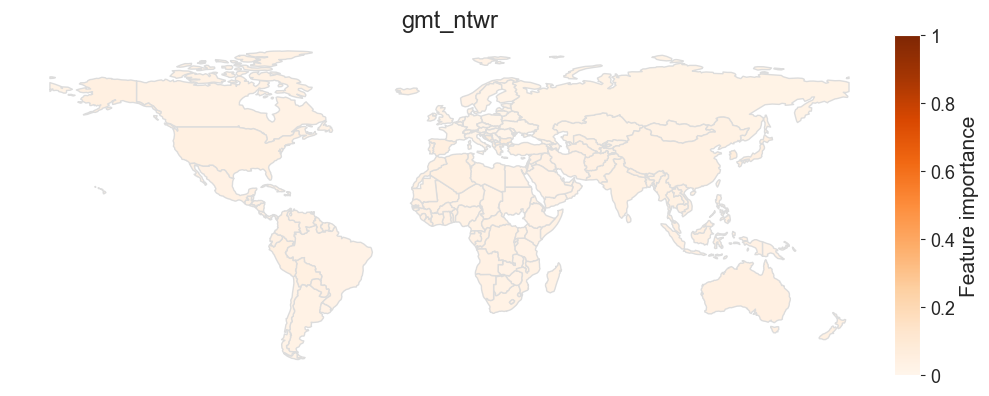

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


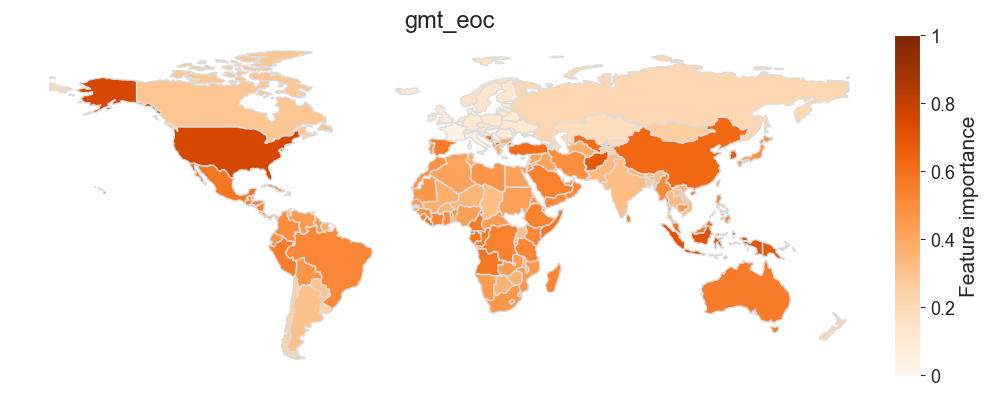

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


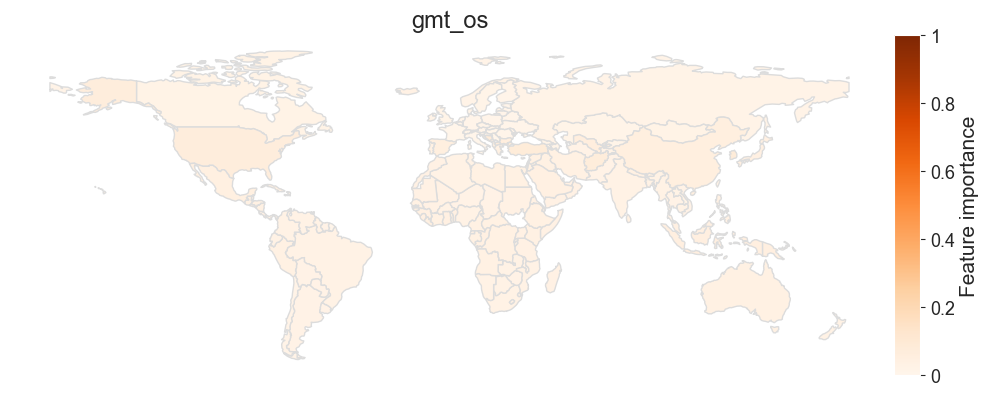

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


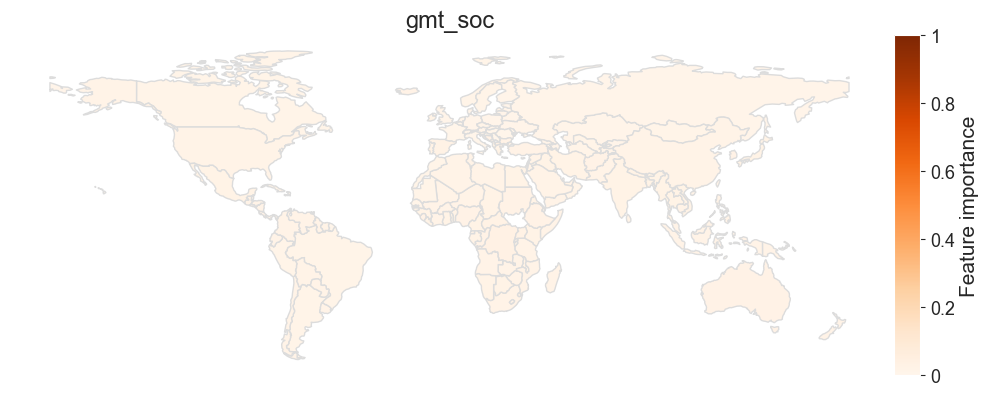

In [286]:
sel_predictors = ['tas_soc', 'gmt_ntwr', 'gmt_eoc', 'gmt_os', 'gmt_soc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


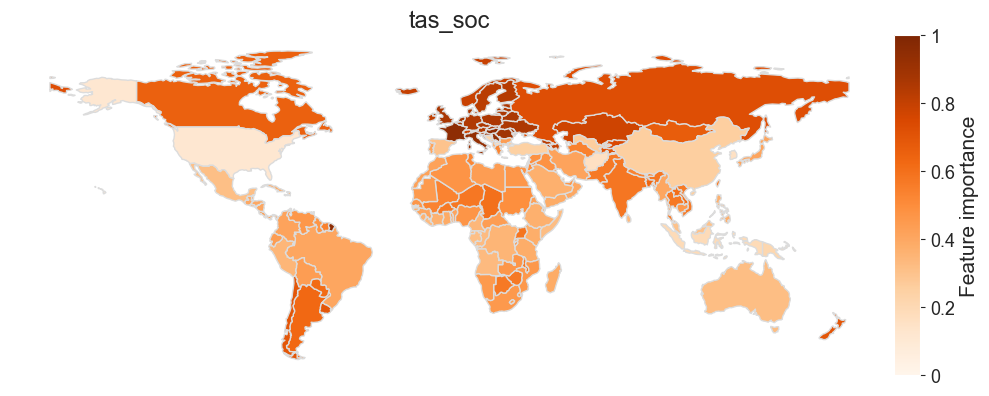

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


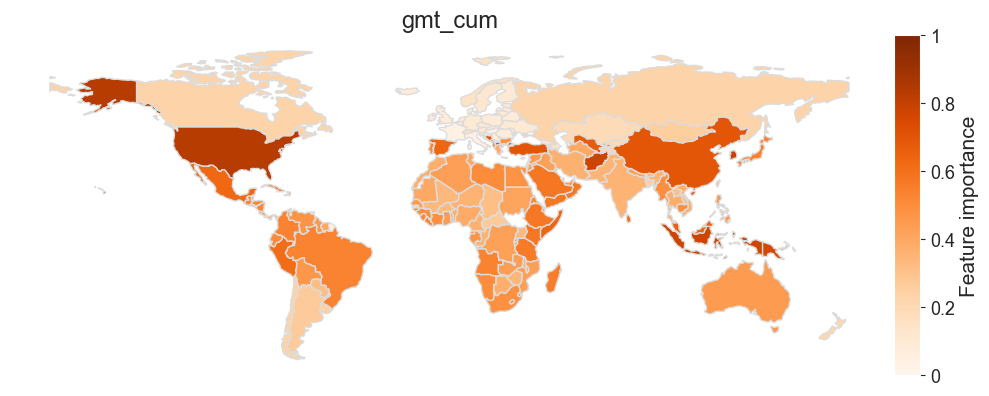

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


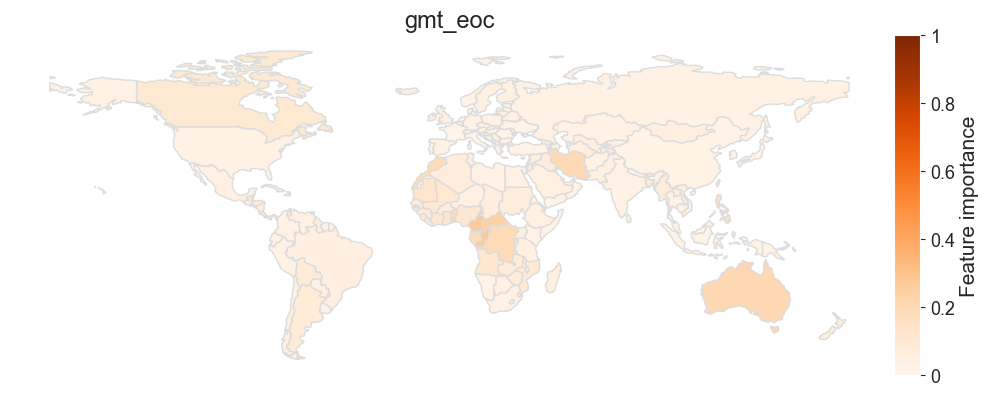

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


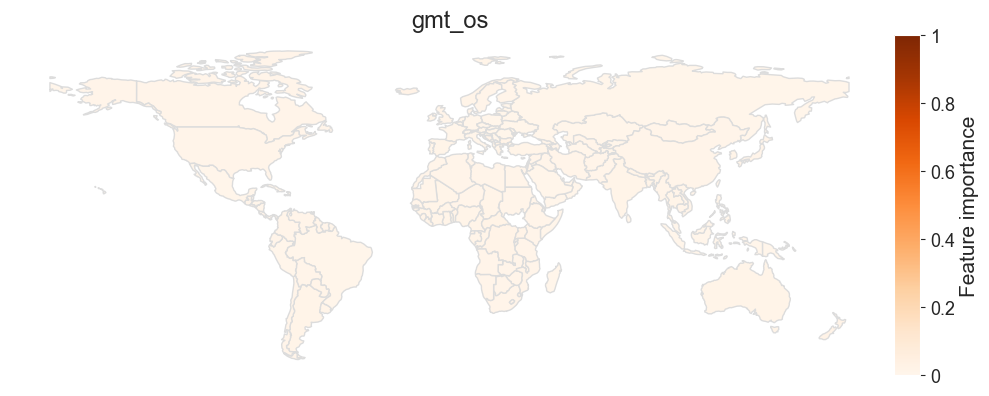

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


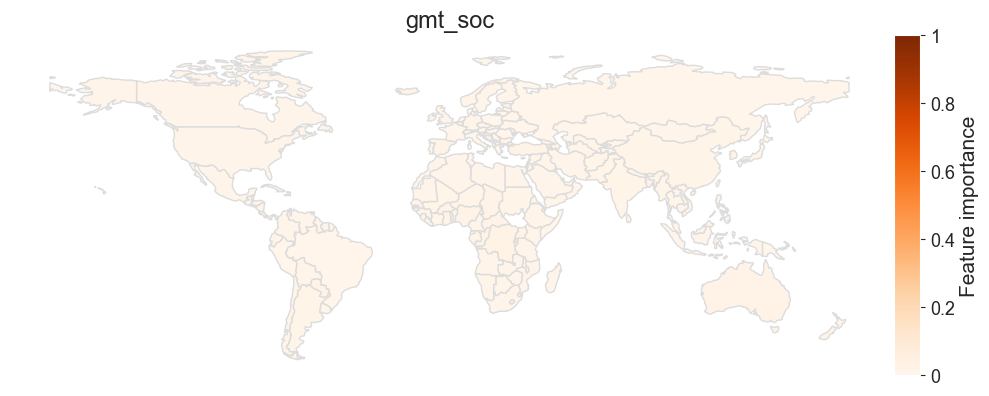

In [287]:
sel_predictors = ['tas_soc', 'gmt_cum', 'gmt_eoc', 'gmt_os', 'gmt_soc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


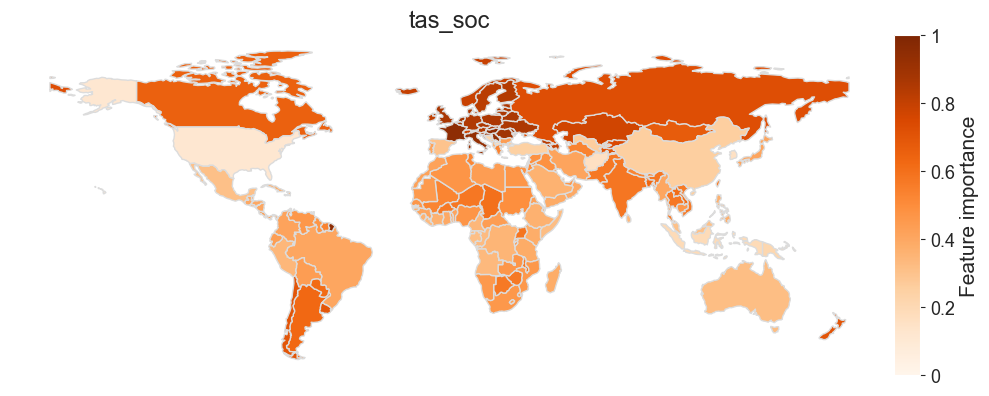

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


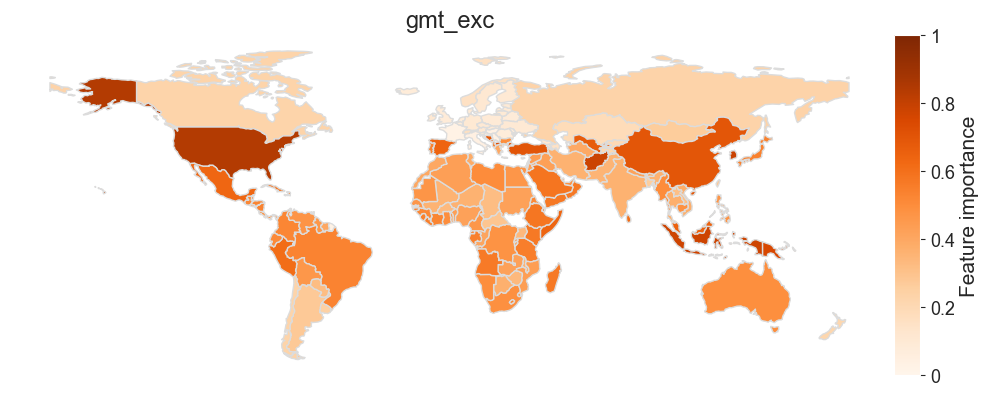

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


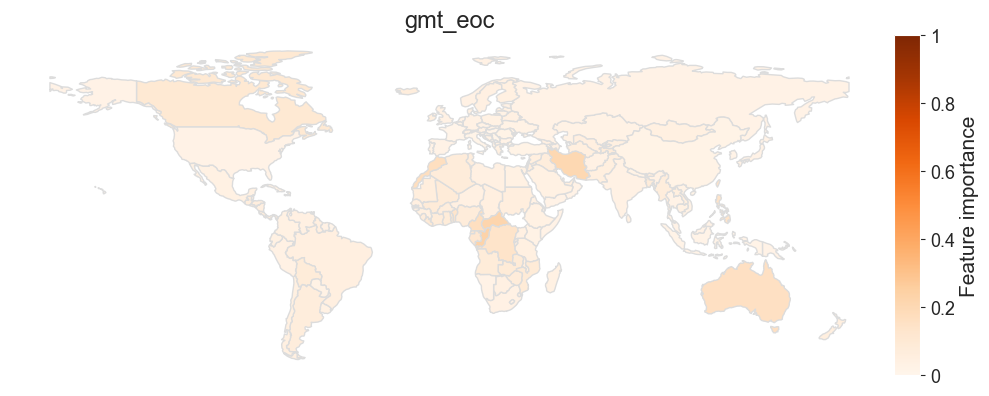

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


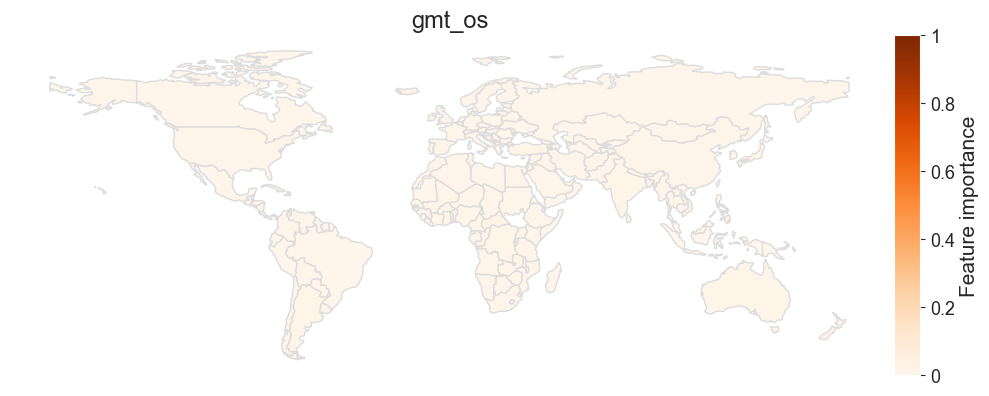

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


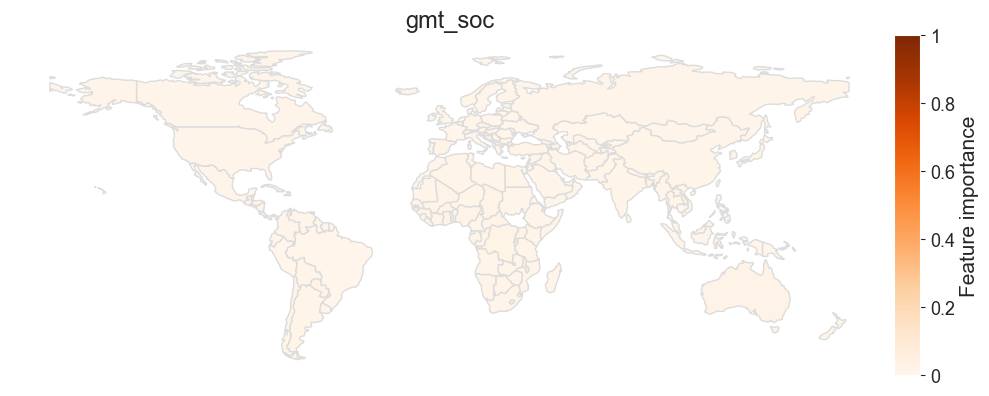

In [288]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_eoc', 'gmt_os', 'gmt_soc']

countries      = regression_df['iso'].unique()
n_countries    = len(countries)

importance_df  = pd.DataFrame(index = sel_predictors, columns = countries) 

for iso in tqdm(countries):
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso].copy()
    country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:]
    y_train       = y_country[country_data.run < 70]
    X_test        = X_country[country_data.run >= 70,:]
    y_test        = y_country[country_data.run >= 70]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    # print(rf.score(X_train,y_train))
    # print(rf.score(X_test, y_test))
    
    importance_df.loc[:, iso] = rf.feature_importances_

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
for predictor in sel_predictors:
    world.loc[countries, predictor]     = importance_df.loc[predictor,countries].values

    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['Oranges'].copy()
        world.plot(column=predictor, ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = 0, vmax = 1, edgecolor = 'gainsboro')
        ax.set_axis_off()
        cax.set_ylabel(f'Feature importance', fontsize = labelsize_medium)
        cax.set_yticks([0,0.2,0.4,0.6,0.8,1])
        cax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = labelsize_small)
        ax.set_title(predictor, fontsize = labelsize_large)
        plt.tight_layout()
        plt.show()

--> most relevant features: tas_soc, gmt_max_rel, gmt_exc, tas_soc
while gmt_soc, gmt_uxc & gmt_ntwr seem to play negligible role 
in addition, adding higher-order terms (e.g. 2nd order) does not improve predictive accuracy 

#### b. Understanding how parameters change with different baseline temperatures 

In [255]:
predictor_sets = [['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_os', 'gmt_os tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_os', 'gmt_os tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_od', 'gmt_od tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_od', 'gmt_od tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'], 
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline', 'gmt_od',  'gmt_od tas_baseline'],    
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_os', 'gmt_os tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline', 'gmt_os', 'gmt_os tas_baseline']
                  ]

In [62]:
predictor_sets = [['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline'], 
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline']
                  ]

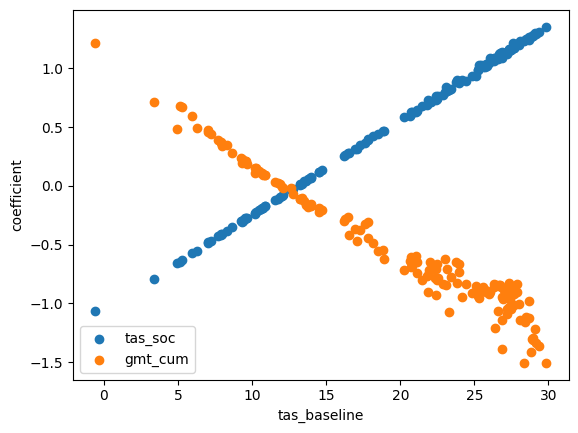

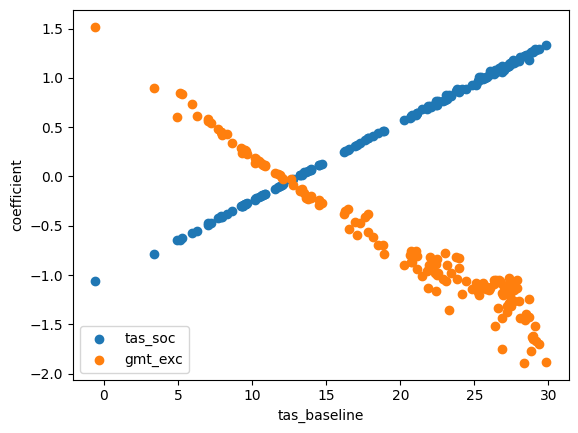

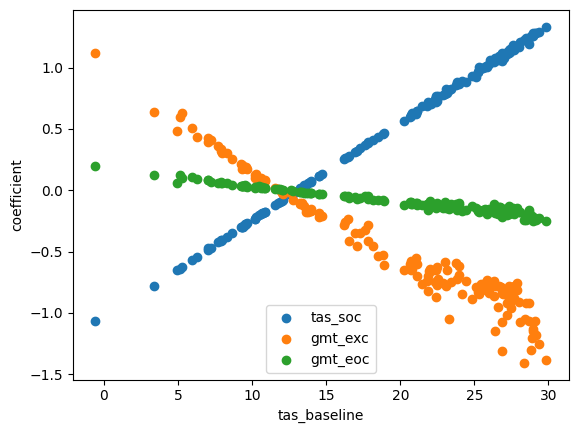

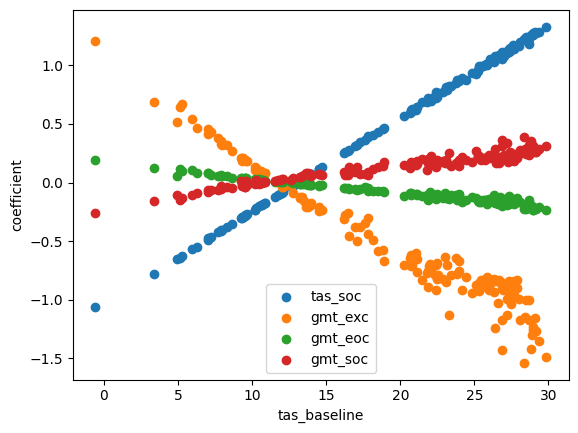

In [64]:
# check for plausibility:
for sel_all_predictors in predictor_sets:
    sel_predictors = [predictor for predictor in sel_all_predictors if 'tas_baseline' not in predictor]
    coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
    tas_baselines    = []
    i_iso = 0 
    for iso in np.unique(regression_df['iso']): 
        # subset data for the country 
        country_data  = regression_df[regression_df['iso'] == iso]
        y_country     = np.log(country_data['diff_SSP2'].values)
        X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
        # X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
        X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
        coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
        tas_baselines.append(np.mean(country_data['tas_baseline']))
        i_iso += 1
    
    plt.figure()
    for i_pred in range(len(sel_predictors)):
        plt.scatter(tas_baselines, coefficients[:, i_pred], label = sel_predictors[i_pred])
        plt.xlabel('tas_baseline')
        plt.ylabel('coefficient')
    plt.legend()
    plt.show()

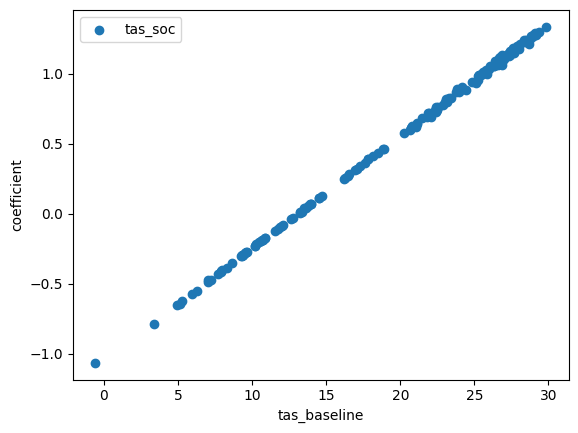

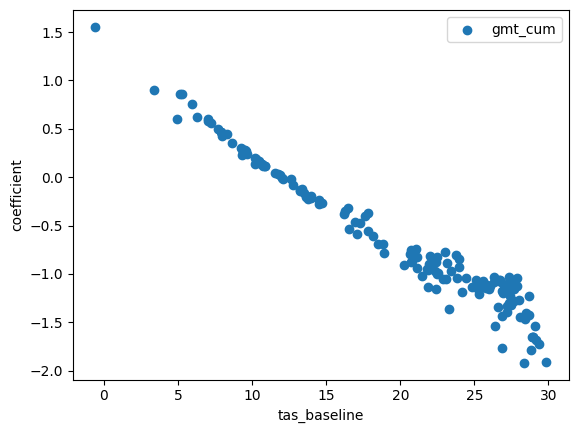

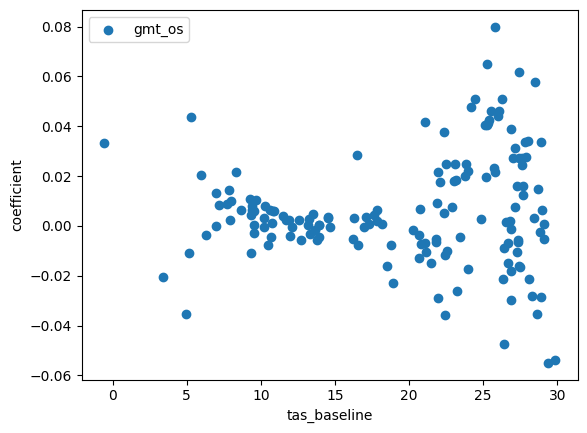

In [313]:
sel_predictors = ['tas_soc', 'gmt_cum', 'gmt_os']
coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
tas_baselines    = []
gdp_baselines    = []
i_iso = 0 
for iso in np.unique(regression_df['iso']): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    # X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
    X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
    coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
    tas_baselines.append(np.mean(country_data['tas_baseline']))
    gdp_baselines.append(np.mean(country_data['GDP_baseline']))
    i_iso += 1
for i_pred in range(len(sel_predictors)):
    plt.figure()
    plt.scatter(tas_baselines, coefficients[:, i_pred], label = sel_predictors[i_pred])
    plt.xlabel('tas_baseline')
    plt.ylabel('coefficient')
    plt.legend()
    plt.show()

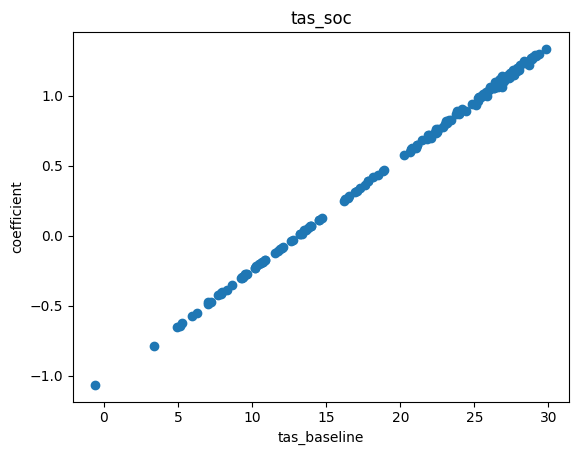

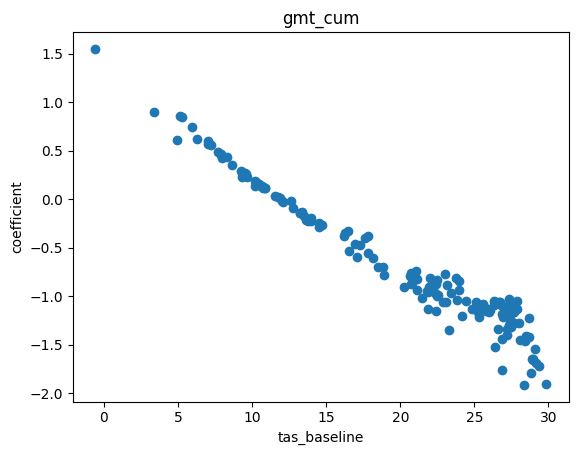

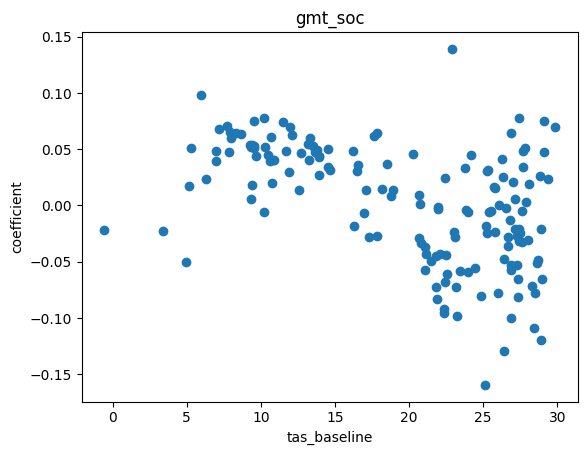

In [229]:
# fit regular linear model with all these parameters and check evolution over tas_baseline
# including gmt_uxc as otherwise 2100 gdp cannot relax when temperatures reverse and when working
# with the 1.5°C threshold 
sel_predictors = ['tas_soc', 'gmt_cum'] # adding more terms introduces physically implausible bheaviour 

coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
tas_baselines    = []
gdp_baselines    = []
i_iso = 0 
for iso in np.unique(regression_df['iso']): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    # X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
    X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
    coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
    tas_baselines.append(np.mean(country_data['tas_baseline']))
    gdp_baselines.append(np.mean(country_data['GDP_baseline']))
    i_iso += 1
    
for i_pred in range(len(sel_predictors)):
    plt.figure()
    plt.scatter(tas_baselines, coefficients[:, i_pred])
    plt.xlabel('tas_baseline')
    plt.ylabel('coefficient')
    plt.title(sel_predictors[i_pred])
    plt.show()

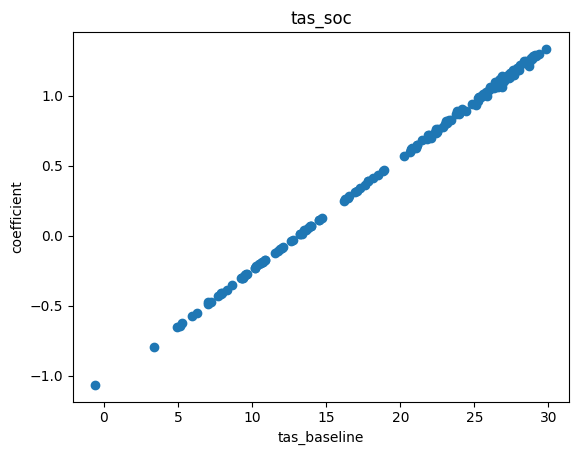

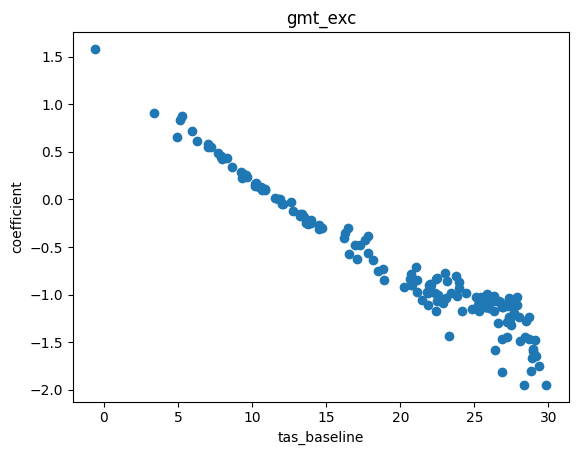

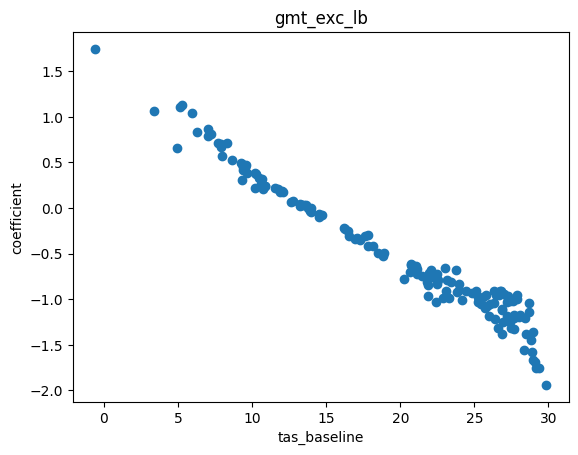

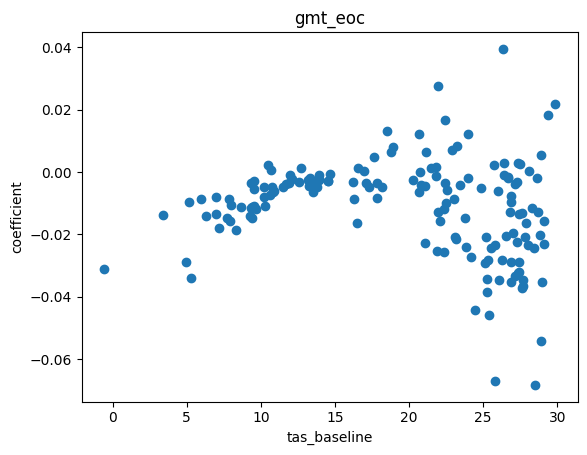

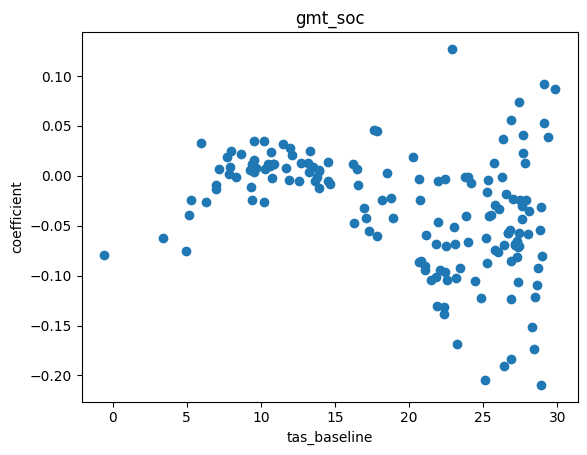

In [217]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_exc_lb', 'gmt_eoc', 'gmt_soc'] 

coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
tas_baselines    = []
gdp_baselines    = []
i_iso = 0 
for iso in np.unique(regression_df['iso']): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    # X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
    X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
    coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
    tas_baselines.append(np.mean(country_data['tas_baseline']))
    gdp_baselines.append(np.mean(country_data['GDP_baseline']))
    i_iso += 1
    
for i_pred in range(len(sel_predictors)):
    plt.figure()
    plt.scatter(tas_baselines, coefficients[:, i_pred])
    plt.xlabel('tas_baseline')
    plt.ylabel('coefficient')
    plt.title(sel_predictors[i_pred])
    plt.show()

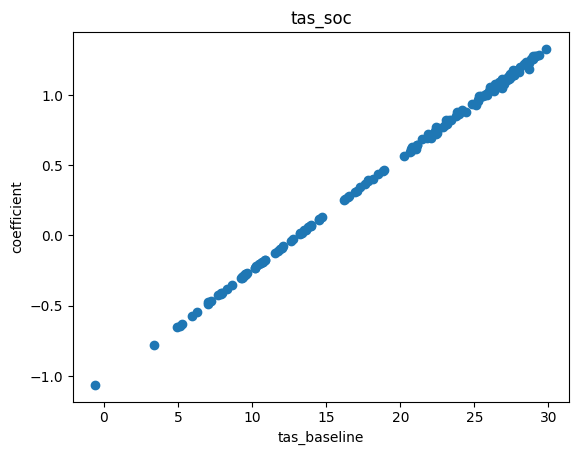

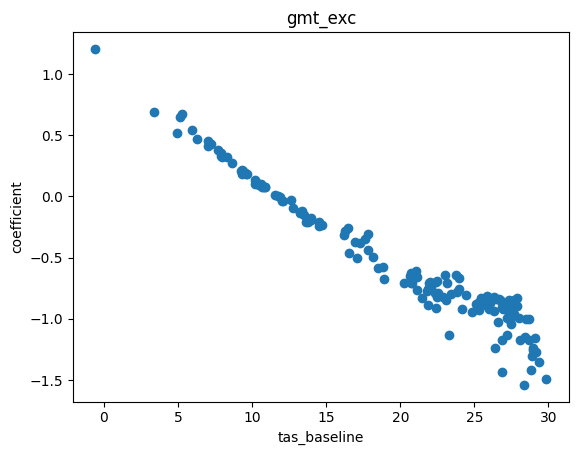

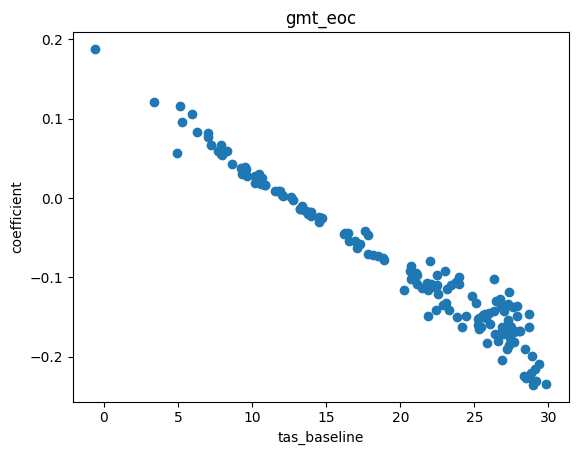

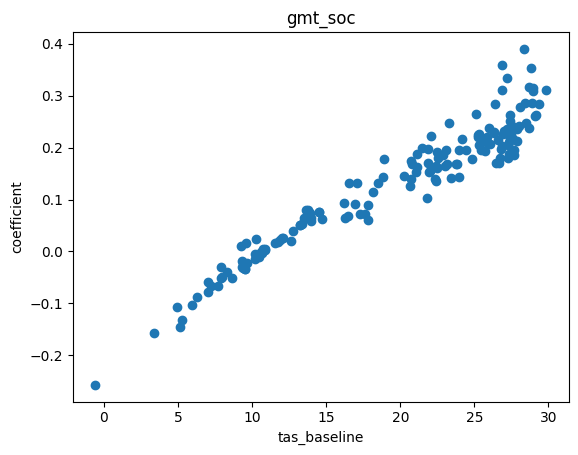

In [331]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_eoc', 'gmt_soc'] 

coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
tas_baselines    = []
gdp_baselines    = []
i_iso = 0 
for iso in np.unique(regression_df['iso']): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    # X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
    X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
    coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
    tas_baselines.append(np.mean(country_data['tas_baseline']))
    gdp_baselines.append(np.mean(country_data['GDP_baseline']))
    i_iso += 1
    
for i_pred in range(len(sel_predictors)):
    plt.figure()
    plt.scatter(tas_baselines, coefficients[:, i_pred])
    plt.xlabel('tas_baseline')
    plt.ylabel('coefficient')
    plt.title(sel_predictors[i_pred])
    plt.show()

--> seems to pre primarily linear; need to include interaction terms between tas_baseline and all predictors in model  

#### c. Constructing different physically plausible models and selecting via BIC + cross-validation

In [257]:
predictor_sets = [['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_os', 'gmt_os tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_os', 'gmt_os tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_od', 'gmt_od tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_od', 'gmt_od tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline', 'gmt_od', 'gmt_od tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline', 'gmt_os', 'gmt_os tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],    
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_os', 'gmt_os tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline', 'gmt_os', 'gmt_os tas_baseline']
                  ]

In [65]:
predictor_sets = [['tas_soc', 'tas_baseline tas_soc', 'gmt_cum', 'gmt_cum tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline'], 
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline'],
                  ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_od', 'gmt_od tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline']
                  ]

In [347]:
# load gmt data: 
gmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
fair_ids_100  = pd.read_csv(cset.path_FAIR / 'ids_reconstructed.csv', sep = ',', index_col = 0).drop(columns = ['Ref']).rename(columns={'Ref_1p5': 'Ref'})
for i_scen in range(cset.n_scenarios): 
    scenario = cset.scenarios[i_scen]
    all_fair_runs = pd.read_csv(cset.path_FAIR / f'scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(cset.path_MESMER_fldmean / f'{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    gmt[i_scen*100:(i_scen+1)*100,:] = all_fair_runs.loc[slice(2015,2100), fair_ids_mesmer].T
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
columns = np.array(columns).flatten()

i_sel_scenarios = [5, 2]
sel_scenarios   = [cset.scenarios[i_sel] for i_sel in i_sel_scenarios]

gmt_ref = np.mean(gmt[500:600, :], axis = 0)
gmt_neg = np.mean(gmt[200:300, :], axis = 0)
gmt_ref[17:] = 1.5

In [ ]:
gmt-1.1455791

In [66]:
country_data = regression_df.copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

for sel_predictors in predictor_sets: 
    X_country_raw = predictor_df.loc[:, sel_predictors].copy()
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.run < 70,:].copy()
    y_train       = y_country[country_data.run < 70].copy()
    X_test        = X_country[country_data.run >= 70,:].copy()
    y_test        = y_country[country_data.run >= 70].copy()
    
    X_intercept_train = X_intercept[country_data.run < 70,:].copy()
    X_intercept_test = X_intercept[country_data.run >= 70,:].copy()

    linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
    print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9064732461600563 Test score:  0.8951512843231981
Train score:  0.9001074327777319 Test score:  0.8932037863446384
Train score:  0.9062822016478305 Test score:  0.8985878180972928
Train score:  0.9071283130665515 Test score:  0.9008252068807026
Train score:  0.9253764296878781 Test score:  0.916974686150491


In [74]:
sel_predictors = ['tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_exc tas_baseline','gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline']

country_data = regression_df.copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

X_country_raw = predictor_df.loc[:, sel_predictors].copy()
X_country     = X_country_raw.values.copy()
X_train       = X_country[country_data.run < 70,:].copy()
y_train       = y_country[country_data.run < 70].copy()
X_test        = X_country[country_data.run >= 70,:].copy()
y_test        = y_country[country_data.run >= 70].copy()

X_intercept_train = X_intercept[country_data.run < 70,:].copy()
X_intercept_test = X_intercept[country_data.run >= 70,:].copy()

linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9132516699448807 Test score:  0.9036141562239395


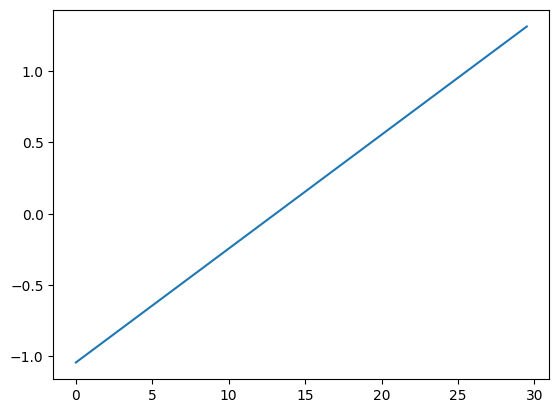

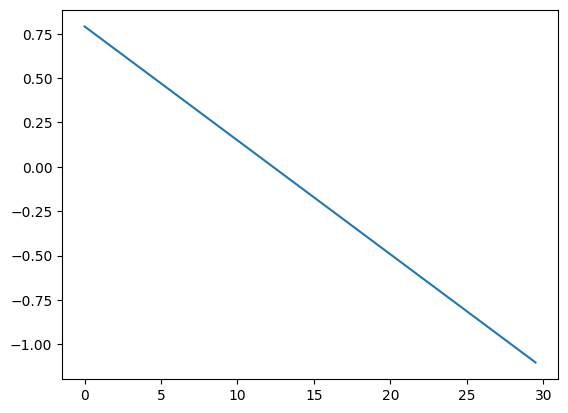

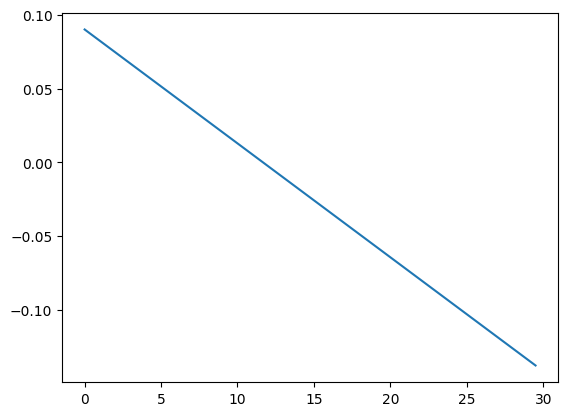

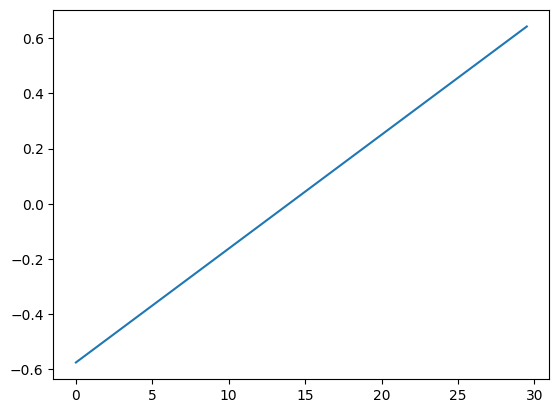

In [75]:
x_Ts = np.arange(0,30,0.5)
coeffs = linreg.coef_[:10]
plt.figure()
plt.plot(x_Ts, coeffs[0] + x_Ts*coeffs[1], label = 'tas_soc')
plt.show()
plt.figure()
plt.plot(x_Ts, coeffs[2] + x_Ts*coeffs[3], label = 'gmt_exc')
plt.show()
plt.figure()
plt.plot(x_Ts, coeffs[4] + x_Ts*coeffs[5], label = 'gmt_eoc')
plt.show()
plt.figure()
plt.plot(x_Ts, coeffs[6] + x_Ts*coeffs[7], label = 'gmt_uxc')
plt.show()
# plt.figure()
# plt.plot(x_Ts, coeffs[8] + x_Ts*coeffs[9], label = 'gmt_uxc')
# plt.show()

In [68]:
country_data = regression_df.copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

from sklearn.model_selection import train_test_split

for sel_predictors in predictor_sets: 
    X_country_raw = predictor_df.loc[:, sel_predictors].copy()
    X_country     = np.c_[ StandardScaler().fit_transform(X_country_raw), X_intercept]
    
    X_train, X_test, y_train, y_test = train_test_split(X_country, y_country, test_size=0.3, random_state=13)

    linreg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    print('Train score: ', linreg.score(X_train, y_train), 'Test score: ', linreg.score(X_test, y_test))

Train score:  0.9029298336849608 Test score:  0.9034122016254575
Train score:  0.8976767703741452 Test score:  0.8992226576222279
Train score:  0.9036569545412286 Test score:  0.9049281556574247
Train score:  0.9048857668867883 Test score:  0.9064699881623406
Train score:  0.922635125156199 Test score:  0.923512735342858


In [318]:
test_scenarios  = ['Ref', 'Neg']
train_scenarios = [scenario for scenario in cset.scenarios if scenario not in test_scenarios]


country_data = regression_df.copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

for sel_predictors in predictor_sets: 
    X_country_raw = predictor_df.loc[:, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.scen_run.str.contains(r'|'.join(train_scenarios), regex = True),:]
    y_train       = y_country[country_data.scen_run.str.contains(r'|'.join(train_scenarios), regex = True)]
    X_test        = X_country[country_data.scen_run.str.contains(r'|'.join(test_scenarios), regex = True),:]
    y_test        = y_country[country_data.scen_run.str.contains(r'|'.join(test_scenarios), regex = True)]
    
    X_intercept_train = X_intercept[country_data.scen_run.str.contains(r'|'.join(train_scenarios), regex = True),:]
    X_intercept_test = X_intercept[country_data.scen_run.str.contains(r'|'.join(test_scenarios), regex = True)]

    linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
    print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9561240766660094 Test score:  0.9472434821461947
Train score:  0.9494778140700675 Test score:  0.9354342364856303
Train score:  0.9497543452219652 Test score:  0.9353400599769695
Train score:  0.9504405347016093 Test score:  0.938262717452033
Train score:  0.9395160295548812 Test score:  0.9319458164798574


#### c. Informed model selection

ssp119
0.9336426570613108
0.8898873108740348


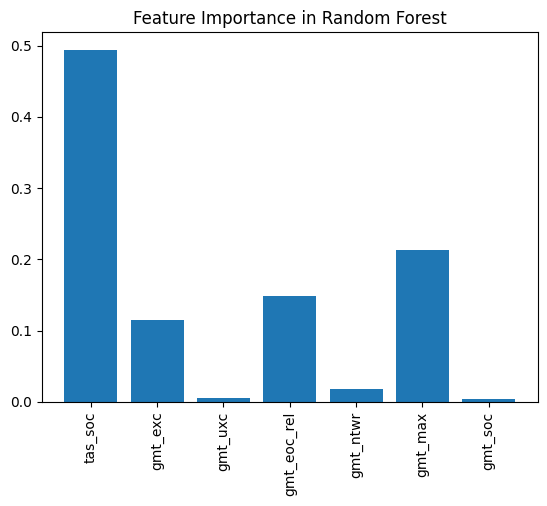

SP
0.9346182360926955
0.839120435143054


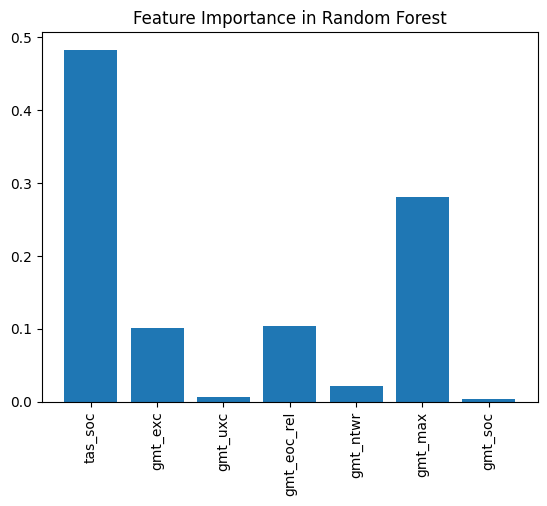

Neg
0.9340577835388881
0.8894163816772503


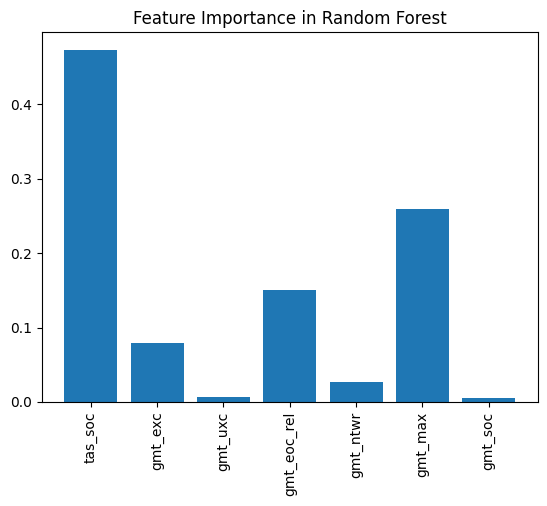

LD
0.9325399810049338
0.9047232831322637


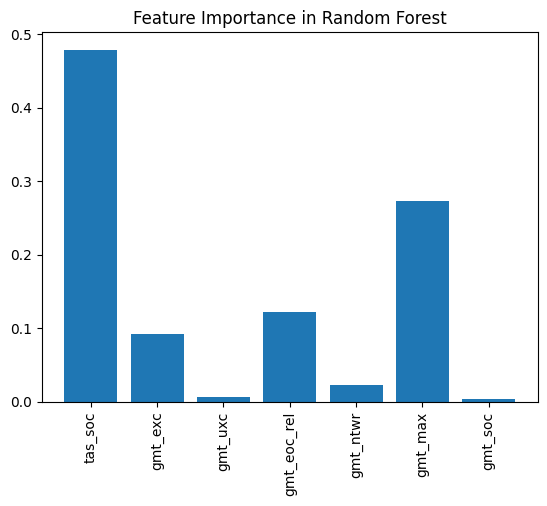

Ren
0.9356947202845758
0.8618263065859797


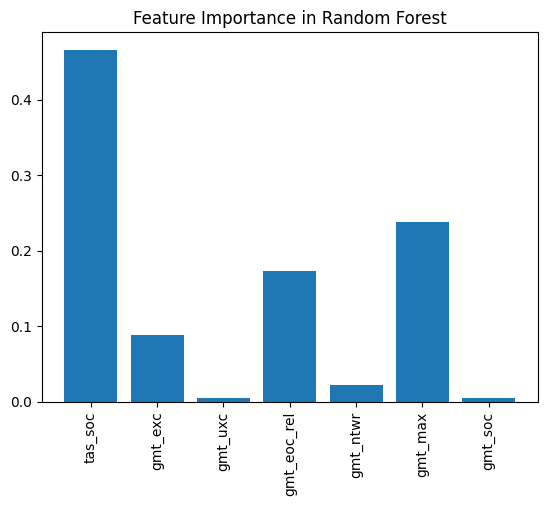

Ref
0.9385060552473101
0.8025176191952176


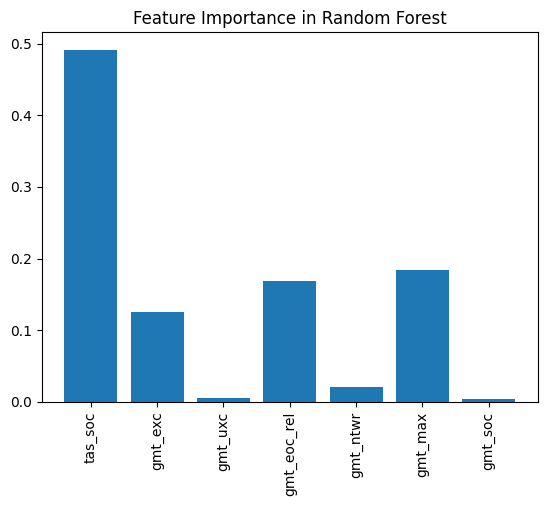

GS
0.9369211781663085
0.8618264623953348


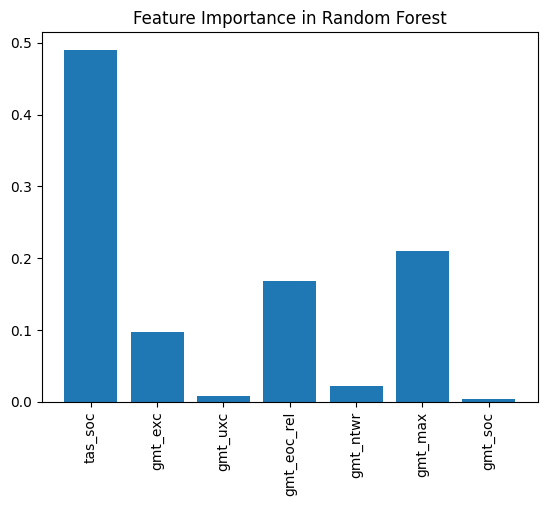

ssp534-over
0.9378957720214817
0.6225317595013582


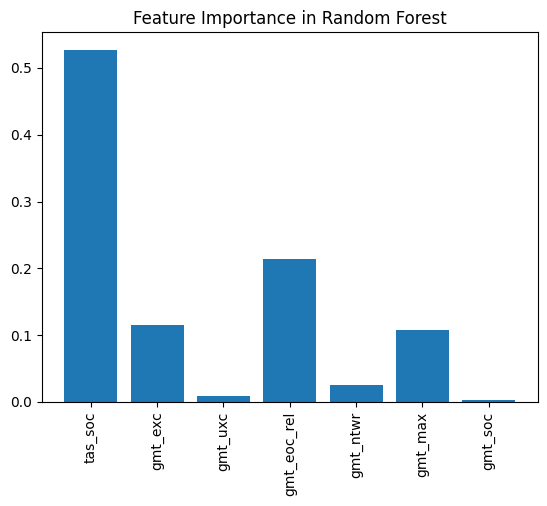

ModAct
0.9332400562001617
0.8183168672181744


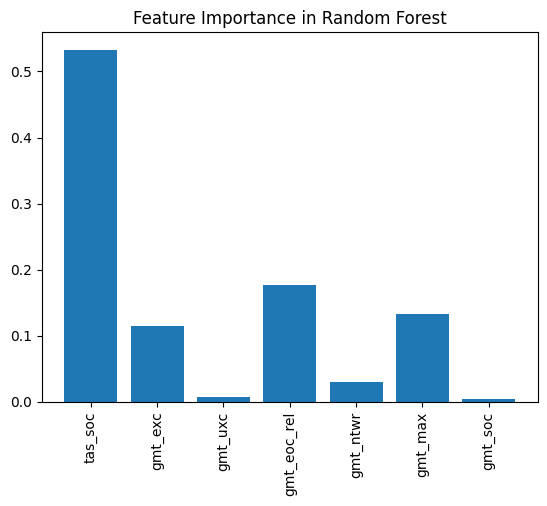

CurPol
0.9358570803304874
0.6668971155974363


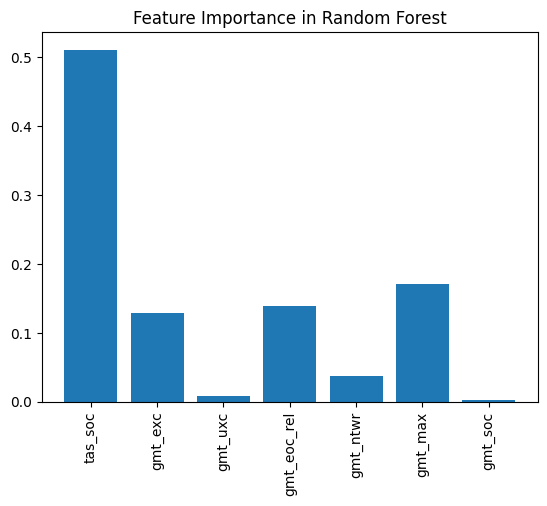

In [969]:
# print a map showing where which feature is important 
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc_rel', 'gmt_ntwr', 'gmt_max', 'gmt_soc']


iso = 'NGA'
# subset data for the country 
country_data  = regression_df[regression_df['iso'] == iso]
y_country     = np.log(country_data['diff_SSP2'].values)

for scenario in cset.scenarios: 
    print(scenario)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[~country_data.scen_run.str.contains(scenario),:]
    y_train       = y_country[~country_data.scen_run.str.contains(scenario)]
    X_test        = X_country[country_data.scen_run.str.contains(scenario),:]
    y_test        = y_country[country_data.scen_run.str.contains(scenario)]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 100, max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, random_state=42)
    # rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    print(rf.score(X_train,y_train))
    print(rf.score(X_test, y_test))

    # # get feature importances 
    # feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
    # feature_importances = feature_importances.sort_values('importance', ascending=False)
    # feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()
    # print(iso)
    # print(feature_importances.head(10))
    # print('\n')

    importance = rf.feature_importances_
    plt.bar(range(X_country.shape[1]), importance)
    plt.xticks(range(X_country.shape[1]), sel_predictors, rotation=90)
    plt.title("Feature Importance in Random Forest")
    plt.show()

0.9395995260387469
0.8930028244721692


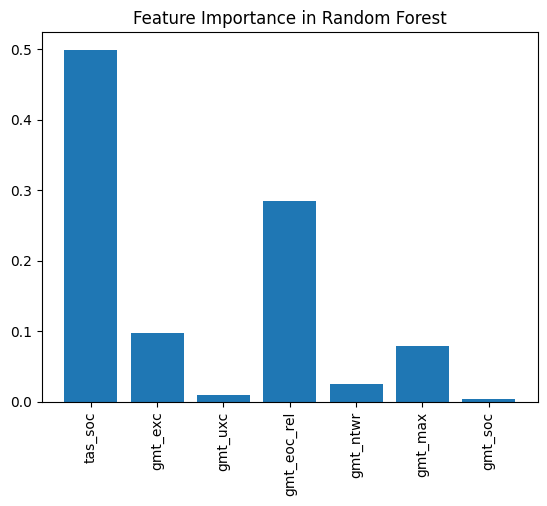

In [962]:
# print a map showing where which feature is important 
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc_rel', 'gmt_ntwr', 'gmt_max', 'gmt_soc']


iso = 'NGA'
# subset data for the country 
country_data  = regression_df[regression_df['iso'] == iso]
y_country     = np.log(country_data['diff_SSP2'].values)
X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
X_country     = StandardScaler().fit_transform(X_country_raw)
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True)]
# fit random forest regressor 
rf = RandomForestRegressor(n_estimators = 100, max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, random_state=42)
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test, y_test))

# # get feature importances 
# feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
# feature_importances = feature_importances.sort_values('importance', ascending=False)
# feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()
# print(iso)
# print(feature_importances.head(10))
# print('\n')

importance = rf.feature_importances_
plt.bar(range(X_country.shape[1]), importance)
plt.xticks(range(X_country.shape[1]), sel_predictors, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

In [987]:
# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, 'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_max_rel']  = regression_df['gmt_max'] - regression_df['gmt_eoc']
regression_df['gmt_uxc_adj'] = (1-regression_df['gmt_frac_os'])*1.5 + regression_df['gmt_uxc']
regression_df['gmt_exc_adj'] = regression_df['gmt_frac_os']*1.5 + regression_df['gmt_exc']
regression_df['gmt_eoc_rel'] = regression_df['gmt_eoc'] - regression_df['gmt_soc']
regression_df['gmt_max_rel'] = regression_df['gmt_max'] - regression_df['gmt_soc']
# Preparing Data 
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'gmt_cum', 'model_id'])
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names = poly.get_feature_names_out(predictors)
predictor_df       = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

In [834]:
# step 1: find best random forst model 
from sklearn.model_selection import RandomizedSearchCV
from joblib import Parallel, delayed 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
##
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'gmt_ntwr', 'gmt_max', 'gmt_cum', 'gmt_frac_os']

result_dict = {}

countries = np.unique(regression_df['iso'])

def fit_function(iso, country_data):
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=False, random_state=42, n_jobs = -1)
    
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)

    X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True),:]
    y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True)]

    # Fit the random search model
    rf_random.fit(X_train, y_train)
    return(rf_random.best_params_)

random_params = Parallel(n_jobs = -1)(delayed(fit_function)(iso, regression_df[regression_df['iso'] == iso]) for iso in tqdm(countries, total = len(countries)))


# for iso in tqdm(countries, total = len(countries)):
#     # Use the random grid to search for best hyperparameters
#     # First create the base model to tune
#     rf = RandomForestRegressor()
#     # Random search of parameters, using 3 fold cross validation, 
#     # search across 100 different combinations, and use all available cores
#     rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=False, random_state=42, n_jobs = -1)

#     # subset data for the country 
#     country_data  = regression_df[regression_df['iso'] == iso]
#     y_country     = np.log(country_data['diff_SSP2'].values)
#     X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
#     X_country     = StandardScaler().fit_transform(X_country_raw)

#     X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True),:]
#     y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True)]
#     X_test        = X_country[country_data.scen_run.str.contains(r'Neg|LD|ModAct', regex = True),:]
#     y_test        = y_country[country_data.scen_run.str.contains(r'Neg|LD|ModAct', regex = True)]

#     # Fit the random search model
#     rf_random.fit(X_train, y_train)
#     result_dict[iso] = rf_random.best_params_


# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

# base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
# base_model.fit(X_train, y_train)
# base_accuracy = evaluate(base_model, X_test, y_test)

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, X_test, y_test)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

  0%|          | 0/157 [00:00<?, ?it/s]

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [835]:
result_dict = dict(zip(countries, random_params))

In [836]:
# import joblib
# joblib.dump(result_dict, cset.path_PROJECT / "Data" / "Results" / "random_forest_randomCVparams.pkl")
result_dict = joblib.load(cset.path_PROJECT / "Data" / "Results" / "random_forest_randomCVparams.pkl")

['/Users/schoens/Documents/Projekte/Econ/Data/Results/random_forest_randomCVparams.pkl']

In [852]:
result_dict['USA']

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [853]:
rf = RandomForestRegressor(**result_dict['USA'])
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [854]:
feature_rating      = pd.DataFrame(columns = np.unique(regression_df['iso']), index = sel_predictors)

for iso in tqdm(np.unique(regression_df['iso']), total = len(np.unique(regression_df['iso']))): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True),:]
    y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True)]
    X_test        = X_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True),:]
    y_test        = y_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True)]
    # fit random forest regressor 
    rf = RandomForestRegressor(**result_dict[iso])
    rf.fit(X_train, y_train)
    # print(rf.score(X_test, y_test))
    
    # get feature importances 
    feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()
    # print(iso)
    # print(feature_importances.head(10))
    # print('\n')
print(feature_rating.sum(axis = 1).sort_values(ascending = True))

tas_soc          12
gmt_eoc         199
gmt_exc         422
gmt_max         455
gmt_cum         611
gmt_ntwr        660
gmt_uxc         941
gmt_frac_os    1096
dtype: int64


In [886]:
regression_df['gmt_uxc_adj'] = (1-regression_df['gmt_frac_os'])*1.5 - regression_df['gmt_uxc']

In [900]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'gmt_ntwr', 'gmt_max']

feature_rating      = pd.DataFrame(columns = np.unique(regression_df['iso']), index = sel_predictors)

for iso in tqdm(np.unique(regression_df['iso']), total = len(np.unique(regression_df['iso']))): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True),:]
    y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True)]
    X_test        = X_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True),:]
    y_test        = y_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True)]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators = 200, random_state = 42)
    rf.fit(X_train, y_train)
    # print(rf.score(X_test, y_test))
    
    # get feature importances 
    feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()
    # print(iso)
    # print(feature_importances.head(10))
    # print('\n')
print(feature_rating.sum(axis = 1).sort_values(ascending = True))

  0%|          | 0/157 [00:00<?, ?it/s]

tas_soc         15
gmt_eoc        176
gmt_max        303
gmt_ntwr       494
gmt_exc_adj    590
gmt_uxc_adj    777
dtype: int64


tas_soc


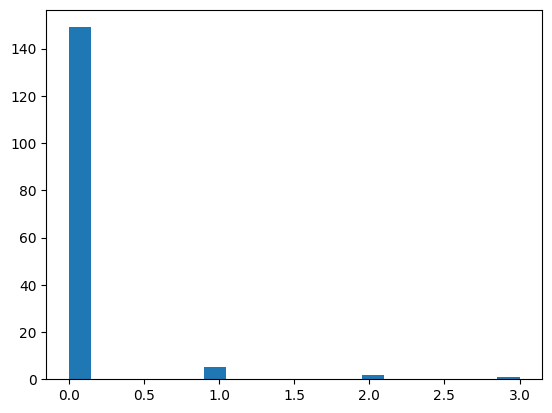

gmt_exc


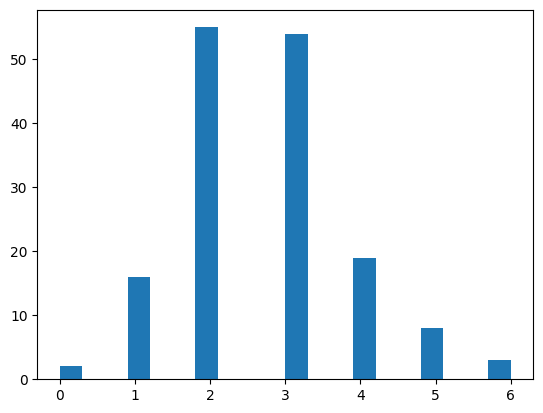

gmt_uxc


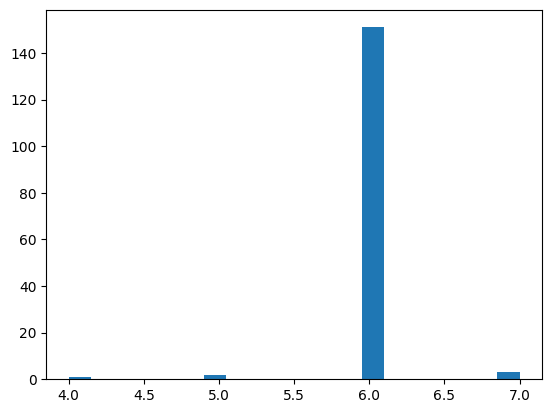

gmt_eoc


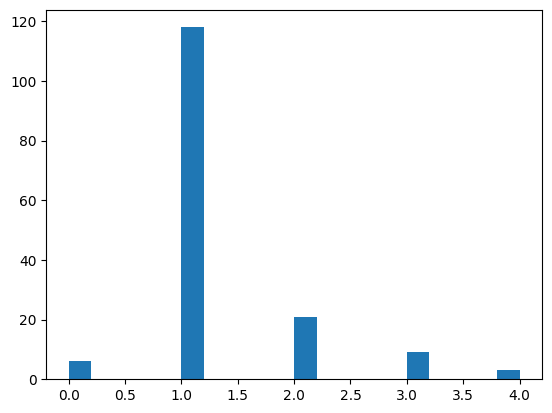

gmt_ntwr


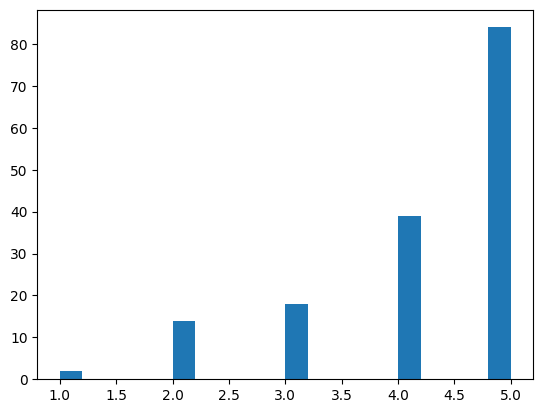

gmt_max


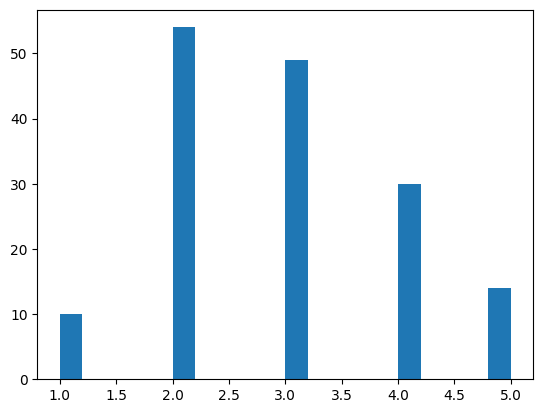

gmt_cum


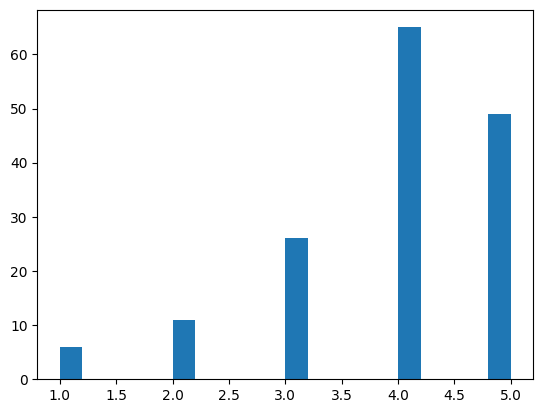

gmt_frac_os


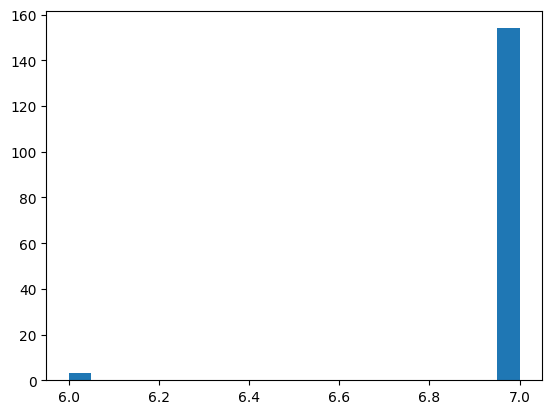

In [859]:
for i in range(len(feature_rating)):
    print(feature_rating.index[i])
    plt.figure()
    plt.hist(feature_rating.iloc[i,:], bins = 20)
    plt.show()

In [848]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 300}

In [830]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
print(base_model.score(X_test, y_test))
best_random = rf_random.best_estimator_
print(best_random.score(X_test, y_test))

0.9077601107075617
0.9149221255902348


In [816]:
rf_random.best_params_

{'n_estimators': 733,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [817]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100, 110, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV]

In [828]:
best_grid.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 100,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [819]:
best_grid.score(X_test,y_test)

0.8976512190167593

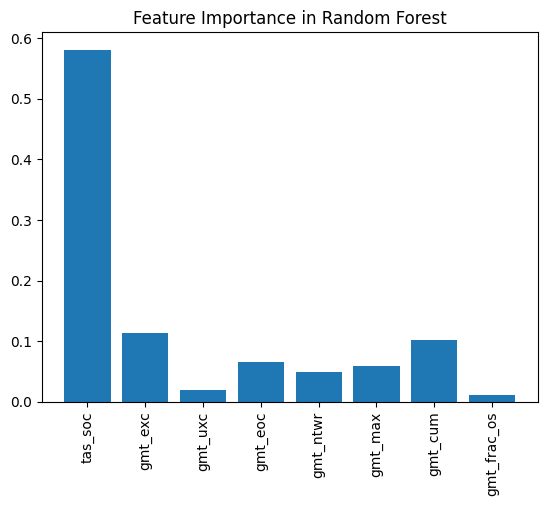

In [821]:
importance = best_grid.feature_importances_
plt.bar(range(X_country.shape[1]), importance)
plt.xticks(range(X_country.shape[1]), sel_predictors, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

In [791]:
# for each country perform feature selection: 
from sklearn.ensemble import RandomForestRegressor

regression_df.index = predictor_df.index
sel_predictors      = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'gmt_ntwr', 'gmt_max', 'gmt_cum', 'gmt_frac_os'] 

feature_rating      = pd.DataFrame(columns = np.unique(regression_df['iso']), index = sel_predictors)

for iso in np.unique(regression_df['iso']): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True),:]
    y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True)]
    X_test        = X_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True),:]
    y_test        = y_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True)]
    # fit random forest regressor 
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    # print(rf.score(X_test, y_test))
    
    # get feature importances 
    feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()
    # print(iso)fn_
    # print(feature_importances.head(10))
    # print('\n')
print(feature_rating.sum(axis = 1).sort_values(ascending = True))

In [801]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'gmt_ntwr', 'gmt_max', 'gmt_cum', 'tas_baseline tas_soc', 'gmt_exc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_eoc tas_baseline', 'gmt_ntwr tas_baseline', 'gmt_max tas_baseline', 'gmt_cum tas_baseline']
# subset data for the country 
country_data  = regression_df.copy()
y_country     = np.log(country_data['diff_SSP2'].values)
X_country_raw = predictor_df.loc[:, sel_predictors]
X_country     = StandardScaler().fit_transform(X_country_raw)
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'Neg|LD|ModAct', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'Neg|LD|ModAct', regex = True)]
# fit random forest regressor 
# rf = RandomForestRegressor(n_estimators = 100, max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test, y_test))

0.989024317237677
0.9172596194905847


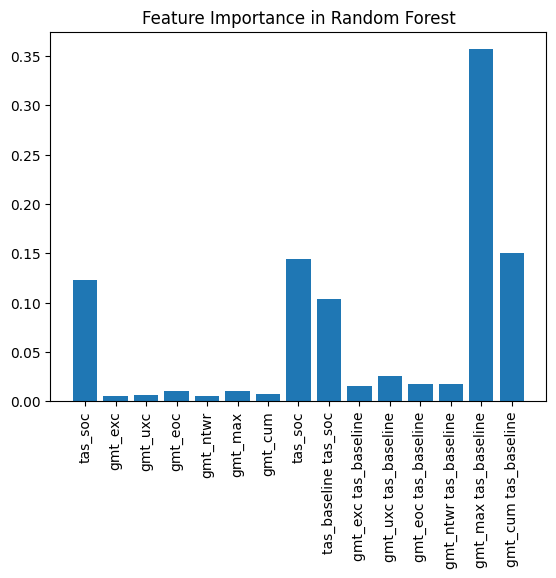

In [802]:
importance = rf.feature_importances_
plt.bar(range(X_country.shape[1]), importance)
plt.xticks(range(X_country.shape[1]), sel_predictors, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

In [942]:
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc_rel', 'gmt_ntwr', 'gmt_max', 'gmt_soc']
iso = 'BGD'
# subset data for the country 
country_data  = regression_df[regression_df['iso'] == iso]
y_country     = np.log(country_data['diff_SSP2'].values)
X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
X_country     = StandardScaler().fit_transform(X_country_raw)
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|ssp534-over', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'Neg|LD|ModAct', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'Neg|LD|ModAct', regex = True)]
# fit random forest regressor 
rf = RandomForestRegressor(n_estimators = 100, max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, random_state=42)
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test, y_test))

# # get feature importances 
# feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
# feature_importances = feature_importances.sort_values('importance', ascending=False)
# feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()
# print(iso)
# print(feature_importances.head(10))
# print('\n')


0.9424226834049584
0.9001247535037413


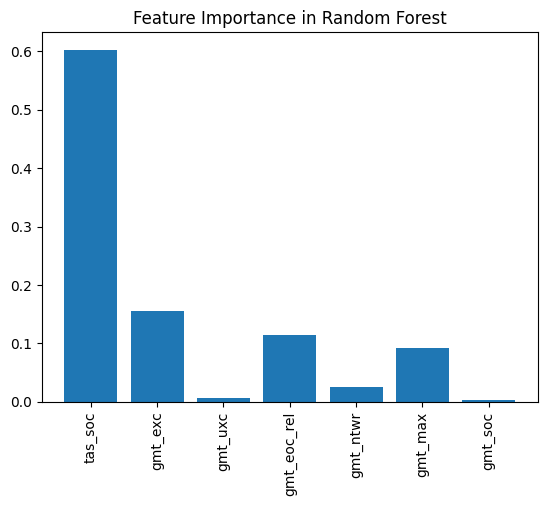

In [941]:
importance = rf.feature_importances_
plt.bar(range(X_country.shape[1]), importance)
plt.xticks(range(X_country.shape[1]), sel_predictors, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

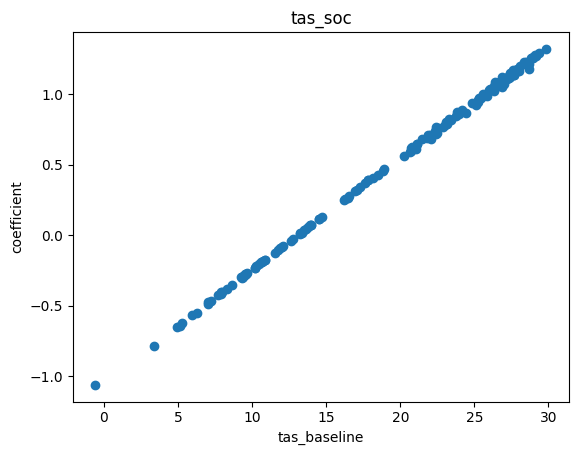

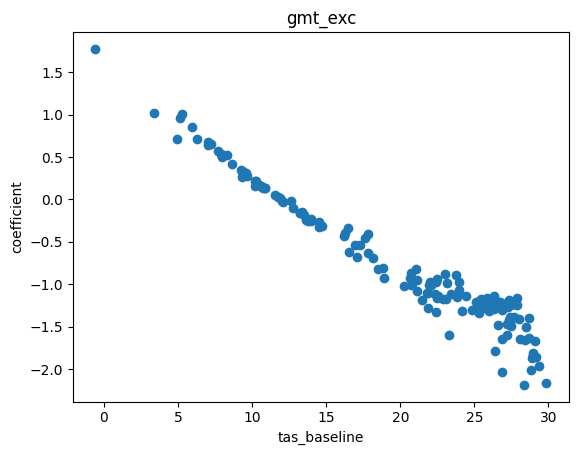

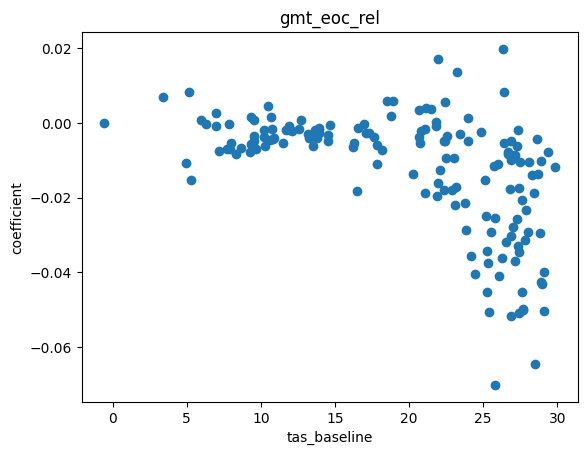

In [77]:
# fit regular linear model with all these parameters and check evolution over tas_baseline
# sel_predictors = ['gmt_ntwr', 'gmt_max', 'gmt_eoc', 'gmt_soc', 'gmt_exc', 'gmt_uxc', 'tas_soc'] 
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_soc', 'gmt_eoc_rel'] 

coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
tas_baselines    = []
gdp_baselines    = []
i_iso = 0 
for iso in np.unique(regression_df['iso']): 
    # subset data for the country 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    # X_country     = np.c_[StandardScaler().fit_transform(X_country_raw), np.ones(len(y_country))]
    X_country     = np.c_[X_country_raw, np.ones(len(y_country))]
    coefficients[i_iso, :] =  LinearRegression().fit(X_country, y_country).coef_
    tas_baselines.append(np.mean(country_data['tas_baseline']))
    gdp_baselines.append(np.mean(country_data['GDP_baseline']))
    i_iso += 1
    
for i_pred in range(len(sel_predictors)):
    plt.figure()
    plt.scatter(tas_baselines, coefficients[:, i_pred])
    plt.xlabel('tas_baseline')
    plt.ylabel('coefficient')
    plt.title(sel_predictors[i_pred])
    plt.show()

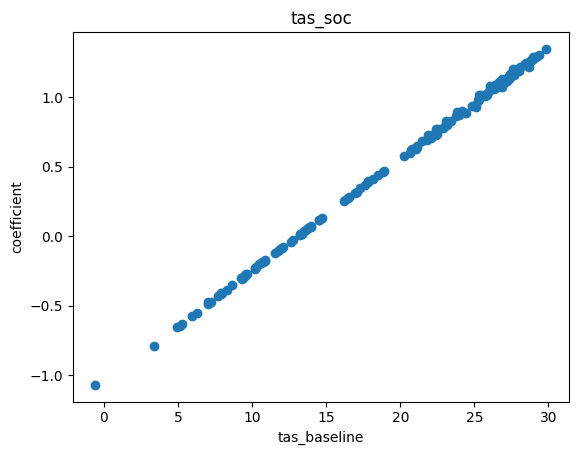

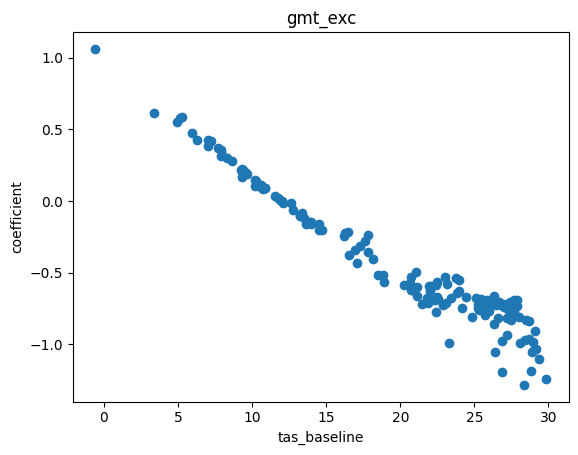

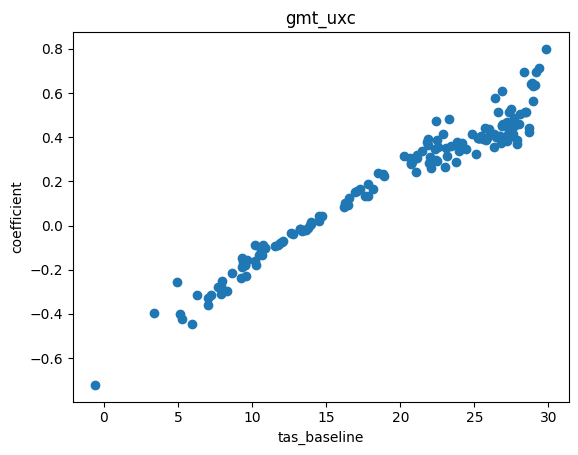

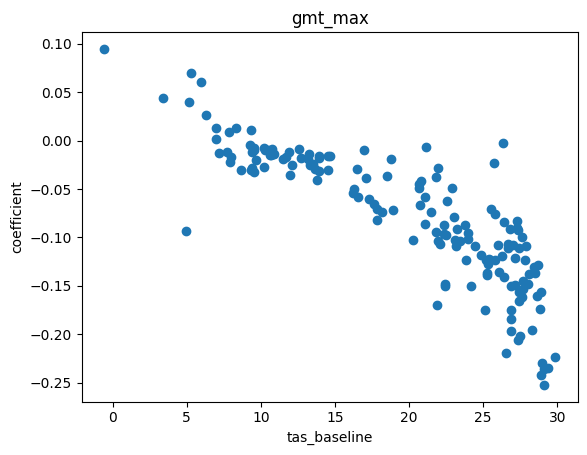

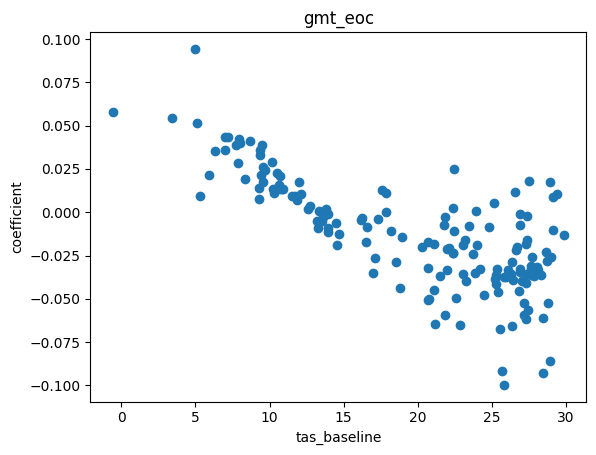

In [872]:
for i_pred in range(len(sel_predictors)):
    plt.figure()
    plt.scatter(tas_baselines, coefficients[:, i_pred])
    plt.xlabel('tas_baseline')
    plt.ylabel('coefficient')
    plt.title(sel_predictors[i_pred])
    plt.show()

In [737]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, Lasso

sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'gmt_ntwr', 'gmt_max', 'gmt_cum', 'tas_soc^2', 'gmt_exc^2', 'gmt_uxc^2', 'gmt_eoc^2', 'gmt_ntwr^2', 'gmt_max^2', 'gmt_cum^2'] 
sel_predictors = ['tas_soc', 'gmt_exc', 'gmt_uxc', 'gmt_eoc', 'gmt_ntwr', 'gmt_max', 'gmt_cum'] 
coefficients = np.zeros((len(np.unique(regression_df['iso'])), len(sel_predictors)+1))
tas_baselines    = []
gdp_baselines    = []


feature_rating = pd.DataFrame(columns = np.unique(regression_df['iso']), index = sel_predictors)

for iso in np.unique(regression_df['iso']): 
    country_data  = regression_df[regression_df['iso'] == iso]
    y_country     = np.log(country_data['diff_SSP2'].values)
    X_country_raw = predictor_df.loc[regression_df['iso'] == iso, sel_predictors]
    X_country     = StandardScaler().fit_transform(X_country_raw)
    # X_country     = np.c_[X_country_raw, np.ones(len(y_country))]

    # X_train       = X_country[country_data.scen_run.str.contains(r'Ref|GS|LD|ModAct|ssp119|Ren|SP', regex = True),:]
    # y_train       = y_country[country_data.scen_run.str.contains(r'Ref|GS|LD|ModAct|ssp119|Ren|SP', regex = True)]
    X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True),:]
    y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref', regex = True)]
    X_test        = X_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True),:]
    y_test        = y_country[country_data.scen_run.str.contains(r'Neg|ssp534-over|ModAct', regex = True)]

    # X_train, X_test, y_train, y_test = train_test_split(X_country, y_country, test_size = 0.3, random_state=10)
    model = Lasso(alpha = 0.001).fit(X_train, y_train)
    # print(model.score(X_test, y_test))

    r = permutation_importance(model, X_test, y_test, n_repeats=30,random_state=0)
    
    # feature_rating.loc[:, iso] = r.importances_mean.argsort()[::-1]


    score = 0 
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            feature_rating.loc[sel_predictors[i], iso] = score
            score += 1
        else: 
            feature_rating.loc[sel_predictors[i], iso] = np.nan 
    #         print(f"{(sel_predictors)[i]:<8}"
    #         f"{r.importances_mean[i]:.3f}"
    #         f" +/- {r.importances_std[i]:.3f}")
            
            
    #         feature_importances = pd.DataFrame({'feature': sel_predictors, 'importance': rf.feature_importances_})
    #         feature_importances = feature_importances.sort_values('importance', ascending=False)
    #         feature_rating.loc[:, iso] = feature_importances.sort_values('importance', ascending=False).index.argsort()

In [181]:
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'model_id', 'gmt_frac_os', 'GDP_baseline', 'gmt_cum'])
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names = poly.get_feature_names_out(predictors)
predictor_df       = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

In [294]:
# select important variable via forward and backward selection
# note: the model selection via BIC is prone to overfitting, 
# that is more and more variables are selected while quality metrics 
# such as R^2 or RMSE do not significantly improve 

# Functions for fitting model
def fit_model_and_calculate_bic(X_, y_):
    model = sm.OLS(endog = y_, exog = X_).fit()
    return model.bic, model.rsquared, model


all_predictors     = list(predictors) + list(interaction_terms)

best_rsquared = 0
threshold_r   = 0
threshold_in  = 20
threshold_out = 20
included      = []
best_bic      = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _      = fit_model_and_calculate_bic(X, y)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break

138832.95195222262
['gmt_cum tas_baseline']
78770.97559126373
['gmt_cum tas_baseline', 'tas_baseline tas_soc']
-90228.05737245758
['gmt_cum tas_baseline', 'tas_baseline tas_soc', 'tas_soc']
-209133.02495659597
['gmt_cum tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_cum']
-209772.7433510148
['gmt_cum tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_cum', 'gmt_exc_tot']


KeyboardInterrupt: 

In [902]:
predictor_df.loc[:, sel_predictors].copy()

gmt_exc tas_baseline  tas_baseline tas_soc    tas_soc   gmt_exc  \
0                   9.291395            194.811797  14.288971  0.681501   
1                   3.679011            203.849858  14.951891  0.269847   
2                   9.783286            196.951021  14.445878  0.717580   
3                   3.679011            184.993158  13.568798  0.269847   
4                   4.803555            192.452843  14.115947  0.352329   
...                      ...                   ...        ...       ...   
156995              8.802707            470.657014  21.591091  0.403819   
156996              7.878317            469.674304  21.546010  0.361413   
156997              7.878317            492.941332  22.613370  0.361413   
156998             18.342134            479.307378  21.987921  0.841434   
156999             13.981665            477.050398  21.884384  0.641400   

        gmt_uxc tas_baseline   gmt_uxc  gmt_eoc  gmt_eoc tas_baseline  
0                   0.209468  0.015364   3.1931             43.533825  
1                   1.403528  0.102945   2.4112             32.873621  
2                   0.197515  0.014487   3.3060             45.073071  
3                   1.403528  0.102945   2.4112             32.873621  
4                   1.116475  0.081891   2.6126             35.619451  
...                      ...       ...      ...                   ...  
156995              0.938661  0.043060   1.8069             39.388012  
156996              0.752231  0.034508   1.7505             38.158567  
156997              0.752231  0.034508   1.7505             38.158567  
156998              0.473893  0.021740   2.5757             56.146827  
156999              0.295321  0.013548   2.0966             45.703085  

[157000 rows x 8 columns]

In [964]:
sel_predictors = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc', 'gmt_eoc tas_baseline']
country_data = regression_df.copy()
X_country     = predictor_df.loc[:, sel_predictors].copy().values
y_country     = np.log(regression_df['diff_SSP2'])
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True)]
X_intercept_train = X_intercept[regression_df.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
X_intercept_test = X_intercept[regression_df.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]


linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print(linreg.score(np.c_[X_train, X_intercept_train], y_train))
print(linreg.score(np.c_[X_test, X_intercept_test], y_test))

0.940950480356259
0.924232341016272


In [965]:
sel_predictors = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_soc tas_baseline']
country_data = regression_df.copy()
X_country     = predictor_df.loc[:, sel_predictors].copy().values
y_country     = np.log(regression_df['diff_SSP2'])
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True)]
X_intercept_train = X_intercept[regression_df.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
X_intercept_test = X_intercept[regression_df.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]


linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print(linreg.score(np.c_[X_train, X_intercept_train], y_train))
print(linreg.score(np.c_[X_test, X_intercept_test], y_test))

0.9490583553051561
0.9450681560591778


In [966]:
sel_predictors = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc_rel', 'gmt_eoc_rel tas_baseline']
country_data = regression_df.copy()
X_country     = predictor_df.loc[:, sel_predictors].copy().values
y_country     = np.log(regression_df['diff_SSP2'])
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True)]
X_intercept_train = X_intercept[regression_df.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
X_intercept_test = X_intercept[regression_df.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]


linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print(linreg.score(np.c_[X_train, X_intercept_train], y_train))
print(linreg.score(np.c_[X_test, X_intercept_test], y_test))

0.9433278133183794
0.9284218840651093


In [967]:
sel_predictors = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max', 'gmt_max tas_baseline']
country_data = regression_df.copy()
X_country     = predictor_df.loc[:, sel_predictors].copy().values
y_country     = np.log(regression_df['diff_SSP2'])
X_train       = X_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
y_train       = y_country[country_data.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True)]
X_test        = X_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]
y_test        = y_country[country_data.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True)]
X_intercept_train = X_intercept[regression_df.scen_run.str.contains(r'GS|LD|ssp119|Ren|SP|CurPol|Ref|LD|ModAc', regex = True),:]
X_intercept_test = X_intercept[regression_df.scen_run.str.contains(r'SP|ssp119|ssp534-over', regex = True),:]


linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print(linreg.score(np.c_[X_train, X_intercept_train], y_train))
print(linreg.score(np.c_[X_test, X_intercept_test], y_test))

0.9395170982296228
0.9331309608068281


In [866]:
# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, 'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_max_rel']  = regression_df['gmt_max'] - regression_df['gmt_eoc']
# Preparing Data 
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'gmt_cum', 'gmt_soc', 'model_id'])
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names = poly.get_feature_names_out(predictors)
predictor_df       = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

In [559]:
from sklearn.ensemble import RandomForestRegressor

regression_df.index = predictor_df.index
iso = 'NGA'
 
# subset data for the country 
country_data  = regression_df[regression_df['iso'] == iso]
y_country     = np.log(country_data['diff_SSP2'].values)
X_country_raw = predictor_df.loc[regression_df['iso'] == iso, ['gmt_ntwr', 'gmt_max', 'gmt_eoc', 'gmt_soc', 'gmt_od', 'gmt_exc', 'gmt_uxc', 'tas_soc']]
X_country     = StandardScaler().fit_transform(X_country_raw)
# fit random forest regressor 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_country, y_country)

# get feature importances 
feature_importances = pd.DataFrame({'feature': ['gmt_ntwr', 'gmt_max', 'gmt_eoc', 'gmt_soc', 'gmt_od', 'gmt_exc', 'gmt_uxc', 'tas_soc'], 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(iso)
print(feature_importances.head(10))
print('\n')

NGA
    feature  importance
7   tas_soc    0.484044
1   gmt_max    0.287672
5   gmt_exc    0.115277
2   gmt_eoc    0.048321
0  gmt_ntwr    0.032795
4    gmt_od    0.011112
6   gmt_uxc    0.010692
3   gmt_soc    0.010087




In [550]:
X_country_raw = predictor_df.loc[regression_df['iso'] == iso, ['gmt_ntwr', 'gmt_max', 'gmt_eoc', 'gmt_soc', 'gmt_od', 'gmt_exc', 'gmt_uxc', 'tas_soc']]
X_country     = StandardScaler().fit_transform(X_country_raw)
bic, r, model = fit_model_and_calculate_bic(X_country, y_country)
print(r)

0.003947761334784028


In [541]:
# select important variable via forward and backward selection
# note: the model selection via BIC is prone to overfitting, 
# that is more and more variables are selected while quality metrics 
# such as R^2 or RMSE do not significantly improve 
best_rsquared = 0
threshold_r   = 0
threshold_in  = 100
threshold_out = 100
included      = ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc']
best_bic      = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _      = fit_model_and_calculate_bic(X, y)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break

-183932.8938163087
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline']
-191104.90182183252
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2']
-191576.9966591352
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'gmt_exc^2']
-191756.583361433
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'gmt_exc^2', 'gmt_ntwr tas_baseline']
-192352.88103968732
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'gmt_exc^2', 'gmt_ntwr tas_baseline', 'gmt_ntwr^2']
-192635.09892939226
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'g

In [481]:
# Functions for fitting model
def fit_model_and_calculate_bic(X_, y_):
    model = sm.OLS(endog = y_, exog = X_).fit()
    return model.bic, model.rsquared, model

In [482]:
# select important variable via forward and backward selection
# note: the model selection via BIC is prone to overfitting, 
# that is more and more variables are selected while quality metrics 
# such as R^2 or RMSE do not significantly improve 
best_rsquared = 0
threshold_r   = 0
threshold_in  = 100
threshold_out = 100
included      = ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc']
best_bic      = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _      = fit_model_and_calculate_bic(X, y)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break

-183932.8938163087
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline']
-191104.90182183252
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2']
-191576.9966591352
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'gmt_exc^2']
-191756.583361433
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'gmt_exc^2', 'gmt_ntwr tas_baseline']
-192352.88103968732
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'gmt_exc^2', 'gmt_ntwr tas_baseline', 'gmt_ntwr^2']
-192635.09892939226
['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc tas_baseline', 'gmt_soc^2', 'g

In [ ]:
from sklearn.metrics import r2_score

best_rsquared = 0
threshold_r   = 0
threshold_in  = 100
threshold_out = 100
included      = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc']
best_bic      = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, model      = fit_model_and_calculate_bic(X, y)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, model = fit_model_and_calculate_bic(X, y)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break

In [ ]:
# select important variable via forward and backward selection
# note: the model selection via BIC is prone to overfitting, 
# that is more and more variables are selected while quality metrics 
# such as R^2 or RMSE do not significantly improve 
best_rsquared = 0
threshold_r   = 0
threshold_in  = 100
threshold_out = 100
included      = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc']
best_bic      = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _      = fit_model_and_calculate_bic(X, y)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break

-161545.0684509714
['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline']
-171105.52105212165
['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_ntwr tas_baseline']
-176472.69356250972
['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_ntwr tas_baseline', 'gmt_eoc tas_baseline']
-179888.14298532018
['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_ntwr tas_baseline', 'gmt_eoc tas_baseline', 'tas_soc^2']
-180682.78356375056
['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_ntwr tas_baseline', 'gmt_eoc tas_baseline', 'tas_soc^2', 'gmt_exc^2']
-181454.72273477595
['gmt_exc tas_baseli

In [ ]:
gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)

In [494]:
gdp_df   = pd.read_csv(Path.joinpath(cset.path_GDP, 'Full Data BHM Main Result.csv')).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df 
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

regression_df['SSP2'] = gdp_df['SSP2'].values.copy()
regression_df['SSP2_clim'] = gdp_df['SSP2_clim'].values.copy()


In [499]:
sel_predictors = ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max', 'gmt_max^2', 'gmt_max tas_baseline']
y              = np.log(regression_df['SSP2_clim'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], np.log(regression_df[['SSP2']]), X_intercept], y)
print(r)

0.7551895637503909


In [352]:
# sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_max', 'gmt_max tas_baseline']
# sel_predictors = ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max', 'gmt_max^2', 'gmt_max tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline', 'gmt_soc^2']
# sel_predictors = ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max']
sel_predictors = ['tas_soc', 'tas_baseline tas_soc', 'gmt_ntwr', 'gmt_ntwr tas_baseline', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_od', 'gmt_od tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline']
y              = np.log(regression_df['diff_SSP2'].values)
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
print(r)

result_df                  = pd.DataFrame(X_poly, columns = poly_feature_names)[sel_predictors]
result_df['log_diff_SSP2'] = np.log(regression_df['diff_SSP2'].values)
result_df['iso']           = regression_df['iso'].values
result_df['scen_run']      = regression_df['scen_run'].values
result_df['tas_baseline']  = regression_df['tas_baseline'].values
# result_df['model_id']      = regression_df['model_id'].values

cset.path_CHAR_results.mkdir(parents=True, exist_ok=True)
result_df.to_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'))

0.9476966229685347


In [64]:
model.params[:6]

x1   -1.045254
x2    0.079990
x3    1.156203
x4   -0.090585
x5   -0.017174
x6    0.000054
dtype: float64

In [444]:
import statsmodels.formula.api as smf
regression_df['log_diff_SSP2'] = np.log(regression_df['diff_SSP2'].values)
sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'gmt_max', 'gmt_max tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline']
data           = predictor_df[sel_predictors].merge(regression_df[['iso', 'model_id', 'log_diff_SSP2']], left_index=True, right_index=True)
data.columns   = [f.replace(' ', '_') for f in data.columns]
data.columns   = [f.replace('^2', '2') for f in data.columns]

In [445]:
md  = smf.mixedlm("log_diff_SSP2 ~ gmt_exc + gmt_exc_tas_baseline + gmt_uxc + gmt_uxc_tas_baseline + tas_soc + tas_soc2 + tas_baseline_tas_soc", data, groups=data["model_id"], re_formula="~gmt_exc + gmt_exc_tas_baseline + gmt_uxc + gmt_uxc_tas_baseline")
mdf = md.fit(method=["lbfgs"])

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [446]:
print(mdf.summary())

                           Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_diff_SSP2
No. Observations:             157000            Method:                       REML         
No. Groups:                   25                Scale:                        0.3383       
Min. group size:              4396              Log-Likelihood:               -137905.7531 
Max. group size:              7850              Converged:                    Yes          
Mean group size:              6280.0                                                       
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                       -0.289    0.008 -35.092 0.000 -0.305 -0.273
gmt_exc        

In [430]:
data

gmt_exc  gmt_exc tas_baseline   gmt_uxc  gmt_uxc tas_baseline  \
0       1.364048              0.565016 -0.560150             -0.517549   
1       0.053228             -0.235167  0.055039             -0.125883   
2       1.469813              0.629580 -0.568021             -0.522560   
3       0.053228             -0.235167  0.055039             -0.125883   
4       0.317627             -0.073767 -0.104702             -0.227583   
...          ...                   ...       ...                   ...   
156995  0.523853              0.615871 -0.349387             -0.292782   
156996  0.404671              0.499547 -0.438348             -0.383339   
156997  0.404671              0.499547 -0.438348             -0.383339   
156998  1.826121              1.886922 -0.495358             -0.441371   
156999  1.252768              1.327313 -0.559377             -0.506538   

        tas_soc^2   tas_soc  tas_baseline tas_soc   gmt_max  \
0        0.293608  1.261309              1.032417  1.959981   
1        2.702187  2.537376              2.076914  0.743271   
2        0.717518  1.563342              1.279640  2.135664   
3       -0.489123 -0.124967             -0.102289  0.743271   
4       -0.068742  0.928253              0.759801  1.056668   
...           ...       ...                   ...       ...   
156995  -0.417554 -0.399567             -0.522924  0.454149   
156996  -0.379355 -0.486344             -0.636492  0.348646   
156997   0.725136  1.568238              2.052397  0.348646   
156998  -0.430940  0.364299              0.476768  1.276856   
156999  -0.483356  0.164998              0.215937  0.919732   

        gmt_max tas_baseline   gmt_soc  gmt_soc tas_baseline  iso  \
0                   0.291602  1.009232              0.657042  AFG   
1                  -0.242478 -1.089817             -0.709504  AGO   
2                   0.368718  1.160751              0.755685  ALB   
3                  -0.242478 -1.089817             -0.709504  ARE   
4                  -0.104911 -0.947024             -0.616542  ARG   
...                      ...       ...                   ...  ...   
156995              0.540948 -0.547205             -0.569597  VNM   
156996              0.466902  0.079495              0.082748  YEM   
156997              0.466902  0.079495              0.082748  ZAF   
156998              1.118352  0.217528              0.226429  ZMB   
156999              0.867710  0.982261              1.022454  ZWE   

             model_id  
0       CNRM-CM6-1-HR  
1       CNRM-CM6-1-HR  
2       CNRM-CM6-1-HR  
3       CNRM-CM6-1-HR  
4       CNRM-CM6-1-HR  
...               ...  
156995     NorESM2-LM  
156996     NorESM2-LM  
156997     NorESM2-LM  
156998     NorESM2-LM  
156999     NorESM2-LM  

[157000 rows x 13 columns]

In [410]:
sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'gmt_max', 'gmt_max tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline']
_, country_model, _ = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)

In [ ]:
plt.figure()
for x_T in [0,7,12, 17, 20, 30]:
    plt.plot(np.arange(1,8,0.5),  country_model.params[6]*np.arange(1,8,0.5) + country_model.params[7]*x_T*np.arange(1,8,0.5))
plt.show()

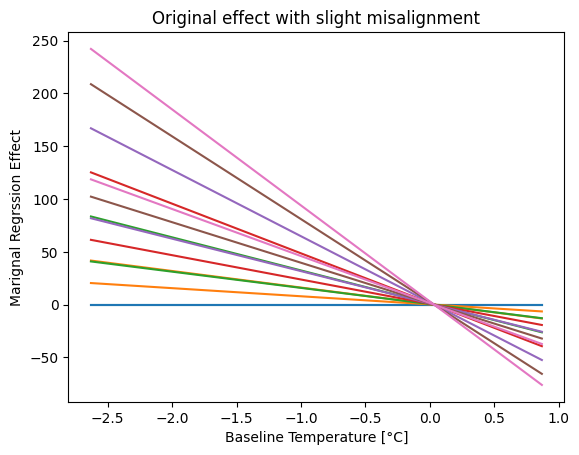

In [417]:
x_EXC = np.arange(-0.84,4,0.05)
x_Ts  = np.arange(-2.63,1.36,0.5) 

# - ordinary regression wihtout intriducing constraints: 
country_model  = sm.OLS(endog = y, exog = X).fit()
from scipy.optimize import curve_fit

def objective_function(x, *a):
    b2    = a[2]/a[0]*a[1]
    a_adj = np.append(a[:3], np.append([b2], a[3:]))
    return(a_adj@x)

popt, pcov = curve_fit(objective_function, 
                       X.T,
                       y,
                       p0 = np.append(country_model.params[:3], 
                                      country_model.params[4:]))

results_country_params = np.append(popt[:3], np.append([popt[2]/popt[0]*popt[1]], popt[3:]))
country_model.params   = results_country_params
plt.figure()
i_color = 0
for x_E in [-0.5,0,0.5,1,1.5,3]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
# plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Original effect with slight misalignment')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

In [350]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


scores = np.zeros((len(cset.gmt_thresholds), 5, 10))
i_threshold = 0
for gmt_threshold in cset.gmt_thresholds: 
    # loading & preparing glmt data 
    glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'gmt_characteristics_thsld_{int(gmt_threshold*100)}.csv'), index_col = 0)

    # merge datasets into a single regression dataset
    regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
    regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
    #   - add baseline temperature values
    regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
    regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
    # regression_df['gmt_max_rel']  = regression_df['gmt_max'] - regression_df['gmt_soc']
    # regression_df['tas_soc']      = regression_df['tas_soc']-regression_df['tas_baseline']

    # Preparing Data 
    y = np.log(regression_df['diff_SSP2'])

    # Define predictor variables (excluding 'iso' and the target variable)
    predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'gmt_cum', 'model_id'])
    # Generate second-order terms
    poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    X_poly     = poly.fit_transform(regression_df[predictors])
    X_poly_std = StandardScaler().fit_transform(X_poly)
    # Extract polynomial feature names
    poly_feature_names = poly.get_feature_names_out(predictors)
    predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)

    # interactions with tas_baseline 
    interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

    # Combine original predictors, interaction terms, and polynomial features 
    all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

    # intercept matrix for country fixed effects  
    n_countries = int(len(regression_df)/1000)
    X_intercept = np.zeros((len(regression_df), n_countries))
    for i in range(n_countries):
        X_intercept[i*1000:(i+1)*1000, i] = 1

    unique_models      = np.unique(regression_df['model_id'].values)
    n_models           = len(unique_models)
    X_model_correction = np.zeros((len(regression_df), n_models))
    for i in range(n_models):   
        model_id = unique_models[i]
        X_model_correction[regression_df['model_id'] == model_id, i] = 1


    # cvs  = [np.arange(0,78500), 
    #         np.arange(78500,157000)
    #         ]
    # for i in range(2):
    #     cvs.append([idx for idx in range(i*5000, (i+1)*5000)])

    def custom_cv_10folds(X):
        n = X.shape[0]
        i = 1
        while i <= 10:
            idx = np.arange(n * (i - 1) / 10, n * i / 10, dtype=int)
            yield idx, idx
            i += 1

    custom_cv = custom_cv_10folds(X)

    predictor_sets = [
                    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc',  'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
                    # ['gmt_max', 'gmt_eoc', 'gmt_ntwr', 'gmt_od', 'tas_soc', 'tas_soc^2'], 
                    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc'],
                    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max'],
                    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc'],
                    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max'],
                    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max', 'gmt_soc', 'gmt_soc tas_baseline'], 
                    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc'],
                    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_uxc^2', 'gmt_soc', 'gmt_exc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
                    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_max tas_baseline', 'gmt_max']
                    ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_preuxc', 'gmt_preuxc tas_baseline', 'gmt_postuxc', 'gmt_postuxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_max tas_baseline', 'gmt_max']
                    ]
    i_predictor = 0 
    for sel_predictors in predictor_sets:
        lm_cv = LinearRegression()
        X     = np.c_[predictor_df[sel_predictors], X_intercept, X_model_correction]
        custom_cv = custom_cv_10folds(X)
        scores[i_threshold, i_predictor, :] = cross_val_score(lm_cv, X, y, cv = custom_cv, scoring='neg_mean_squared_error')
        i_predictor += 1
    i_threshold += 1

In [490]:
regression_df

iso        scen_run  diff_SSP2  gmt_ntwr  gmt_max  gmt_eoc  gmt_soc  \
0       AFG        CurPol_1   0.881178  0.019043   3.1931  3.13970  1.31556   
1413    AFG       CurPol_10   0.985876  0.014824   2.4112  2.37392  1.02830   
15543   AFG      CurPol_100   0.898922  0.019195   3.3060  3.24742  1.32686   
1570    AFG       CurPol_11   0.884318  0.014824   2.4112  2.37392  1.02830   
1727    AFG       CurPol_12   0.896899  0.016076   2.6126  2.56988  1.06054   
...     ...             ...        ...       ...      ...      ...      ...   
156214  ZWE  ssp534-over_95   0.333189  0.030681   2.2254  1.82852  1.12330   
156371  ZWE  ssp534-over_96   0.396659  0.027710   2.1576  1.76962  1.19374   
156528  ZWE  ssp534-over_97   1.002097  0.027710   2.1576  1.76962  1.19374   
156685  ZWE  ssp534-over_98   0.431720  0.038976   2.7541  2.58932  1.22900   
156842  ZWE  ssp534-over_99   0.512406  0.032605   2.5246  2.12074  1.31582   

         gmt_cum    gmt_od  gmt_exc  gmt_uxc         model_id    tas_soc  \
0       186.2878   0.08010  58.6091   1.3213    CNRM-CM6-1-HR  14.288971   
1413    143.3535   0.05596  23.2068   8.8533            NESM3  14.951891   
15543   189.4660   0.08786  61.7119   1.2459       MCM-UA-1-0  14.445878   
1570    143.3535   0.05596  23.2068   8.8533       NorESM2-LM  13.568798   
1727    152.2577   0.06416  30.3003   7.0426        FGOALS-g3  14.115947   
...          ...       ...      ...      ...              ...        ...   
156214  160.0252  13.47656  34.7284   3.7032            CESM2  21.591091   
156371  157.1138  13.36202  31.0815   2.9677            CESM2  21.546010   
156528  157.1138  13.36202  31.0815   2.9677            NESM3  22.613370   
156685  199.4937   4.74626  72.3633   1.8696    AWI-CM-1-1-MR  21.987921   
156842  182.9953  13.55626  55.1604   1.1651  HadGEM3-GC31-MM  21.884384   

        tas_baseline  
0          13.633718  
1413       13.633718  
15543      13.633718  
1570       13.633718  
1727       13.633718  
...              ...  
156214     21.798667  
156371     21.798667  
156528     21.798667  
156685     21.798667  
156842     21.798667  

[157000 rows x 14 columns]

In [475]:
from sklearn.metrics import r2_score

scores = np.zeros((5, 5))

# loading & preparing glmt data 
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'gmt_characteristics_thsld_150.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
# regression_df['gmt_max_rel']  = regression_df['gmt_max'] - regression_df['gmt_soc']
# regression_df['tas_soc']      = regression_df['tas_soc']-regression_df['tas_baseline']

# Preparing Data 
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'gmt_cum', 'model_id'])
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names = poly.get_feature_names_out(predictors)
predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)

# interactions with tas_baseline 
interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

unique_models      = np.unique(regression_df['model_id'].values)
n_models           = len(unique_models)
X_model_correction = np.zeros((len(regression_df), n_models))
for i in range(n_models):   
    model_id = unique_models[i]
    X_model_correction[regression_df['model_id'] == model_id, i] = 1


# cvs  = [np.arange(0,78500), 
#         np.arange(78500,157000)
#         ]
# for i in range(2):
#     cvs.append([idx for idx in range(i*5000, (i+1)*5000)])

# def custom_cv_10folds(X):
#     n = X.shape[0]
#     i = 1
#     while i <= 10:
#         idx = np.arange(n * (i - 1) / 10, n * i / 10, dtype=int)
#         yield idx, idx
#         i += 1

def custom_cv_5folds(X):
    n = X.shape[0]
    i = 1
    while i <= 5:
        idx = np.arange(0,n, dtype=int)[i-1::5]
        yield idx, idx
        i += 1

custom_cv = custom_cv_5folds(X)

predictor_sets = [
                ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc',  'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
                # ['gmt_max', 'gmt_eoc', 'gmt_ntwr', 'gmt_od', 'tas_soc', 'tas_soc^2'], 
                ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc'],
                # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max'],
                # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc'],
                ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_soc tas_baseline', 'gmt_uxc', 'gmt_soc', 'tas_soc^2'],
                ['gmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_soc tas_baseline', 'gmt_uxc', 'gmt_soc', 'tas_soc^2', 'gmt_exc^2', 'gmt_uxc^2'],
                ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc', 'tas_baseline tas_soc'], 
                # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc'],
                # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_uxc^2', 'gmt_soc', 'gmt_exc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
                # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_max tas_baseline', 'gmt_max']]
                ]
i_predictor = 0 
for sel_predictors in predictor_sets:
    lm_cv = LinearRegression()
    X     = np.c_[predictor_df[sel_predictors], X_intercept]
    custom_cv = custom_cv_5folds(X)
    scores[i_predictor, :] = cross_val_score(lm_cv, X, y, cv = custom_cv, scoring='r2')
    print(r2_score(y, LinearRegression().fit(X,y).predict(X)))
    i_predictor += 1


0.940676416909697
0.9387596131030358
0.9504963847016608
0.9506724641003557
0.9404166771495316


In [342]:
scores_wo = []
for sel_predictors in predictor_sets:
    lm_cv = LinearRegression()
    X     = np.c_[predictor_df[sel_predictors], X_intercept]
    custom_cv = custom_cv_10folds(X)
    scores_wo.append(cross_val_score(lm_cv, X, y, cv = custom_cv, scoring='neg_mean_squared_error'))
scores_wo = np.array(scores_wo)


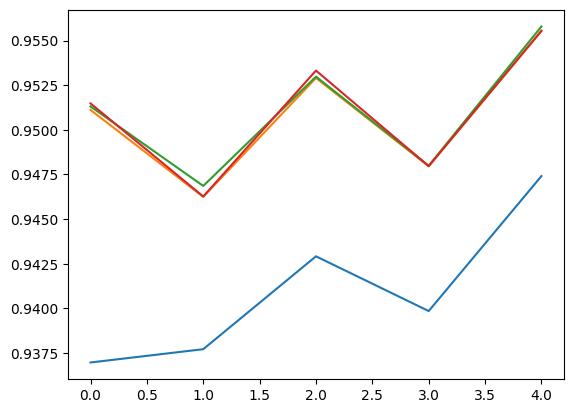

In [467]:

plt.figure()
for i in [0,2,3,4]:
    plt.plot(np.abs(scores[i, :]).T)
plt.show()
    


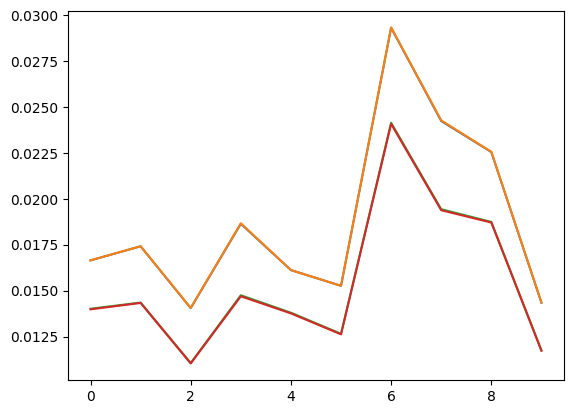

In [374]:
plt.figure()
for i in [0,2,3,4]:
    plt.plot(np.abs(scores[i, :]).T)
plt.show()

# plt.figure()
# for i in [0,2,3,4]:
#     plt.plot(np.abs(scores_wo[i, :]))
# plt.show()

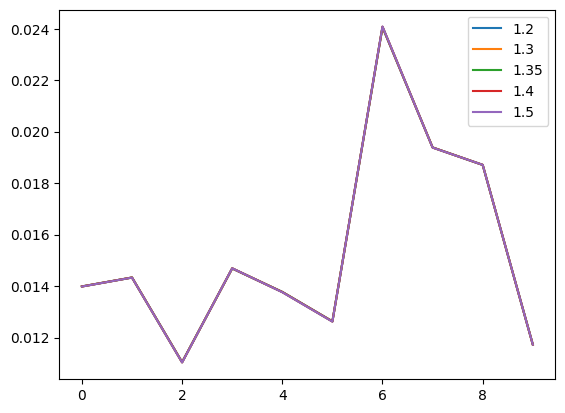

In [362]:
plt.figure()
for i in range(5):
    plt.plot(np.abs(scores[i, 3, :]).T, color = f'C{i}', label = cset.gmt_thresholds[i])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


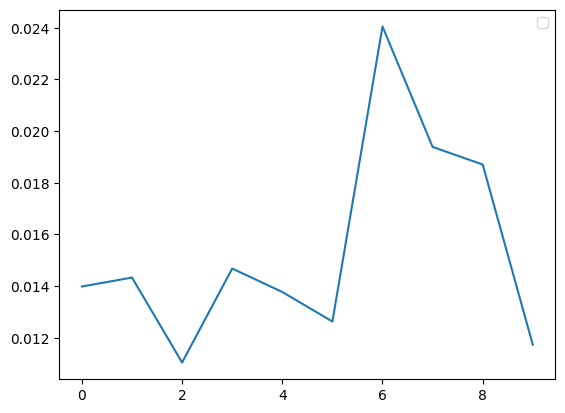

In [365]:
plt.figure()
plt.plot(np.abs(scores[0, 3, :]))
plt.legend()
plt.show()

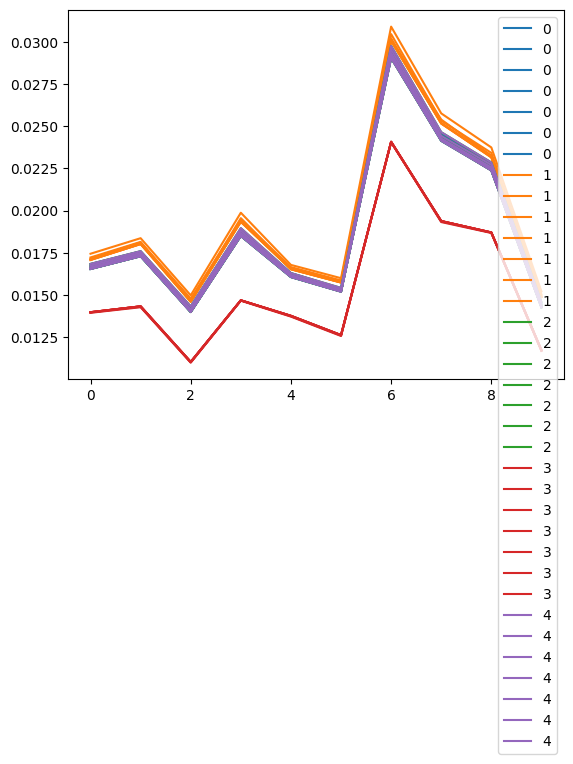

In [361]:
plt.figure()
for i in range(5):
    plt.plot(np.abs(scores[:, i, :]).T, color = f'C{i}', label = i)
plt.legend()
plt.show()

## Step 2: Constructing different models and selecting by BIC

In [193]:
# order of predictors: 
# 1. selected model via forward and backward selection
# 2. basic benchmark model 
# 3. selected model via forward and backward selection + adding term for symmetry 
# 3. reducing the number of predictors in the benchmark model to very basic level
# 4. reducing the number of predictors in the benchmark model
predictor_sets = [
    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_exc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
    ['gmt_max', 'gmt_eoc', 'gmt_ntwr', 'gmt_od', 'tas_soc', 'tas_soc^2', 'gmt_soc'], 
    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc'],
    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max'],
    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc'],
    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max'],
    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc'],
    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_uxc^2', 'gmt_soc', 'gmt_exc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
    # ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_max tas_baseline', 'gmt_max']
]

In [213]:
# training on two extreme scenarios, e.g. Neg and CurPol, and extrapolating everything else or 'ssp119' and 'ModAct' 
from sklearn.metrics import r2_score

training_scores = np.zeros((len(cset.gmt_thresholds), len(predictor_sets)))
testing_scores  = np.zeros((len(cset.gmt_thresholds), len(predictor_sets), cset.n_scenarios-2))

for i_threshold in tqdm(range(len(cset.gmt_thresholds)), total = len(cset.gmt_thresholds)):
    gmt_threshold = cset.gmt_thresholds[i_threshold]
    # loading & preparing glmt data 
    glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'gmt_characteristics_thsld_{int(gmt_threshold*100)}.csv'), index_col = 0)
    # merge datasets into a single regression dataset
    regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
    regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
    #   - add baseline temperature values
    regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
    regression_df                 = regression_df.sort_values(['iso', 'scen_run'])

    y = np.log(regression_df['diff_SSP2'])
    # Define predictor variables (excluding 'iso' and the target variable)
    predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'glmt_cum', 'gmt_cum', 'model_id'])
    # Generate second-order terms
    poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    X_poly     = poly.fit_transform(regression_df[predictors])
    X_poly_std = StandardScaler().fit_transform(X_poly)
    # Extract polynomial feature names
    poly_feature_names = poly.get_feature_names_out(predictors)
    predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)
    
    regression_df.index = predictor_df.index.copy()
    
    for i_predictor in range(len(predictor_sets)):
        sel_predictors = predictor_sets[i_predictor]
        
        scenario = cset.scenarios[i_scenario]

        X_train_vars      = predictor_df[regression_df.scen_run.str.contains(r'Neg|CurPol', regex = True)][sel_predictors].copy()
        n_countries       = int(len(regression_df)/1000)
        X_train_intercept = np.zeros((len(X_train_vars), n_countries))
        for i in range(n_countries):
            # each scenario is encoded using 100 runs/country --> set them all 
            X_train_intercept[i*200:(i+1)*200, i] = 1
        X_train = np.c_[X_train_vars, X_train_intercept, X_model_correction[regression_df.scen_run.str.contains(r'Neg|CurPol', regex = True),:]]
        y_train = np.log(regression_df[regression_df.scen_run.str.contains(r'Neg|CurPol', regex = True)]['diff_SSP2'])
        
        model = sm.OLS(endog = y_train, exog = X_train).fit()
        training_scores[i_threshold, i_predictor] = model.rsquared
        
        test_scenarios = [test_sceanrio for test_sceanrio in cset.scenarios if not test_sceanrio in ['Neg', 'CurPol']]
        
        for i_test in range(len(test_scenarios)):
            test_scenario = test_scenarios[i_test]
            X_test_vars = predictor_df[regression_df.scen_run.str.contains(test_scenario)][sel_predictors].copy()
            X_test_intercept = np.zeros((len(X_test_vars), n_countries))
            for i in range(n_countries):
                # each scenario is encoded using 100 runs/country --> set them all 
                X_test_intercept[i*100:(i+1)*100, i] = 1
            X_test      = np.c_[X_test_vars, X_test_intercept, X_model_correction[regression_df.scen_run.str.contains(test_scenario),:]]
            y_test      = np.log(regression_df[regression_df.scen_run.str.contains(test_scenario)]['diff_SSP2'])   
            
            testing_scores[i_threshold, i_predictor, i_test] = r2_score(y_test, model.predict(X_test))


  0%|          | 0/7 [00:00<?, ?it/s]

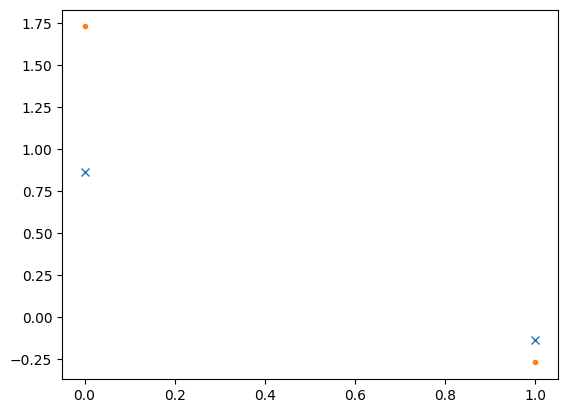

In [217]:
plt.figure()
# plt.plot(test_stds.flatten())
plt.plot(test_means[i_threshold,2:], linestyle=  '', marker = 'x')
plt.plot(test_means[i_threshold,2:]+test_stds[i_threshold,2:], linestyle=  '', marker = '.')
plt.show()

In [215]:
np.shape(X_model_correction[regression_df.scen_run.str.contains(test_scenario),:])

(15700, 25)

In [197]:
from sklearn.metrics import r2_score

training_scores = np.zeros((len(cset.gmt_thresholds), len(predictor_sets), cset.n_scenarios))
testing_scores  = np.zeros((len(cset.gmt_thresholds), len(predictor_sets), cset.n_scenarios, cset.n_scenarios-1))

for i_threshold in tqdm(range(len(cset.gmt_thresholds)), total = len(cset.gmt_thresholds)):
    gmt_threshold = cset.gmt_thresholds[i_threshold]
    # loading & preparing glmt data 
    glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'gmt_characteristics_thsld_{int(gmt_threshold*100)}.csv'), index_col = 0)
    # merge datasets into a single regression dataset
    regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
    regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
    #   - add baseline temperature values
    regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
    regression_df                 = regression_df.sort_values(['iso', 'scen_run'])

    y = np.log(regression_df['diff_SSP2'])
    # Define predictor variables (excluding 'iso' and the target variable)
    predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'glmt_cum', 'gmt_cum', 'model_id'])
    # Generate second-order terms
    poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    X_poly     = poly.fit_transform(regression_df[predictors])
    X_poly_std = StandardScaler().fit_transform(X_poly)
    # Extract polynomial feature names
    poly_feature_names = poly.get_feature_names_out(predictors)
    predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)
    
    regression_df.index = predictor_df.index.copy()
    for i_predictor in range(len(predictor_sets)):
        sel_predictors = predictor_sets[i_predictor]
        
        for i_scenario in range(cset.n_scenarios): 
            scenario = cset.scenarios[i_scenario]

            X_train_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
            n_countries       = int(len(regression_df)/1000)
            X_train_intercept = np.zeros((len(X_train_vars), n_countries))
            for i in range(n_countries):
                # each scenario is encoded using 100 runs/country --> set them all 
                X_train_intercept[i*100:(i+1)*100, i] = 1
            X_train = np.c_[X_train_vars, X_train_intercept, X_model_correction[regression_df.scen_run.str.contains(scenario),:]]
            y_train = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])
            
            model = sm.OLS(endog = y_train, exog = X_train).fit()
            training_scores[i_threshold, i_predictor, i_scenario] = model.rsquared
            
            test_scenarios = [test_sceanrio for test_sceanrio in cset.scenarios if test_sceanrio != scenario]
            
            for i_test in range(len(test_scenarios)):
                test_scenario = test_scenarios[i_test]
                X_test_vars = predictor_df[regression_df.scen_run.str.contains(test_scenario)][sel_predictors].copy()
                X_test      = np.c_[X_test_vars, X_train_intercept, X_model_correction[regression_df.scen_run.str.contains(test_scenario),:]]
                y_test      = np.log(regression_df[regression_df.scen_run.str.contains(test_scenario)]['diff_SSP2'])   
                testing_scores[i_threshold, i_predictor, i_scenario, i_test] = r2_score(y_test, model.predict(X_test))


  0%|          | 0/7 [00:00<?, ?it/s]

In [198]:
# compute mean and standard deviation: 
test_stds  = np.mean(testing_scores.reshape((len(cset.gmt_thresholds), len(predictor_sets), cset.n_scenarios*(cset.n_scenarios-1))), axis = 2)
test_means = np.mean(testing_scores.reshape((len(cset.gmt_thresholds), len(predictor_sets), cset.n_scenarios*(cset.n_scenarios-1))), axis = 2)

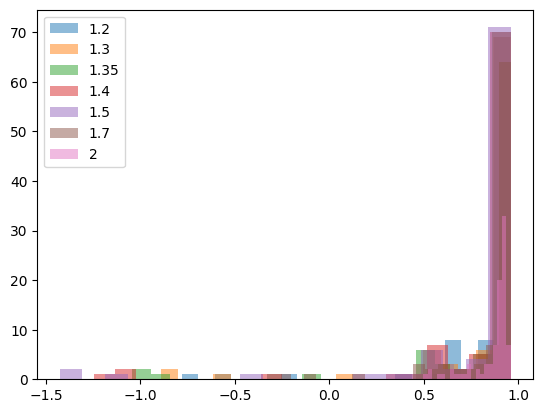

In [199]:
i_predictor = 2
plt.figure()
for i_threshold in range(len(cset.gmt_thresholds)): 
    plt.hist(testing_scores[i_threshold, i_predictor, :, :].flatten(), bins = 20, alpha = 0.5, label = f'{cset.gmt_thresholds[i_threshold]}')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


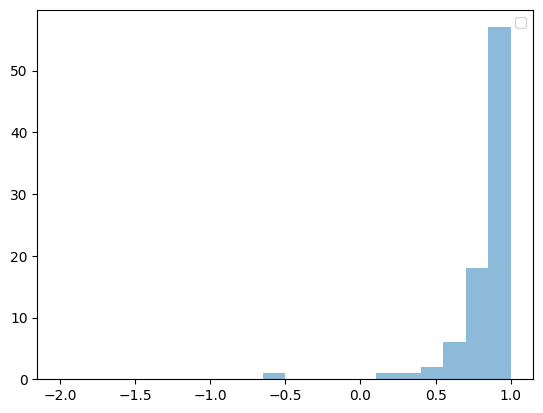

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


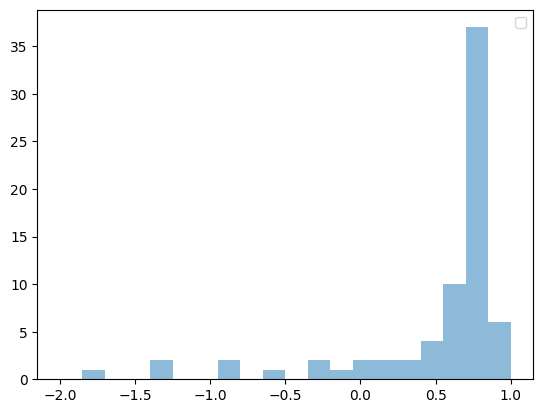

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


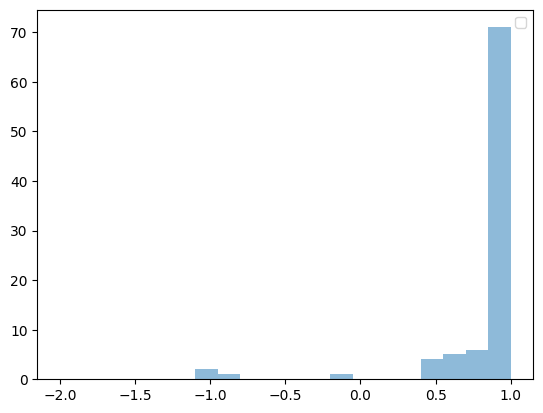

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


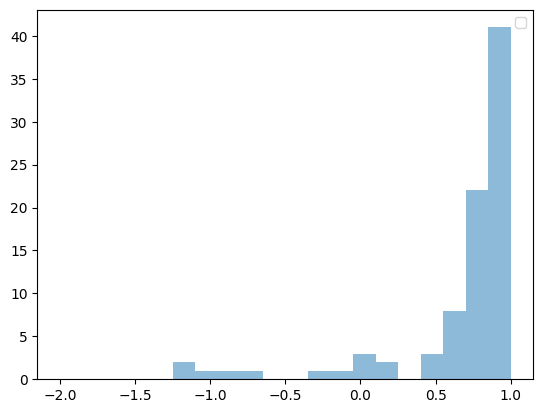

In [200]:
i_threshold = 2

for i_predictor in range(len(predictor_sets)): 
    plt.figure()
    plt.hist(testing_scores[i_threshold, i_predictor, :, :].flatten(), range = (-2,1), bins = 20, alpha = 0.5)
    plt.legend()
    plt.show()

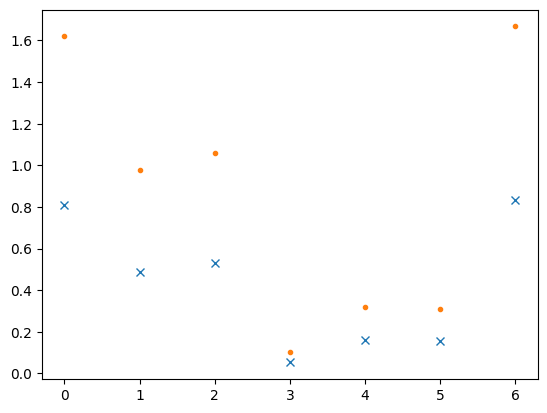

In [181]:
plt.figure()
# plt.plot(test_stds.flatten())
plt.plot(test_means[i_threshold,2:], linestyle=  '', marker = 'x')
plt.plot(test_means[i_threshold,2:]+test_stds[i_threshold,2:], linestyle=  '', marker = '.')
plt.show()

In [167]:
testing_scores.max()

0.9595684875319546

In [165]:
cset.gmt_thresholds

[1.2, 1.3, 1.35, 1.4, 1.5, 1.7, 2]

In [164]:
np.argwhere(test_means > 0.89)

array([[6, 8]])

In [150]:
np.shape(test_means)

(7, 9)

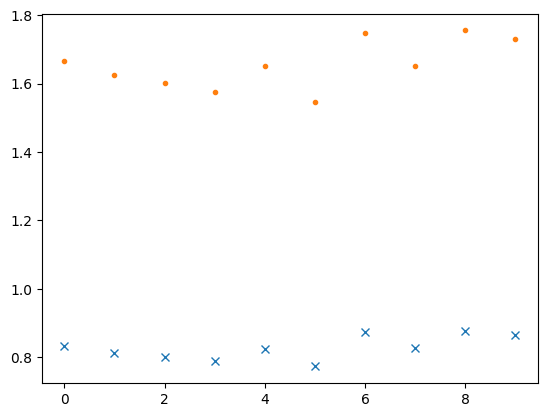

In [201]:
plt.figure()
# plt.plot(test_stds.flatten())
plt.plot(test_means[test_means > 0.75].flatten(), linestyle=  '', marker = 'x')
plt.plot(test_means[test_means > 0.75].flatten()+test_stds[test_means>0.75].flatten(), linestyle=  '', marker = '.')
plt.show()

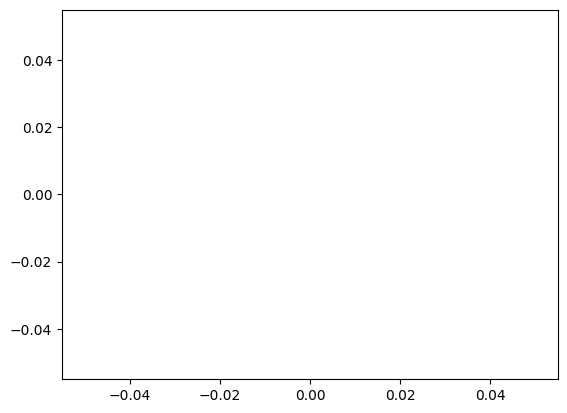

In [202]:
plt.figure()
# plt.plot(test_stds.flatten())
plt.plot(test_means[(test_means < 0.75) & (test_means > 0.6)].flatten(), linestyle=  '', marker = 'x')
plt.plot(test_means[(test_means < 0.75) & (test_means > 0.6)].flatten()+test_stds[(test_means < 0.75) & (test_means > 0.6)].flatten(), linestyle=  '', marker = '.')
plt.show()

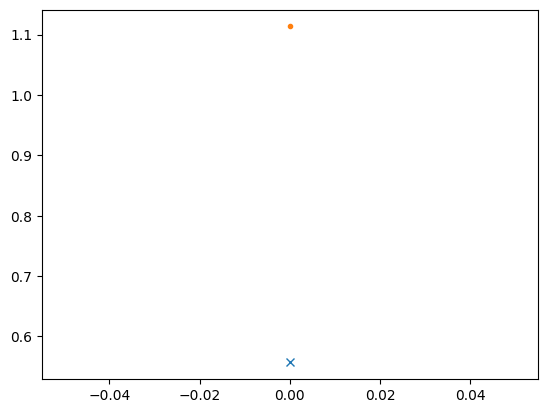

In [203]:
plt.figure()
# plt.plot(test_stds.flatten())
plt.plot(test_means[(test_means < 0.6) & (test_means > 0.5)].flatten(), linestyle=  '', marker = 'x')
plt.plot(test_means[(test_means < 0.6) & (test_means > 0.5)].flatten()+test_stds[(test_means < 0.6) & (test_means > 0.5)].flatten(), linestyle=  '', marker = '.')
plt.show()

In [121]:
# leaving out entire scenarios to select final model
from sklearn.metrics import r2_score

regression_df.index = predictor_df.index.copy()
training_scores = np.zeros((7, cset.n_scenarios))
testing_scores  = np.zeros((7, cset.n_scenarios, cset.n_scenarios-1))

i_predictor =  0
for sel_predictors in [['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_exc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
                    #    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_exc^2', 'gmt_eoc tas_baseline', 'gmt_eoc^2', 'gmt_eoc'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max', 'gmt_soc', 'gmt_soc tas_baseline'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc', 'gmt_soc', 'gmt_soc tas_baseline'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc', 'gmt_soc'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_exc^2', 'gmt_uxc^2', 'gmt_max tas_baseline', 'gmt_max']
                       ]: 
    i_scenario = 0
    for scenario in cset.scenarios: 
        # train on one scenario and test on all others: 
        X_train_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries       = int(len(regression_df)/1000)
        X_train_intercept = np.zeros((len(X_train_vars), n_countries))
        for i in range(n_countries):
            # each scenario is encoded using 100 runs/country --> set them all 
            X_train_intercept[i*100:(i+1)*100, i] = 1
        X_train = np.c_[X_train_vars, X_train_intercept]
        y_train = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])
        
        model = sm.OLS(endog = y_train, exog = X_train).fit()
        training_scores[i_predictor, i_scenario] = model.rsquared
        
        test_scenarios = [test_sceanrio for test_sceanrio in cset.scenarios if test_sceanrio != scenario]
        
        i_test = 0
        for test_scenario in test_scenarios: 
            X_test_vars = predictor_df[regression_df.scen_run.str.contains(test_scenario)][sel_predictors].copy()
            X_test      = np.c_[X_test_vars, X_train_intercept]
            y_test      = np.log(regression_df[regression_df.scen_run.str.contains(test_scenario)]['diff_SSP2'])   
            testing_scores[i_predictor, i_scenario, i_test] = r2_score(y_test, model.predict(X_test))
            # print(r2_score(y_test, model.predict(X_test)))
            i_test += 1
        i_scenario += 1
    i_predictor += 1

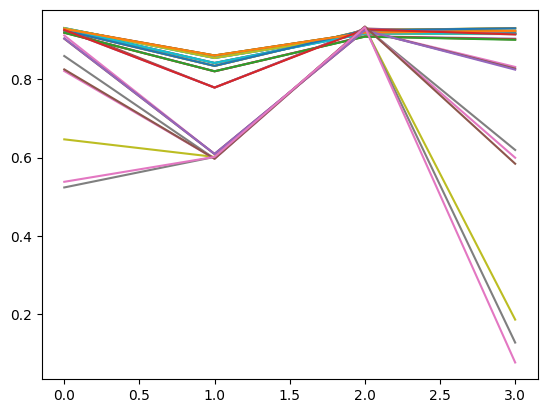

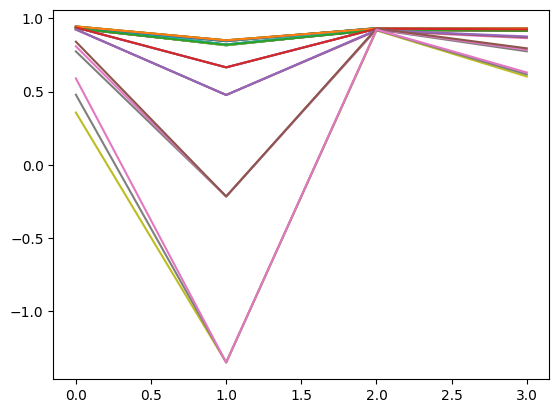

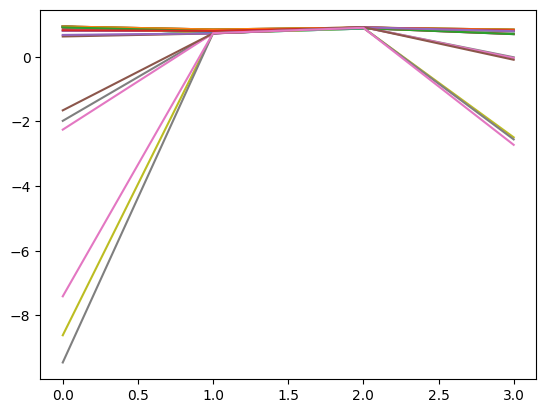

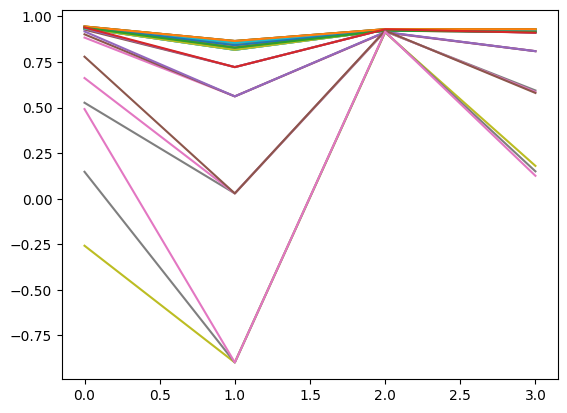

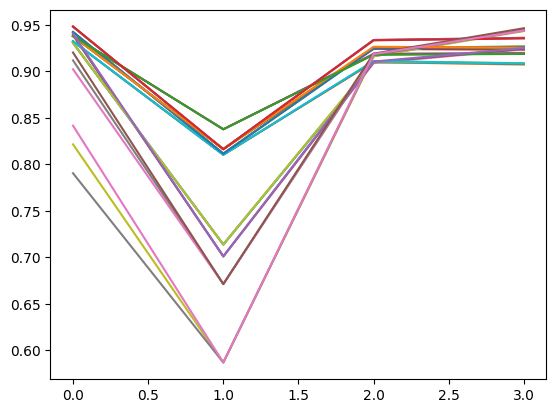

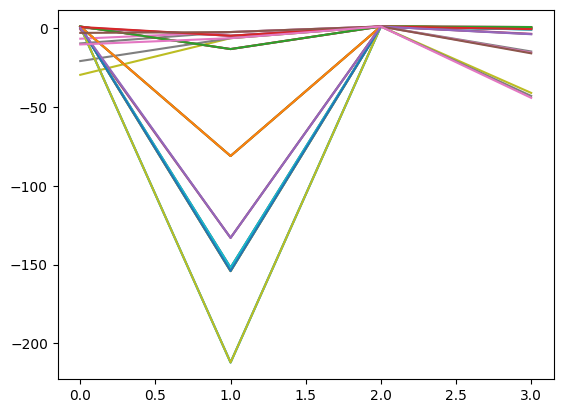

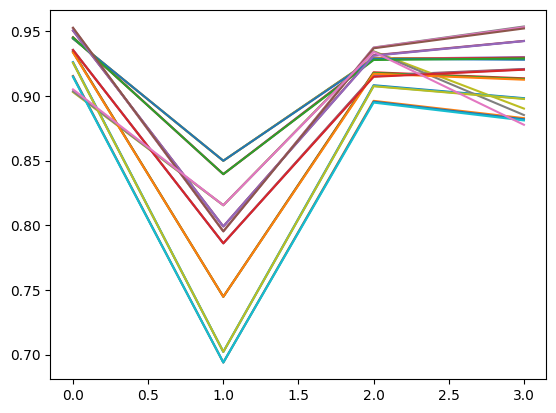

In [204]:
for i in range(7):
    plt.figure()
    # plt.plot(training_scores[1:,:].T)
    plt.plot(testing_scores[1, :, i])
    plt.plot(testing_scores[2, :, i])
    plt.plot(testing_scores[3, :, i])
    plt.show()

In [106]:
# leaving out entire scenarios to select final model
from sklearn.metrics import r2_score

regression_df.index = predictor_df.index.copy()
training_scores = np.zeros((7, cset.n_scenarios))
testing_scores  = np.zeros((7, cset.n_scenarios, cset.n_scenarios-1))
scenario_groups = [['ssp119', 'Ren', 'CurPol'], 
                   ['Neg', 'SP', 'Ref', 'ModAct'], 
                   ['LD', 'GS', 'sso534-over']
                   ]

i_predictor =  0
for sel_predictors in [['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_exc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max'],
                    #    ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_soc tas_baseline', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_exc^2', 'gmt_eoc tas_baseline', 'gmt_eoc^2', 'gmt_eoc'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max', 'gmt_soc', 'gmt_soc tas_baseline'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc', 'gmt_soc', 'gmt_soc tas_baseline'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_eoc tas_baseline', 'gmt_eoc', 'gmt_soc'],
                       ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_exc^2', 'gmt_uxc^2', 'gmt_max tas_baseline', 'gmt_max']
                       ]: 
    i_scenario = 0
    for scenarios in scenario_groups: 
        # train on one scenario and test on all others: 
        X_train_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries       = int(len(regression_df)/1000)
        X_train_intercept = np.zeros((len(X_train_vars), n_countries))
        for i in range(n_countries):
            # each scenario is encoded using 100 runs/country --> set them all 
            X_train_intercept[i*100:(i+1)*100, i] = 1
        X_train = np.c_[X_train_vars, X_train_intercept]
        y_train = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])
        
        model = sm.OLS(endog = y_train, exog = X_train).fit()
        training_scores[i_predictor, i_scenario] = model.rsquared
        
        test_scenarios = [test_sceanrio for test_sceanrio in cset.scenarios if test_sceanrio != scenario]
        
        i_test = 0
        for test_scenario in test_scenarios: 
            X_test_vars = predictor_df[regression_df.scen_run.str.contains(test_scenario)][sel_predictors].copy()
            X_test      = np.c_[X_test_vars, X_train_intercept]
            y_test      = np.log(regression_df[regression_df.scen_run.str.contains(test_scenario)]['diff_SSP2'])   
            testing_scores[i_predictor, i_scenario, i_test] = r2_score(y_test, model.predict(X_test))
            # print(r2_score(y_test, model.predict(X_test)))
            i_test += 1
        i_scenario += 1
    i_predictor += 1

0.9386157770936311
-11.174801192471705


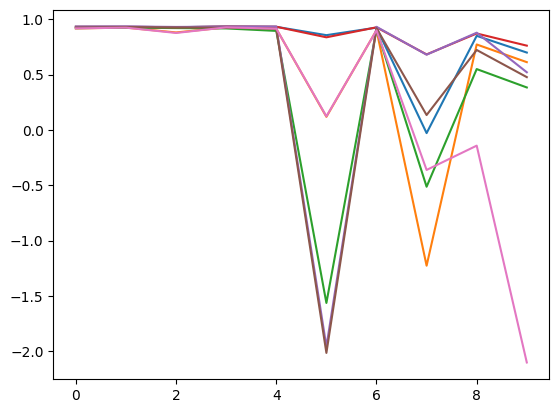

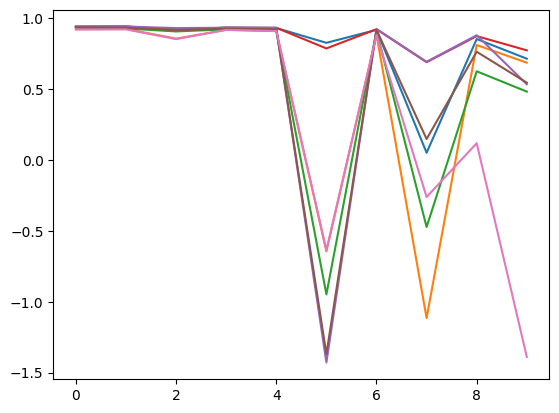

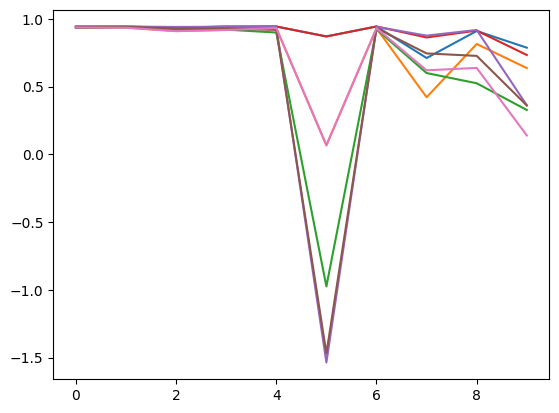

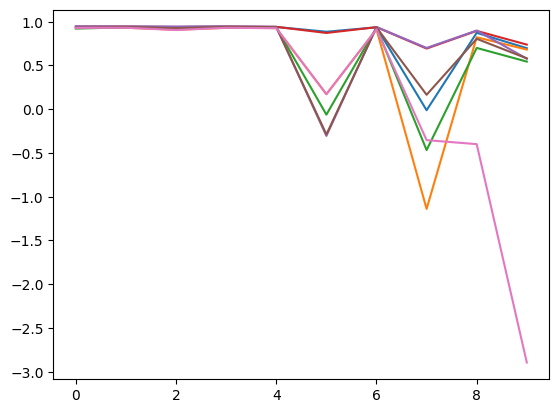

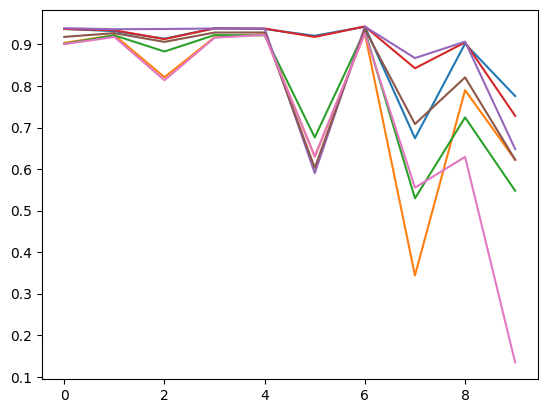

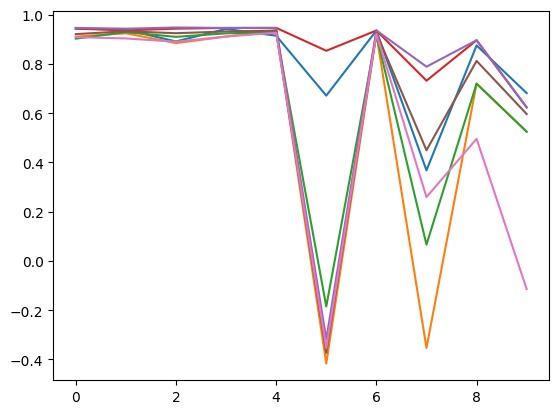

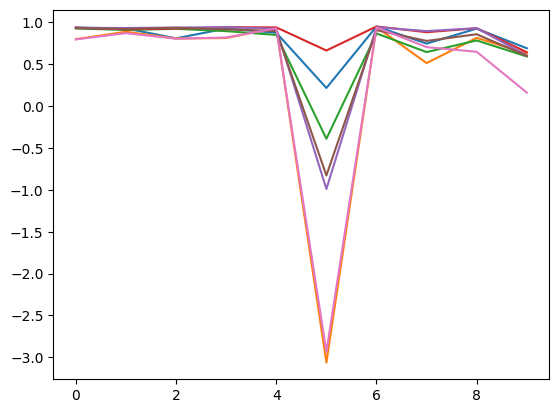

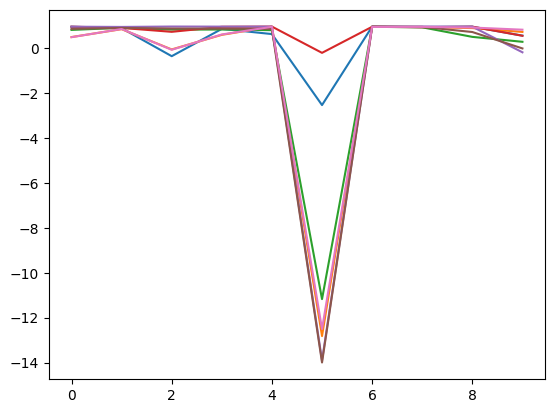

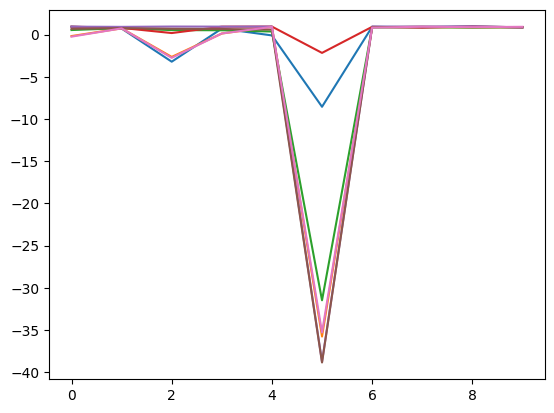

In [89]:
for j in range(9):
    plt.figure()
    # plt.plot(training_scores[1:,:].T)
    plt.plot(testing_scores[:, :, j].T)
    # plt.legend()
    plt.show()



In [ ]:
predictor_sets = [['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_eoc', 'gmt_eoc tas_baseline'],
                  ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_max', 'gmt_max tas_baseline'], 
                  ]

sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_eoc', 'gmt_eoc tas_baseline']

y              = np.log(regression_df['diff_SSP2'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
print(r)

sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_max', 'gmt_max tas_baseline']

y              = np.log(regression_df['diff_SSP2'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
print(r)

In [ ]:
# sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_eoc', 'gmt_eoc tas_baseline', 'gmt_max', 'gmt_max tas_baseline']
sel_predictors = ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_uxc', 'gmt_max tas_baseline', 'gmt_max', 'gmt_soc', 'gmt_soc tas_baseline']
y              = np.log(regression_df['diff_SSP2'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
print(r)



In [377]:
sel_predictors = ['gmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_exc', 'gmt_uxc tas_baseline', 'gmt_soc tas_baseline', 'gmt_uxc', 'gmt_soc', 'gmt_exc^2', 'gmt_uxc^2', 'gmt_max tas_baseline', 'gmt_max^2', 'gmt_max']

y              = np.log(regression_df['diff_SSP2'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
print(r)

result_df                  = pd.DataFrame(X_poly, columns = poly_feature_names)[sel_predictors]
result_df['log_diff_SSP2'] = np.log(regression_df['diff_SSP2'].values)
result_df['iso']           = regression_df['iso'].values
result_df['scen_run']      = regression_df['scen_run'].values
result_df['tas_baseline']  = regression_df['tas_baseline'].values
result_df['model_id']      = regression_df['model_id'].values

cset.path_CHAR_results.mkdir(parents=True, exist_ok=True)
result_df.to_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'))

In [378]:
result_df

gmt_exc tas_baseline   tas_soc^2    tas_soc  gmt_exc  \
0                 799.059937  204.174686  14.288971  58.6091   
1                 316.394965  223.559030  14.951891  23.2068   
2                 841.362637  208.683381  14.445878  61.7119   
3                 316.394965  184.112267  13.568798  23.2068   
4                 413.105743  199.259967  14.115947  30.3003   
...                      ...         ...        ...      ...   
156995            757.032831  466.175227  21.591091  34.7284   
156996            677.535272  464.230555  21.546010  31.0815   
156997            677.535272  511.364517  22.613370  31.0815   
156998           1577.423488  483.468685  21.987921  72.3633   
156999           1202.423197  478.926256  21.884384  55.1604   

        gmt_uxc tas_baseline  gmt_uxc  gmt_max tas_baseline  gmt_max  \
0                  18.014231   1.3213             43.533825   3.1931   
1                 120.703395   8.8533             32.873621   2.4112   
2                  16.986249   1.2459             45.073071   3.3060   
3                 120.703395   8.8533             32.873621   2.4112   
4                  96.016822   7.0426             35.619451   2.6126   
...                      ...      ...                   ...      ...   
156995             80.724824   3.7032             48.510754   2.2254   
156996             64.691904   2.9677             47.032804   2.1576   
156997             64.691904   2.9677             47.032804   2.1576   
156998             40.754788   1.8696             60.035709   2.7541   
156999             25.397627   1.1651             55.032915   2.5246   

         gmt_soc  gmt_soc tas_baseline  log_diff_SSP2  iso        scen_run  \
0       0.127221              1.734494      -0.126496  AFG        CurPol_1   
1      -0.137379             -1.872988      -0.014225  AFG       CurPol_10   
2       0.146321              1.994898      -0.106559  AFG      CurPol_100   
3      -0.137379             -1.872988      -0.122939  AFG       CurPol_11   
4      -0.119379             -1.627581      -0.108812  AFG       CurPol_12   
...          ...                   ...            ...  ...             ...   
156995 -0.068979             -1.503652      -1.099045  ZWE  ssp534-over_95   
156996  0.010021              0.218442      -0.924679  ZWE  ssp534-over_96   
156997  0.010021              0.218442       0.002094  ZWE  ssp534-over_97   
156998  0.027421              0.597739      -0.839979  ZWE  ssp534-over_98   
156999  0.123821              2.699131      -0.668639  ZWE  ssp534-over_99   

        tas_baseline         model_id  
0          13.633718    CNRM-CM6-1-HR  
1          13.633718            NESM3  
2          13.633718       MCM-UA-1-0  
3          13.633718       NorESM2-LM  
4          13.633718        FGOALS-g3  
...              ...              ...  
156995     21.798667            CESM2  
156996     21.798667            CESM2  
156997     21.798667            NESM3  
156998     21.798667    AWI-CM-1-1-MR  
156999     21.798667  HadGEM3-GC31-MM  

[157000 rows x 15 columns]

In [228]:
result_df['log_predictions'] = model.predict(np.c_[predictor_df[sel_predictors], X_intercept])

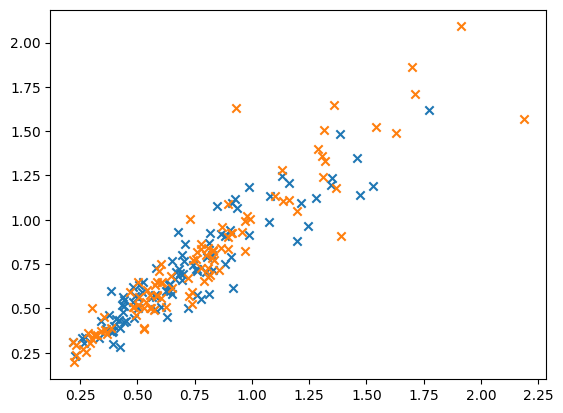

In [229]:
ref_sub_df = result_df[(result_df.iso == 'NGA') & (result_df.scen_run.str.contains('Ref'))]
neg_sub_df = result_df[(result_df.iso == 'NGA') & (result_df.scen_run.str.contains('Neg'))]

plt.figure()
plt.scatter(np.exp(ref_sub_df['log_diff_SSP2']), np.exp(ref_sub_df['log_predictions']), marker = 'x')
plt.scatter(np.exp(neg_sub_df['log_diff_SSP2']), np.exp(neg_sub_df['log_predictions']), marker = 'x')
plt.show()

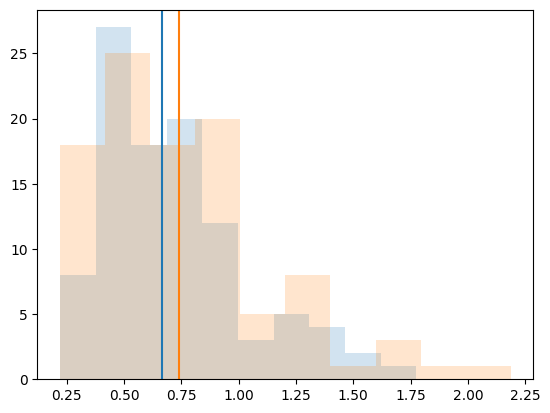

In [16]:
plt.figure()
plt.hist(np.exp(ref_sub_df['log_diff_SSP2']), alpha = .2)
plt.hist(np.exp(neg_sub_df['log_diff_SSP2']), alpha = .2)
plt.axvline(np.quantile(np.exp(ref_sub_df['log_diff_SSP2']), 0.5))
plt.axvline(np.quantile(np.exp(neg_sub_df['log_diff_SSP2']), 0.5), color = 'C1')
plt.show()

In [17]:
np.quantile(np.exp(ref_sub_df['log_diff_SSP2']), 0.95)

1.3498469122525378

In [148]:
# leaving out entire scenarios works best  
regression_df.index = predictor_df.index.copy()
training_scores = np.zeros((5, cset.n_scenarios))
testing_scores  = np.zeros((5, cset.n_scenarios, cset.n_scenarios-1))

i_predictor =  0
for sel_predictors in [['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc'],
                       ['glmt_exc tas_baseline', 'tas_baseline tas_soc', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_eoc', 'glmt_eoc tas_baseline'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_eoc', 'glmt_eoc tas_baseline'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_exc^2']
                       ]: 
    i_scenario = 0
    for scenario in cset.scenarios: 
        X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries       = int(len(regression_df)/1000)
        X_train_intercept = np.zeros((len(X_train_vars), n_countries))
        for i in range(n_countries):
            X_train_intercept[i*900:(i+1)*900, i] = 1
        X_train = np.c_[X_train_vars, X_train_intercept]
        y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

        X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries      = int(len(regression_df)/1000)
        X_test_intercept = np.zeros((len(X_test_vars), n_countries))
        for i in range(n_countries):
            X_test_intercept[i*100:(i+1)*100, i] = 1
        X_test = np.c_[X_test_vars, X_test_intercept]
        y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

        model = sm.OLS(endog = y_test, exog = X_test).fit()

        from sklearn.metrics import r2_score

        training_scores[i_predictor, i_scenario] = model.rsquared
    
        testing_scores[i_predictor, i_scenario, :] = [r2_score(y_train[j*900:(j+1)*900], model.predict(X_train[j*900:(j+1)*900, :])) for j in range(9)]
        i_scenario += 1
    i_predictor += 1

# plt.figure()
# plt.plot(training_scores[1:,:].T)
# plt.plot(testing_scores[1:,:].T)
# plt.show()

In [154]:
# leaving out entire scenarios works best  
regression_df.index = predictor_df.index.copy()
training_scores = np.zeros((4, cset.n_scenarios))
testing_scores  = np.zeros((4, cset.n_scenarios, cset.n_scenarios-1))

i_predictor =  0
for sel_predictors in [['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_eoc', 'glmt_eoc tas_baseline'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_exc^2']
                       ]: 
    i_scenario = 0
    for scenario in cset.scenarios: 
        X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries       = int(len(regression_df)/1000)
        X_train_intercept = np.zeros((len(X_train_vars), n_countries))
        for i in range(n_countries):
            X_train_intercept[i*900:(i+1)*900, i] = 1
        X_train = np.c_[X_train_vars, X_train_intercept]
        y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

        X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries      = int(len(regression_df)/1000)
        X_test_intercept = np.zeros((len(X_test_vars), n_countries))
        for i in range(n_countries):
            X_test_intercept[i*100:(i+1)*100, i] = 1
        X_test = np.c_[X_test_vars, X_test_intercept]
        y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

        model = sm.OLS(endog = y_test, exog = X_test).fit()

        from sklearn.metrics import r2_score

        training_scores[i_predictor, i_scenario] = model.rsquared
    
        testing_scores[i_predictor, i_scenario, :] = [r2_score(y_train[j*900:(j+1)*900], model.predict(X_train[j*900:(j+1)*900, :])) for j in range(9)]
        i_scenario += 1
    i_predictor += 1

In [ ]:
for j in range(9):
    plt.figure()
    # plt.plot(training_scores[1:,:].T)
    plt.plot(testing_scores[1:3, :, j].T)
    plt.show()

for j in range(9):
    print(np.mean(testing_scores[1:4, :, j], axis = 1))

In [143]:
for j in range(9):
    print(np.mean(testing_scores[1:4, :, j], axis = 1))

[0.39797635 0.42513843 0.3008909 ]
[0.92618223 0.92472801 0.9229228 ]
[0.7370911  0.74343544 0.69831651]
[0.92791179 0.92605626 0.92638707]
[0.90549415 0.90141076 0.89523667]
[0.94906285 0.94817027 0.93623131]
[0.90259953 0.89480544 0.87568798]
[0.95564824 0.95450903 0.9503815 ]
[0.95189267 0.95122175 0.94157543]


In [140]:
np.sort(cset.scenarios)

array(['CurPol', 'GS', 'LD', 'ModAct', 'Neg', 'Ref', 'Ren', 'SP',
       'ssp119', 'ssp534-over'], dtype='<U11')

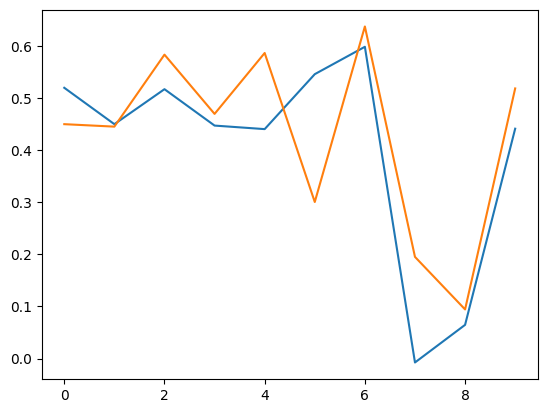

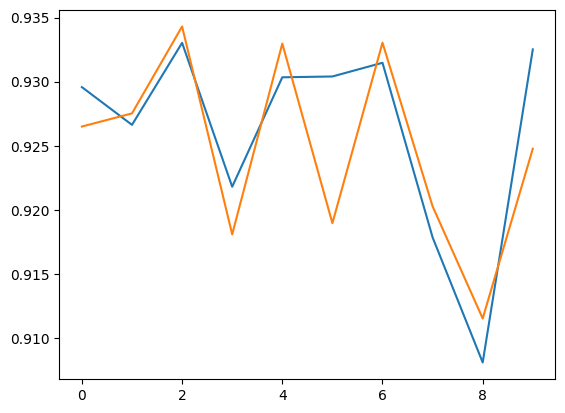

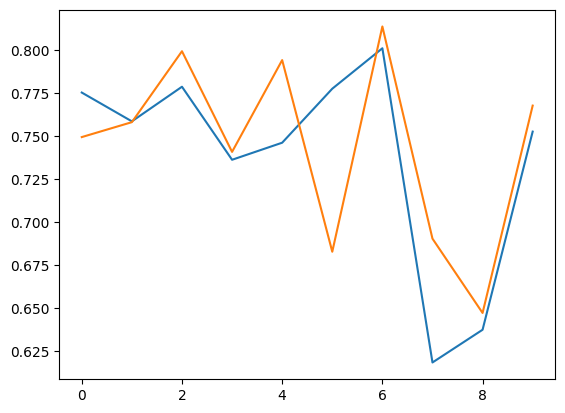

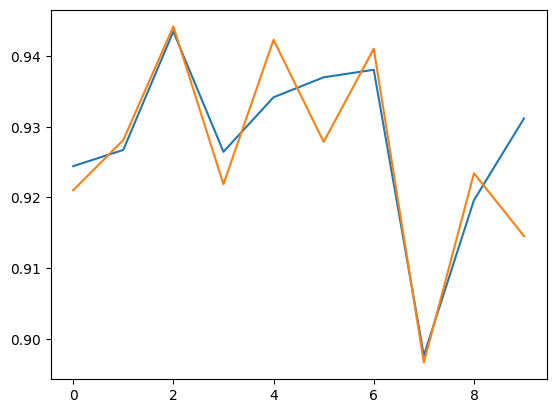

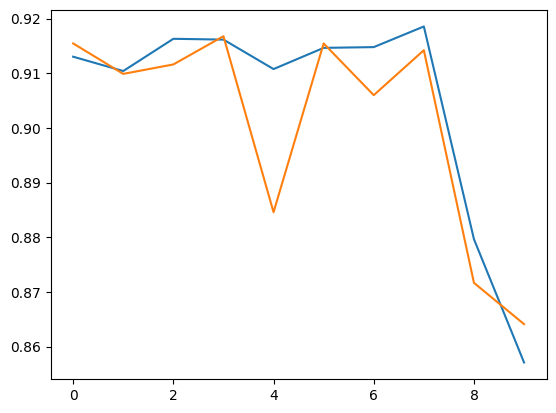

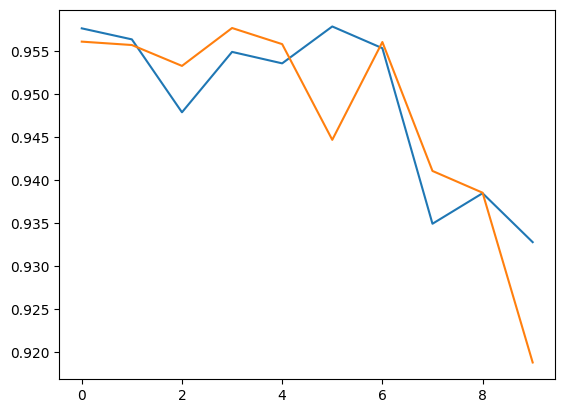

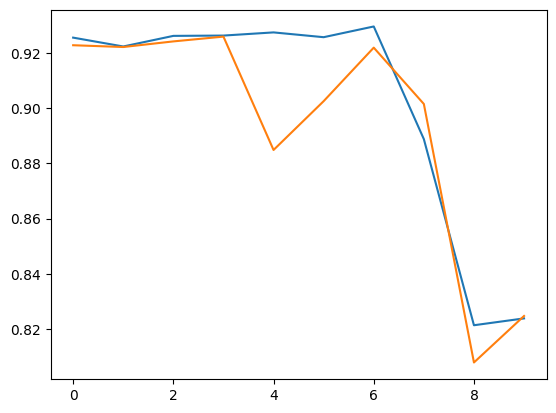

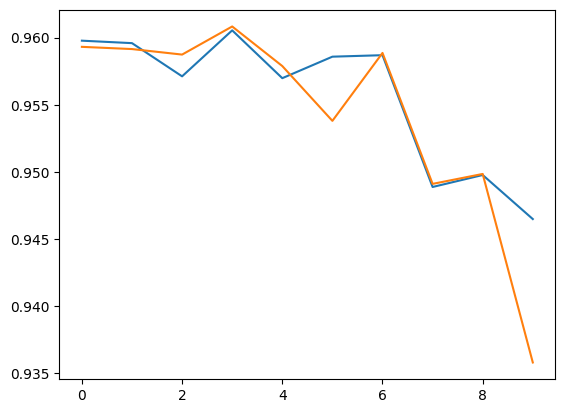

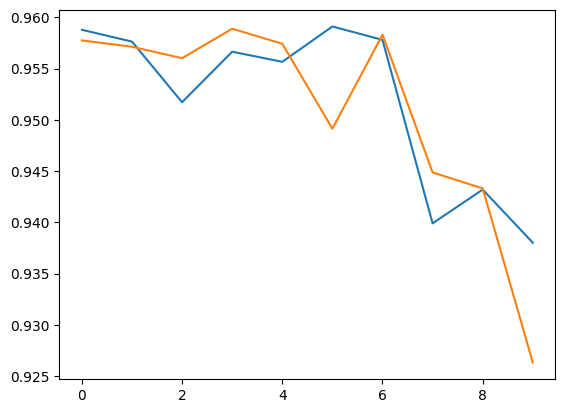

In [155]:
for j in range(9):
    plt.figure()
    # plt.plot(training_scores[1:,:].T)
    plt.plot(testing_scores[1:3, :, j].T)
    plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (9,) and (9, 10, 3)

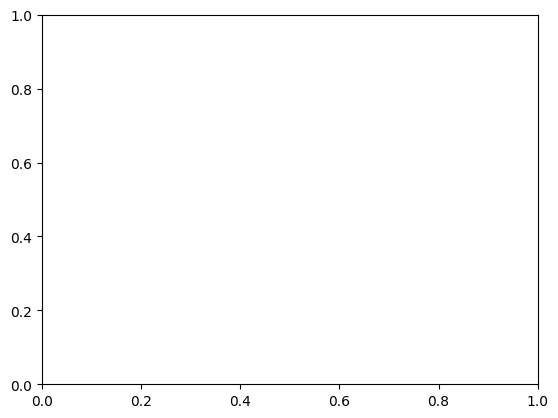

In [156]:
plt.figure()
# plt.plot(training_scores[1:,:].T)
plt.plot(testing_scores[1:,:].T)
plt.show()

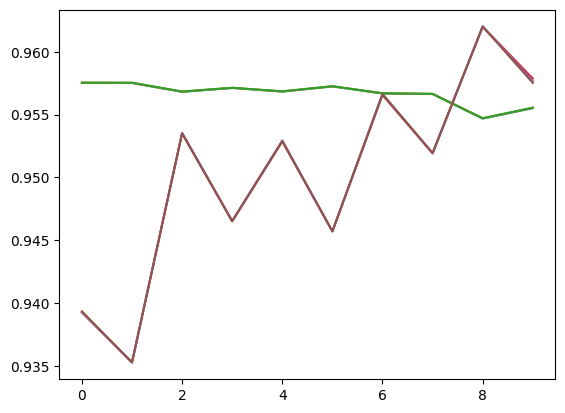

In [88]:
# leaving out entire scenarios works best  
regression_df.index = predictor_df.index.copy()
training_scores = np.zeros((4, cset.n_scenarios))
testing_scores  = np.zeros((4, cset.n_scenarios))

i_predictor =  0
for sel_predictors in [['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_eoc', 'glmt_eoc tas_baseline'],
                       ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc',  'glmt_max', 'glmt_max tas_baseline']
                       ]: 
    i_scenario = 0
    for scenario in cset.scenarios: 
        X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries       = int(len(regression_df)/1000)
        X_train_intercept = np.zeros((len(X_train_vars), n_countries))
        for i in range(n_countries):
            X_train_intercept[i*900:(i+1)*900, i] = 1
        X_train = np.c_[X_train_vars, X_train_intercept]
        y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

        X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
        n_countries      = int(len(regression_df)/1000)
        X_test_intercept = np.zeros((len(X_test_vars), n_countries))
        for i in range(n_countries):
            X_test_intercept[i*100:(i+1)*100, i] = 1
        X_test = np.c_[X_test_vars, X_test_intercept]
        y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

        model = sm.OLS(endog = y_train, exog = X_train).fit()

        from sklearn.metrics import r2_score

        y_pred = model.predict(X_test)
        
        training_scores[i_predictor, i_scenario] = model.rsquared
        testing_scores[i_predictor, i_scenario] = r2_score(y_test, y_pred)
        i_scenario += 1
    i_predictor += 1

plt.figure()
plt.plot(training_scores[1:,:].T)
plt.plot(testing_scores[1:,:].T)
plt.show()

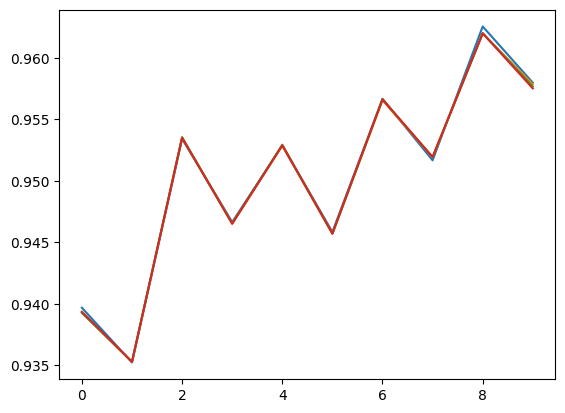

In [90]:
plt.figure()
# plt.plot(training_scores[1:,:].T)
plt.plot(testing_scores[:,:].T)
plt.show()

In [91]:
print(np.mean(testing_scores, axis = 1))

[0.95026277 0.95015301 0.95015582 0.95014006]


In [79]:
cset.scenarios

['ssp119',
 'SP',
 'Neg',
 'LD',
 'Ren',
 'Ref',
 'GS',
 'ssp534-over',
 'ModAct',
 'CurPol']

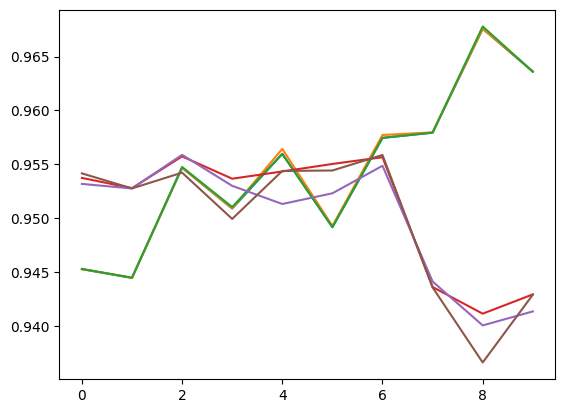

In [84]:
print(np.mean(testing_scores[:,:], axis = 1))

[0.91435297 0.95085933 0.94987904 0.95033943]


In [44]:
regression_df.index = predictor_df.index.copy()

In [57]:
# create hold-out datasets: 
r_train_1  = []
r_test_1   = []
for scenario in cset.scenarios: 
    sel_predictors    = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline']
    X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries       = int(len(regression_df)/1000)
    X_train_intercept = np.zeros((len(X_train_vars), n_countries))
    for i in range(n_countries):
        X_train_intercept[i*900:(i+1)*900, i] = 1
    X_train = np.c_[X_train_vars, X_train_intercept]
    y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries      = int(len(regression_df)/1000)
    X_test_intercept = np.zeros((len(X_test_vars), n_countries))
    for i in range(n_countries):
        X_test_intercept[i*100:(i+1)*100, i] = 1
    X_test = np.c_[X_test_vars, X_test_intercept]
    y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    model = sm.OLS(endog = y_train, exog = X_train).fit()

    from sklearn.metrics import r2_score

    y_pred = model.predict(X_test)

    print(scenario, model.rsquared, r2_score(y_test, y_pred))
    
    r_train_1.append(model.rsquared)
    r_test_1.append(r2_score(y_test, y_pred))

ssp119 0.9575414034689087 0.9392789280983835
SP 0.9575320636821583 0.9352838191574124
Neg 0.9568283298717616 0.9535531036895141
LD 0.9571324404233135 0.9465436704035928
Ren 0.9568457911061952 0.9529438555713862
Ref 0.9572567104322802 0.9457011929144399
GS 0.9566946654489876 0.956633354827714
ssp534-over 0.956646377589211 0.9519334047518563
ModAct 0.9547094466317039 0.962006838832683
CurPol 0.9555491933590343 0.9576800479614932


In [58]:
# create hold-out datasets: 
r_train_2  = []
r_test_2   = []
for scenario in cset.scenarios: 
    sel_predictors    = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']
    X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries       = int(len(regression_df)/1000)
    X_train_intercept = np.zeros((len(X_train_vars), n_countries))
    for i in range(n_countries):
        X_train_intercept[i*900:(i+1)*900, i] = 1
    X_train = np.c_[X_train_vars, X_train_intercept]
    y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries      = int(len(regression_df)/1000)
    X_test_intercept = np.zeros((len(X_test_vars), n_countries))
    for i in range(n_countries):
        X_test_intercept[i*100:(i+1)*100, i] = 1
    X_test = np.c_[X_test_vars, X_test_intercept]
    y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    model = sm.OLS(endog = y_train, exog = X_train).fit()

    from sklearn.metrics import r2_score

    y_pred = model.predict(X_test)

    print(scenario, model.rsquared, r2_score(y_test, y_pred))
    
    r_train_2.append(model.rsquared)
    r_test_2.append(r2_score(y_test, y_pred))

ssp119 0.9577046883250754 0.9396121671251942
SP 0.9577174920440485 0.9352364973012027
Neg 0.9570210440495837 0.9534257211184444
LD 0.957308111475903 0.9466637719501918
Ren 0.9570339835096995 0.9528974723308797
Ref 0.9574302952942886 0.9458573058725861
GS 0.9568790067270075 0.9566834641692797
ssp534-over 0.9569022451503679 0.9515497024758468
ModAct 0.9548117751770637 0.9625686352212127
CurPol 0.9556637591834297 0.9579349958011334


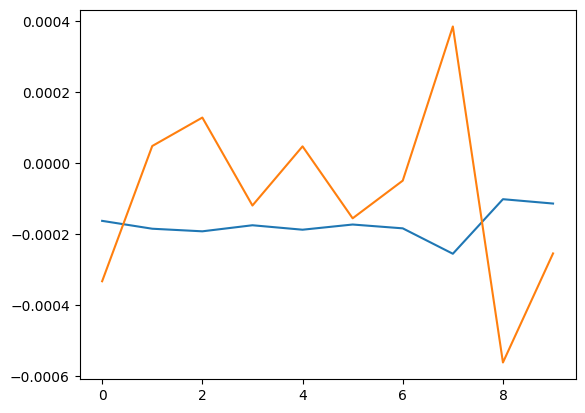

In [62]:
plt.figure()
plt.plot(np.array(r_train_1)-np.array(r_train_2), color = 'C0')
plt.plot(np.array(r_test_1)-np.array(r_test_2), color = 'C1')
plt.show()

In [65]:
# create hold-out datasets: 
r_train_1  = []
r_test_1   = []
for scenario in cset.scenarios: 
    sel_predictors    = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline']
    X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries       = int(len(regression_df)/1000)
    X_train_intercept = np.zeros((len(X_train_vars), n_countries))
    for i in range(n_countries):
        X_train_intercept[i*900:(i+1)*900, i] = 1
    X_train = np.c_[X_train_vars, X_train_intercept]
    y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries      = int(len(regression_df)/1000)
    X_test_intercept = np.zeros((len(X_test_vars), n_countries))
    for i in range(n_countries):
        X_test_intercept[i*100:(i+1)*100, i] = 1
    X_test = np.c_[X_test_vars, X_test_intercept]
    y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    model = sm.OLS(endog = y_test, exog = X_test).fit()

    from sklearn.metrics import r2_score

    y_pred = model.predict(X_train)

    print(scenario, model.rsquared, r2_score(y_train, y_pred))
    
    r_train_1.append(model.rsquared)
    r_test_1.append(r2_score(y_train, y_pred))
    
r_train_2  = []
r_test_2   = []
for scenario in cset.scenarios: 
    sel_predictors    = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']
    X_train_vars      = predictor_df[~regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries       = int(len(regression_df)/1000)
    X_train_intercept = np.zeros((len(X_train_vars), n_countries))
    for i in range(n_countries):
        X_train_intercept[i*900:(i+1)*900, i] = 1
    X_train = np.c_[X_train_vars, X_train_intercept]
    y_train = np.log(regression_df[~regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    X_test_vars      = predictor_df[regression_df.scen_run.str.contains(scenario)][sel_predictors].copy()
    n_countries      = int(len(regression_df)/1000)
    X_test_intercept = np.zeros((len(X_test_vars), n_countries))
    for i in range(n_countries):
        X_test_intercept[i*100:(i+1)*100, i] = 1
    X_test = np.c_[X_test_vars, X_test_intercept]
    y_test = np.log(regression_df[regression_df.scen_run.str.contains(scenario)]['diff_SSP2'])

    model = sm.OLS(endog = y_test, exog = X_test).fit()

    from sklearn.metrics import r2_score

    y_pred = model.predict(X_train)

    print(scenario, model.rsquared, r2_score(y_train, y_pred))
    
    r_train_2.append(model.rsquared)
    r_test_2.append(r2_score(y_train, y_pred))

ssp119 0.9452696445817017 0.9531790434462316
SP 0.9444581289077437 0.9527586581749985
Neg 0.9546954000728453 0.9558800103919072
LD 0.9509123613438201 0.9530003245155294
Ren 0.956432452664538 0.9513147022324083
Ref 0.9492737126186973 0.9523083931626714
GS 0.9577241399180153 0.954864766673903
ssp534-over 0.9579685473870474 0.9441128714664813
ModAct 0.9675967255736336 0.9400365409733072
CurPol 0.9636384736962046 0.9413351070371379
ssp119 0.9454427990439257 0.9408070833080481
SP 0.9447365061391435 0.8742381550948229
Neg 0.9549021099665271 0.9423273042005709
LD 0.9511391074616243 0.9384431939524487
Ren 0.9565152951615221 0.9349380507943255
Ref 0.9499099942431712 0.8663115481139512
GS 0.9577869091107707 0.9529975396360004
ssp534-over 0.958207114361337 0.6912555470562505
ModAct 0.9676684136688124 0.9159961312000567
CurPol 0.9640146670890066 0.8407347280846863


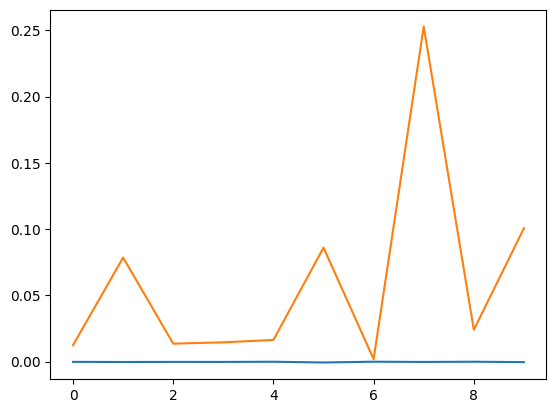

In [66]:
plt.figure()
plt.plot(np.array(r_train_1)-np.array(r_train_2), color = 'C0')
plt.plot(np.array(r_test_1)-np.array(r_test_2), color = 'C1')
plt.show()

In [53]:
# create hold-out datasets: 
sel_predictors    = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']
X_train_vars      = predictor_df[~regression_df.scen_run.str.contains('ssp534-over')][sel_predictors].copy()
n_countries       = int(len(regression_df)/1000)
X_train_intercept = np.zeros((len(X_train_vars), n_countries))
for i in range(n_countries):
    X_train_intercept[i*900:(i+1)*900, i] = 1
X_train = np.c_[X_train_vars, X_train_intercept]
y_train = np.log(regression_df[~regression_df.scen_run.str.contains('ssp534-over')]['diff_SSP2'])

X_test_vars      = predictor_df[regression_df.scen_run.str.contains('ssp534-over')][sel_predictors].copy()
n_countries      = int(len(regression_df)/1000)
X_test_intercept = np.zeros((len(X_test_vars), n_countries))
for i in range(n_countries):
    X_test_intercept[i*100:(i+1)*100, i] = 1
X_test = np.c_[X_test_vars, X_test_intercept]
y_test = np.log(regression_df[regression_df.scen_run.str.contains('ssp534-over')]['diff_SSP2'])

model = sm.OLS(endog = y_train, exog = X_train).fit()
print(model.rsquared)

from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

print(r2_score(y_test, y_pred))


0.9569022451503679
0.9515497024758468


0.9519334047518563

In [22]:
regression_df

iso         scen_run  diff_SSP2  glmt_ntwr  glmt_max  glmt_eoc  \
0       AFG         CurPol_1   0.881178   0.013841  3.844392  3.780049   
115395  AFG            SP_36   0.966106   0.024405  2.279422  1.940994   
81954   AFG           Ref_23   0.962054   0.006256  2.404840  1.968765   
14758   AFG        CurPol_95   0.826685   0.043484  4.010427  3.931034   
148679  AFG   ssp534-over_48   0.836348   0.017073  3.717889  2.599654   
...     ...              ...        ...        ...       ...       ...   
102991  ZWE           Ren_56   0.942378   0.019906  2.146840  1.692662   
102834  ZWE           Ren_55   1.014164   0.036956  2.557047  2.004645   
102677  ZWE           Ren_54   0.224374   0.045055  2.688275  2.309947   
104718  ZWE           Ren_67   0.413892   0.036734  2.728564  2.570220   
156999  ZWE  ssp534-over_100   0.515489   0.038686  3.683225  3.082541   

        glmt_soc    glmt_cum    glmt_od   glmt_exc   glmt_uxc    tas_soc  \
0       1.552812  226.505158   0.330604  59.569518   5.064361  14.288971   
115395  1.576175  161.750249   5.601327   3.796194  14.045944  13.640749   
81954   1.574615  170.980421   8.401674   6.942196   7.961775  13.715057   
14758   1.506401  232.886864   0.468755  66.215034   5.328171  13.123644   
148679  1.603373  239.940247  32.427893  72.372038   4.431791  13.661990   
...          ...         ...        ...        ...        ...        ...   
102991  1.527563  150.137732   9.043639   0.936554  22.798822  22.047561   
102834  1.548677  180.851478  15.957833  16.222601   7.371123  22.484904   
102677  1.497112  192.495778   6.688507  24.918434   4.422656  20.025802   
104718  1.706700  196.079585   0.992005  26.913460   2.833874  21.551821   
156999  1.578746  246.295704  10.911133  77.467423   3.171719  22.139572   

        tas_baseline  
0          13.633718  
115395     13.633718  
81954      13.633718  
14758      13.633718  
148679     13.633718  
...              ...  
102991     21.798667  
102834     21.798667  
102677     21.798667  
104718     21.798667  
156999     21.798667  

[157000 rows x 13 columns]

In [265]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

for k in range(5,12,1):
    cvs = np.zeros((5, k))
    i_pred = 0
    for sel_predictors in [['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline', 'glmt_eoc', 'glmt_eoc tas_baseline'], 
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']
                        ]:
        lm_cv  = LinearRegression()
        rand_numb = np.random.randint(100)
        cv     = KFold(n_splits = 5, shuffle = True, random_state = rand_numb) 
        print(rand_numb)
        X = np.c_[predictor_df[sel_predictors], X_intercept]
        scores = cross_val_score(lm_cv, X, y, cv=k, scoring='neg_mean_squared_error')
        cvs[i_pred, :] = scores
        i_pred += 1
    
    plt.figure()
    plt.scatter(np.arange(5), np.mean(cvs, axis = 1), marker = 'x')
    plt.scatter(np.arange(5), np.mean(cvs, axis = 1) + np.std(cvs, axis = 1), s = 5)
    plt.scatter(np.arange(5), np.mean(cvs, axis = 1) - np.std(cvs, axis = 1), s = 5)
    plt.axhline(np.mean(cvs[1,:]))
    plt.show()

NameError: name 'kFold' is not defined

In [279]:
from sklearn.model_selection import KFold

k = 5
cvs = np.zeros((5, 5, k))
i_pred = 0
for sel_predictors in [['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2'],
                    ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline'],
                    ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc^2', 'glmt_eoc',  'glmt_eoc tas_baseline'],
                    ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc', 'glmt_soc', 'glmt_soc tas_baseline'],
                    ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']
                    ]:
    lm_cv  = LinearRegression()
    for i in range(5):
        rand_numb = np.random.randint(100)
        cv     = KFold(n_splits = k, shuffle = True, random_state = rand_numb) 
        print(rand_numb)
        X = np.c_[predictor_df[sel_predictors], X_intercept]
        scores = cross_val_score(lm_cv, X, y2, cv=cv, scoring='neg_mean_squared_error')
        cvs[i_pred, i, :] = scores
    i_pred += 1

42
70
79
7
10
40
96
26
69
16
36
92
83
43
65
19
57
62
4
51
57
7
23
19
1


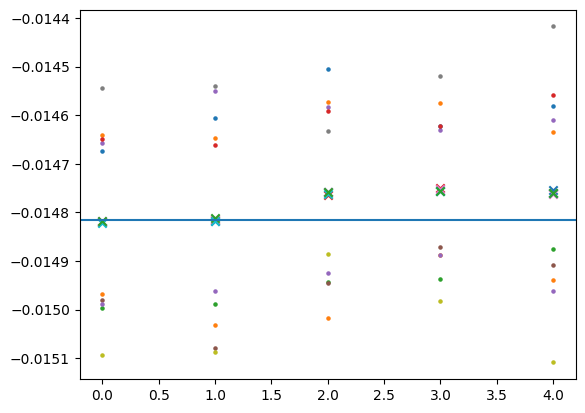

In [281]:
plt.figure()
for i in range(5):
    plt.scatter(np.arange(5), np.mean(cvs[:, i, :], axis = 1), marker = 'x')
    plt.scatter(np.arange(5), np.mean(cvs[:, i, :], axis = 1) + np.std(cvs[:, i, :], axis = 1), s = 5)
    plt.scatter(np.arange(5), np.mean(cvs[:, i, :], axis = 1) - np.std(cvs[:, i, :], axis = 1), s = 5)
plt.axhline(np.mean(cvs[1,:]))
plt.show()

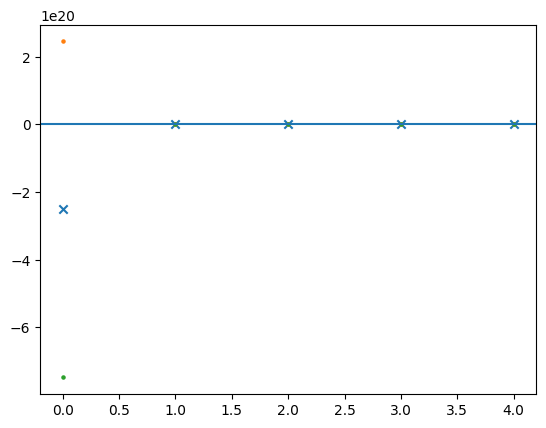

In [260]:
plt.figure()
plt.scatter(np.arange(5), np.mean(cvs, axis = 1), marker = 'x')
plt.scatter(np.arange(5), np.mean(cvs, axis = 1) + np.std(cvs, axis = 1), s = 5)
plt.scatter(np.arange(5), np.mean(cvs, axis = 1) - np.std(cvs, axis = 1), s = 5)
plt.axhline(np.mean(cvs[1,:]))
plt.show()

In [150]:
def fit_model_and_calculate_bic(X_, y_):
    model = sm.OLS(endog = y_, exog = X_).fit()
    return model.bic, model.rsquared, model

#### combine forward and backward selection to get best model 

In [276]:
best_rsquared = 0
threshold_r   = 0
threshold_in  = 20
threshold_out = 20
included = []
best_bic = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _      = fit_model_and_calculate_bic(X, y2)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y2)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break
    
# this step selects ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc', 'glmt_soc tas_baseline']
# as predictors
# all of them have statistic significance 
# glmt_max, glmt_ntwr, glmt_od are never chosen 

139890.82546997617
['glmt_exc tas_baseline']
81447.87386345374
['glmt_exc tas_baseline', 'tas_soc^2']
-80845.60105050972
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc']
-181192.71024482057
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc']
-203700.1058041897
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline']
-214129.15924696485
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc']
-214569.46572484635
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2']
-214728.54498334602
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_max^2']
-214828.31518721103
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_max^2', 'glmt_max']
-214858.88301258069
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', '

In [206]:
def llf_(y, pr):
    # return maximized log likelihood
    nobs = len(y)
    nobs2 = nobs / 2.0
    resid = y - pr
    ssr = np.sum((resid)**2)
    llf = -nobs2*(1+np.log(2 * np.pi)) - nobs2*np.log(ssr / nobs) 
    return llf

def bic_func(y, pr, p):
    # return aic metric
    llf = llf_(y, pr)
    return -p*np.log(len(y)) - 2*llf

In [209]:
for sel_predictors in [['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2'],
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline'],
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2'],
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline'], 
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline', 'glmt_exc^2', 'glmt_uxc^2']
                       ]:
    X = np.c_[predictor_df[sel_predictors], X_intercept]
    bic, rsquare, model      = fit_model_and_calculate_bic(X, y2)
    print(bic, bic_func(y2, model.predict(X),  np.shape(X)[1]-np.shape(X_intercept)[1]))

-214129.15924696485 -216151.07543021668
-214160.64854771772 -216230.42073530686
-214751.33922300732 -216892.89541710247
-214173.06351408374 -216242.83570167288
-214681.12198588625 -216798.75017781273


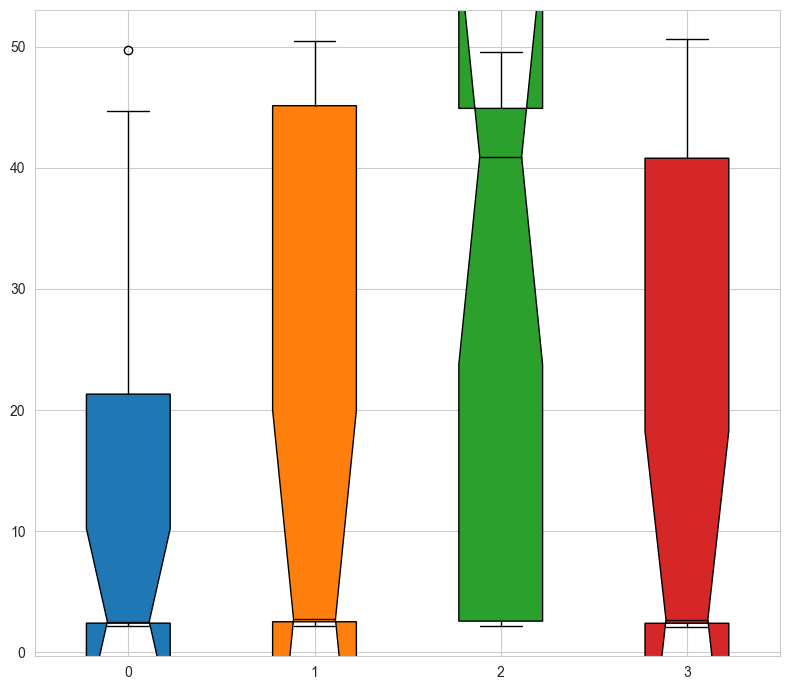

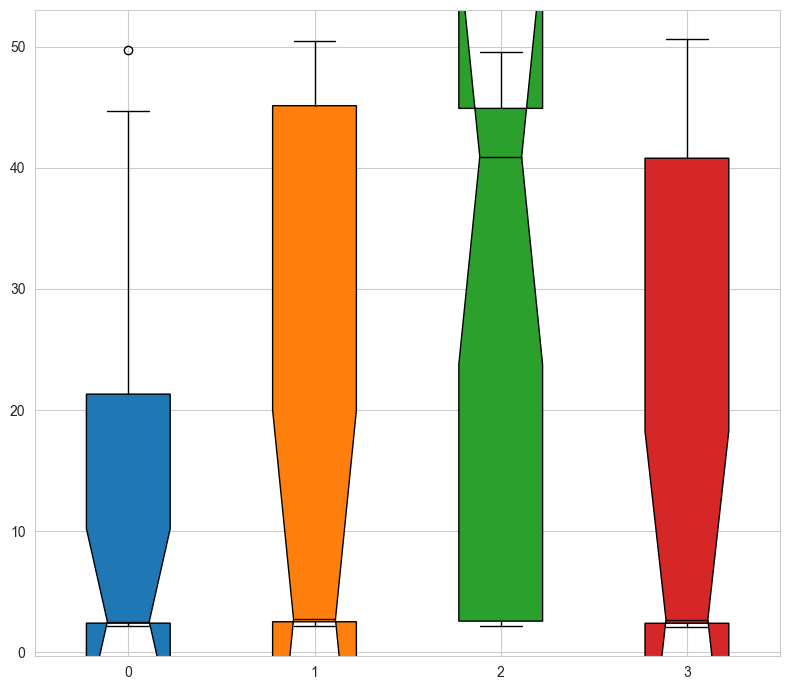

In [234]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (8,7))
    bplot1 = ax.boxplot(np.log(-cvs).T, labels = np.arange(4), patch_artist = True, notch=True)
    for patch, color in zip(bplot1['boxes'], [f'C{i}' for i in np.arange(4)]):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot1[element], color='black')
    plt.tight_layout()
    plt.show()

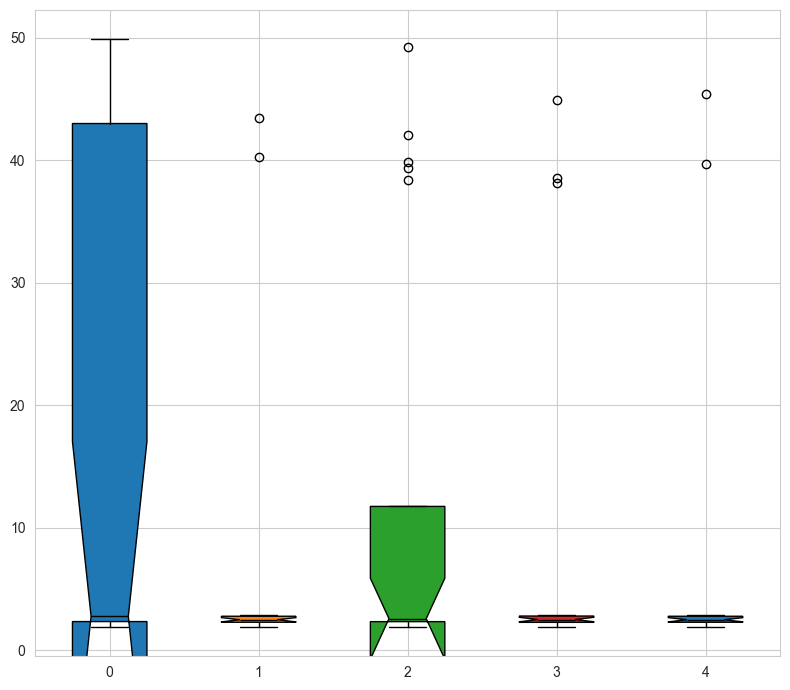

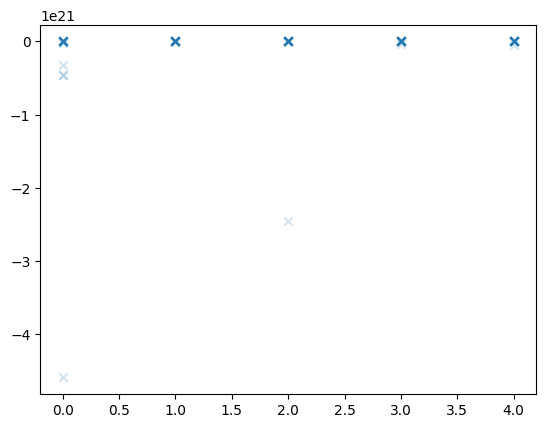

In [245]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

cvs = np.zeros((5, 20))
i_pred = 0
for sel_predictors in [['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2'],
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline'],
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline'],
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2',  'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_max', 'glmt_max tas_baseline'], 
                       ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']
                       ]:
    lm_cv  = LinearRegression()
    X = np.c_[predictor_df[sel_predictors], X_intercept]
    scores = cross_val_score(lm_cv, X, y2, cv=20, scoring='neg_mean_squared_error')
    cvs[i_pred, :] = scores
    i_pred += 1
    
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize = (8,7))
    bplot1 = ax.boxplot(np.log(-cvs).T, labels = np.arange(5), patch_artist = True, notch=True)
    for patch, color in zip(bplot1['boxes'], [f'C{i}' for i in np.arange(4)]):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot1[element], color='black')
    plt.tight_layout()
    plt.show()
    
plt.figure()
plt.scatter(np.array([np.arange(5) for i in range(20)]).T, cvs, marker = 'x', alpha = .2)
plt.show()

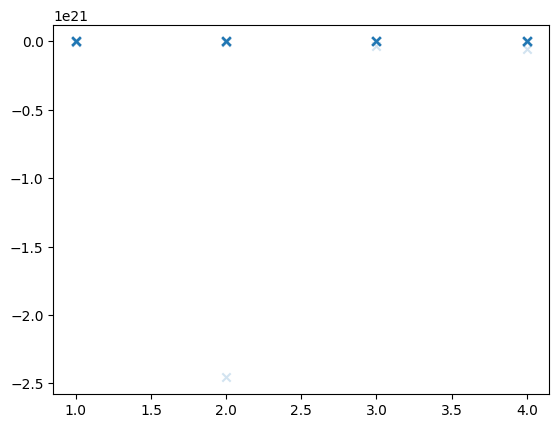

In [247]:
plt.figure()
plt.scatter(np.array([np.arange(5) for i in range(20)]).T[1:,:], cvs[1:,:], marker = 'x', alpha = .2)
plt.show()

In [ ]:
# step 1: temperature threshold - 
# - higher thresholds (?) 
# 2.50: 0.9568841747653648
# 2.29: 0.9568857626247164
# 2.10: 0.9568851130782219
# 2.05: 0.9568846535835521
# 2.00: 0.956884038219601
# 1.97: 0.9568836813337448
# 1.79: 0.9568812963515394
# 1.67: 0.956879016934923 


In [ ]:
# k-fold cross-validation: 
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2'],

In [173]:
X = np.c_[predictor_df[['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline']], X_intercept]
bic, rsquare, _      = fit_model_and_calculate_bic(X, y2)
print(bic)

-214160.64854771772


In [9]:
X = np.c_[predictor_df[['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2']], X_intercept]
bic, rsquare, country_model      = fit_model_and_calculate_bic(X, y2)
print(bic)

-214727.34855583624


In [16]:
country_model.params

x1      -0.521480
x2      10.983670
x3      -7.982429
x4       0.291181
x5       0.175117
          ...    
x162    -1.132328
x163    -4.278884
x164     2.803275
x165     0.090484
x166     0.474288
Length: 166, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


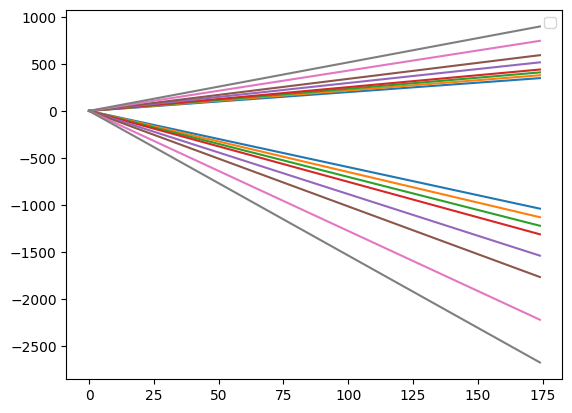

In [10]:
x_EXC = np.arange(0,175,1)

plt.figure()
i_color = 0
for x_T in [12,13,14,15,17.5,20,25, 30]:
    plt.plot(x_EXC, country_model.params[0]*x_EXC*x_T + country_model.params[3]*x_EXC, color = sns.color_palette()[i_color])
    plt.plot(x_EXC, country_model.params[4]*x_EXC*x_T + country_model.params[5]*x_EXC, color = sns.color_palette()[i_color])
    i_color += 1
# plt.plot(x_Ts, country_model.params[6] + x_Ts*country_model.params[7], color = sns.color_palette()[i_color])
plt.legend()
plt.show()

In [ ]:
['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


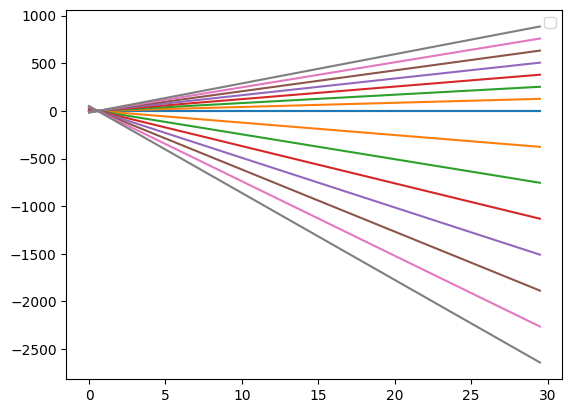

In [11]:
x_EXC = np.arange(0,175,1)
x_Ts  = np.arange(0,30,0.5) 

plt.figure()
i_color = 0
for x_E in [0,25,50,75,100,125,150,175]:
    plt.plot(x_Ts, country_model.params[0]*x_Ts*x_E + country_model.params[3]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[4]*x_Ts*x_E + country_model.params[5]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
# plt.plot(x_Ts, country_model.params[6] + x_Ts*country_model.params[7], color = sns.color_palette()[i_color])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


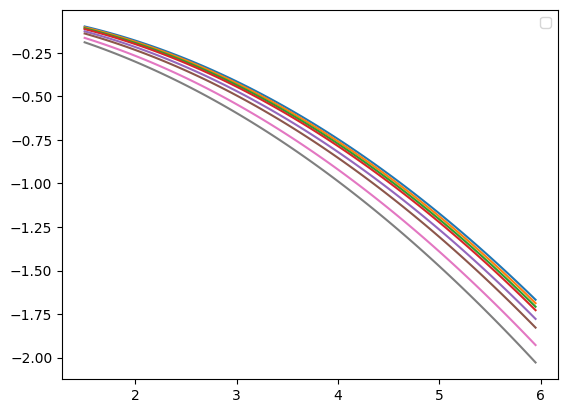

In [295]:
x_EOC = np.arange(1.5,6,0.05)

plt.figure()
i_color = 0
for x_T in [12,13,14,15,17.5,20,25, 30]:
    plt.plot(x_EOC, country_model.params[6]*x_EOC + x_T*country_model.params[7]*x_EOC + country_model.params[8]*x_EOC**2, color = sns.color_palette()[i_color])
    i_color += 1
# plt.plot(x_Ts, country_model.params[6] + x_Ts*country_model.params[7], color = sns.color_palette()[i_color])
plt.legend()
plt.show()

In [169]:
X = np.c_[predictor_df[['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline']], X_intercept]
bic, rsquare, _      = fit_model_and_calculate_bic(X, y2)
print(bic)

-214160.64854771772


In [15]:
best_rsquared = 0
threshold_r   = 0.0004
threshold_in  = 50
threshold_out = 50
included = []
best_bic = np.inf

while True:
    changed = False
    # Forward step
    excluded = list(set(all_predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype = np.float64)
    new_rval = pd.Series(index=excluded, dtype = np.float64)
    for new_column in excluded:
        X = np.c_[predictor_df[included + [new_column]], X_intercept]
        bic, rsquare, _ = fit_model_and_calculate_bic(X, y1)
        new_pval[new_column] = bic
        new_rval[new_column] = rsquare
    best_pval = new_pval.min()
    best_rval = new_rval.values[new_pval.argmin()]
    if (best_pval < best_bic - threshold_in) & (best_rval > best_rsquared + threshold_r):
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        best_bic      = best_pval
        best_rsquared = best_rval
        changed       = True
        
    # Backward step
    if len(included) > 0:
        bic_with_feature = pd.Series(index=included, dtype = np.float64)
        rval_with_feature = pd.Series(index=included, dtype = np.float64)
        for col in included:
            X = np.c_[predictor_df[list(set(included) - set([col]))], X_intercept]
            bic, rsquare, _ = fit_model_and_calculate_bic(X, y1)
            bic_with_feature[col]  = bic
            rval_with_feature[col] = rsquare
        worst_pval = bic_with_feature.min()
        worst_rval = rval_with_feature.values[bic_with_feature.argmin()]
        if (worst_pval < best_bic - threshold_out) & (worst_rval > best_rsquared-threshold_r):
            worst_feature = bic_with_feature.idxmin()
            included.remove(worst_feature)
            best_bic = worst_pval
            best_bic = worst_rval
            changed = True
    
    print(best_bic)
    print(included)        
    
    if not changed:
        break
    
# this step selects ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc', 'glmt_soc tas_baseline']
# as predictors
# all of them have statistic significance 
# glmt_max, glmt_ntwr, glmt_od are never chosen 

263912.3685007874
['glmt_exc tas_baseline']
252790.04344669616
['glmt_exc tas_baseline', 'glmt_exc']
245988.73243117545
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2']
159129.21705226018
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2', 'tas_soc']
145566.7157693095
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc']
144399.01308102242
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'glmt_uxc tas_baseline']
144042.97489729035
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'glmt_uxc tas_baseline', 'glmt_exc^2']
143731.87404498796
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'glmt_uxc tas_baseline', 'glmt_exc^2', 'glmt_uxc']
143731.87404498796
['glmt_exc tas_baseline', 'glmt_exc', 'tas_soc^2', 'tas_soc', 'tas_baseline tas_soc', 'glmt_uxc tas_baseline', 'glmt_exc^2', 'glmt_uxc']


In [210]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

# loading & preparing gdp data
gdp_df   = pd.read_csv(Path.joinpath(cset.path_GDP, 'Full Data BHM Main Result.csv')).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2']]
gdp_df.loc[gdp_df.scen == 'Ref1p5', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df 
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

# loading & preparing tas_baseline data
tas_df = pd.read_csv(Path.joinpath(cset.path_GDP, '2310_countrylevel_total.csv'))
tas_df = tas_df[tas_df.year == 2015].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Ref_1p5'), 'scen_run'] = tas_df['scen_run'].str.replace('Ref_1p5', 'Ref')

In [138]:
for thrsld in ['167', '179', '197', '200', '204', '210', '229', '250']:
    glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'glmt_characteristics_thsld_{thrsld}.csv'), index_col = 0)

    # merge datasets into a single regression dataset
    regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
    regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
    #   - add baseline temperature values
    regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
    regression_df                 = regression_df.sort_values(['iso'])

    # Define predictor variables (excluding 'iso' and the target variable)
    predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'glmt_cum'])
    # Generate second-order terms
    poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    X_poly     = poly.fit_transform(regression_df[predictors])
    X_poly_std = StandardScaler().fit_transform(X_poly)
    # Extract polynomial feature names
    poly_feature_names = poly.get_feature_names_out(predictors)
    predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)

    # interactions with tas_baseline 
    interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

    # Combine original predictors, interaction terms, and polynomial features 
    all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

    # intercept matrix for country fixed effects  
    n_countries = int(len(regression_df)/1000)
    X_intercept = np.zeros((len(regression_df), n_countries))
    for i in range(n_countries):
        X_intercept[i*1000:(i+1)*1000, i] = 1
        
    sel_predictors = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc^2', 'glmt_eoc']

    y              = np.log(regression_df['diff_SSP2'])
    bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
    
    ransac       = RANSACRegressor(residual_threshold = 2, random_state = 0).fit(np.c_[predictor_df[sel_predictors], X_intercept], y)
    inlier_mask  = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    print(r, ransac.score(np.c_[predictor_df[sel_predictors], X_intercept][inlier_mask], y[inlier_mask]))

0.9568513409801622 0.9560220911760057
0.9568555597295227 0.9560207592071235
0.9568600182952082 0.9555625901918343
0.9568606739745579 0.954776345796019
0.9568618598493109 0.9558691884561613
0.9568629522296443 0.9558867442062918
0.9568665736780704 0.9570264340472678
0.9568675965785421 0.9563996764673154


In [212]:
# overfitting to outliers if we keep adding more and more predictors & so on 
for thrsld in [197, 200, 210, 229]:
    print(thrsld)
    glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'glmt_characteristics_thsld_{thrsld}.csv'), index_col = 0)

    # merge datasets into a single regression dataset
    regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
    regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
    #   - add baseline temperature values
    regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
    regression_df                 = regression_df.sort_values(['iso'])

    # Define predictor variables (excluding 'iso' and the target variable)
    predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'glmt_cum'])
    # Generate second-order terms
    poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    X_poly     = poly.fit_transform(regression_df[predictors])
    X_poly_std = StandardScaler().fit_transform(X_poly)
    # Extract polynomial feature names
    poly_feature_names = poly.get_feature_names_out(predictors)
    predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)

    # interactions with tas_baseline 
    interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

    # Combine original predictors, interaction terms, and polynomial features 
    all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

    # intercept matrix for country fixed effects  
    n_countries = int(len(regression_df)/1000)
    X_intercept = np.zeros((len(regression_df), n_countries))
    for i in range(n_countries):
        X_intercept[i*1000:(i+1)*1000, i] = 1


    # we don't want to overfit the model to outliers 
    for sel_predictors in [['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2'],
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline'], 
                        ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_max', 'glmt_max tas_baseline', 'glmt_exc^2', 'glmt_uxc^2']
                        ]:
        y              = np.log(regression_df['diff_SSP2'])
        ransac       = RANSACRegressor(residual_threshold = 3, random_state = 1).fit(np.c_[predictor_df[sel_predictors], X_intercept], y)
        inlier_mask  = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
    
        print(r, ransac.score(np.c_[predictor_df[sel_predictors], X_intercept][inlier_mask], y[inlier_mask]))

197
0.9566799782376227 0.9577532508593247
0.9566961964177327 0.9571581441473427
0.9568739636968128 0.9574531889652222
0.9567000512830861 0.957065258091255
0.9568516219237311 0.9597217073348558
200
0.9566864390918157 0.9547038308642456
0.9567017250609047 0.9571871199499316
0.9568741829182048 0.9576886050002886
0.9567051487894018 0.9570914921780519
0.9568516029131613 0.9597088207108344
210
0.9567084141949135 0.9552563358468318
0.9567208258558784 0.957101123698808
0.9568750459640107 0.958132378981708
0.956723025686021 0.9571429234448485
0.9568515800455918 0.959689962652738
229
0.9567508172903626 0.9567881839374606
0.956758738454317 0.9569312466013913
0.9568764175680304 0.9572312922573903
0.956759759739417 0.9571413496752845
0.956851755673969 0.9594906248713791


In [114]:
ransac       = RANSACRegressor(residual_threshold = 3, random_state = 0).fit(np.c_[predictor_df[sel_predictors], X_intercept], y)
inlier_mask  = ransac.inlier_mask_
print(np.sum(inlier_mask))

136293


In [115]:
# tchad, eritrea, senegal are outliers
#
np.unique(regression_df.iloc[~inlier_mask, :].iso, return_counts = True)

(array(['ALB', 'ARE', 'AUT', 'BEL', 'BFA', 'CHE', 'CHN', 'CUB', 'CZE',
        'DEU', 'DNK', 'FRA', 'GBR', 'GIN', 'GNB', 'GRC', 'GUY', 'HTI',
        'IRN', 'KWT', 'LBR', 'MDA', 'MYS', 'NGA', 'PRT', 'SEN', 'TCD',
        'TKM', 'TUR', 'USA'], dtype=object),
 array([1000, 1000,   10, 1000, 1000,    1, 1000,   54,  351,  660,  222,
        1000, 1000,   74,  997,  177,  966,  746,   14,   93,  563, 1000,
         998,  995, 1000, 1000,  999,  787, 1000, 1000]))

In [94]:
len(inlier_mask)

157000

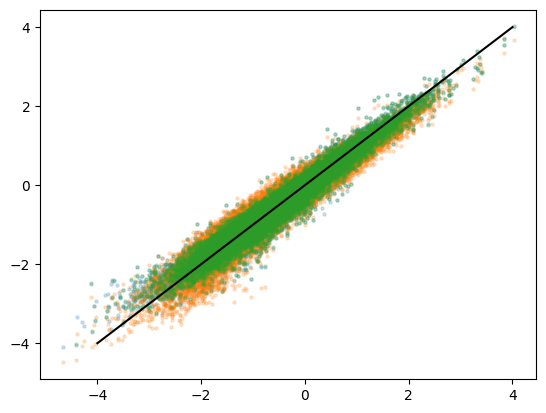

In [98]:
plt.figure()
plt.scatter(y, model.predict(np.c_[predictor_df[sel_predictors], X_intercept]), s = 5, alpha = .2)
plt.scatter(y, model2.predict(np.c_[predictor_df[sel_predictors], X_intercept]), s = 5, alpha = .2)
plt.scatter(y[inlier_mask], ransac.predict(np.c_[predictor_df[sel_predictors], X_intercept])[inlier_mask], s = 5, alpha = .2)
plt.plot([-4,4], [-4,4], color = 'black')
plt.show()

In [ ]:
# correcting for outliers (?) 

In [9]:
# sel_predictors = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_exc^2', 'glmt_eoc^2', 'glmt_eoc', 'glmt_soc', 'glmt_soc tas_baseline']
# sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc']

sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc^2',  'glmt_eoc tas_baseline']

y              = np.log(regression_df['diff_SSP2'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)
print(r)

KeyError: "['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'glmt_eoc', 'glmt_eoc^2', 'glmt_eoc tas_baseline'] not in index"

In [17]:
sel_predictors = ['glmt_exc tas_baseline', 'tas_soc^2', 'tas_soc', 'glmt_exc', 'glmt_uxc tas_baseline', 'glmt_uxc', 'glmt_eoc', 'glmt_eoc tas_baseline', 'glmt_eoc^2', 'glmt_exc^2', 'glmt_uxc^2']

In [151]:
sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline']

In [152]:
result_df                  = pd.DataFrame(X_poly, columns = poly_feature_names)[sel_predictors]
result_df['log_diff_SSP2'] = np.log(regression_df['diff_SSP2'].values)
result_df['iso']           = regression_df['iso'].values
result_df['scen_run']      = regression_df['scen_run'].values
result_df['tas_baseline']  = regression_df['tas_baseline'].values

In [153]:
cset.path_CHAR_results.mkdir(parents=True, exist_ok=True)
result_df.to_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'))

In [ ]:
# step 1: temperature threshold - 
# - higher thresholds (?) 
# 2.50: 0.9568841747653648
# 2.29: 0.9568857626247164
# 2.10: 0.9568851130782219
# 2.05: 0.9568846535835521
# 2.00: 0.956884038219601
# 1.97: 0.9568836813337448
# 1.79: 0.9568812963515394
# 1.67: 0.956879016934923 


In [167]:
glmt_char_df = pd.read_csv(Path.joinpath(cset.path_MESMER_char, f'glmt_characteristics_thsld_200.csv'), index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df                 = regression_df.sort_values(['iso'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = regression_df.columns.difference(['iso', 'diff_SSP2', 'scen_run', 'glmt_cum'])
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names = poly.get_feature_names_out(predictors)
predictor_df       = pd.DataFrame(X_poly_std, columns = poly_feature_names)

# interactions with tas_baseline 
interaction_terms  = [f for f in poly_feature_names if ('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')]

# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list(predictors + '^2')

# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1
    
sel_predictors = ['glmt_exc', 'glmt_exc tas_baseline', 'glmt_uxc', 'glmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'glmt_eoc', 'glmt_eoc tas_baseline']

y              = np.log(regression_df['diff_SSP2'])
bic, r, model  = fit_model_and_calculate_bic(np.c_[predictor_df[sel_predictors], X_intercept], y)

ransac       = RANSACRegressor(residual_threshold = 3, random_state = 0).fit(np.c_[predictor_df[sel_predictors], X_intercept], y)
inlier_mask  = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(r, ransac.score(np.c_[predictor_df[sel_predictors], X_intercept][inlier_mask], y[inlier_mask]))

result_df                  = pd.DataFrame(X_poly, columns = poly_feature_names)[sel_predictors]
result_df['log_diff_SSP2'] = np.log(regression_df['diff_SSP2'].values)
result_df['iso']           = regression_df['iso'].values
result_df['scen_run']      = regression_df['scen_run'].values
result_df['tas_baseline']  = regression_df['tas_baseline'].values

cset.path_CHAR_results.mkdir(parents=True, exist_ok=True)
result_df.to_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'))

0.9567017250609047 0.9540261592596696


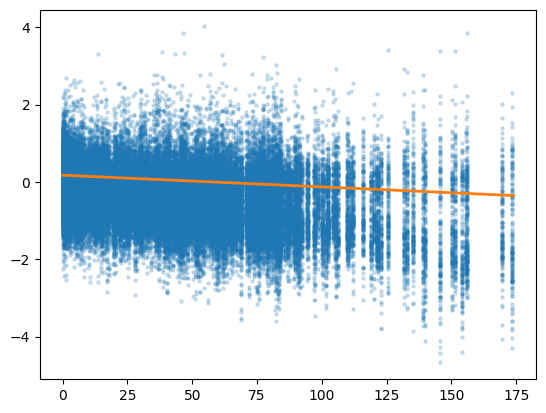

In [183]:
x = np.arange(0,175,1)
coeffs = ransac.estimator_.coef_
plt.figure()
plt.scatter(result_df['glmt_exc'], result_df['log_diff_SSP2'], s = 5, alpha = .2)
plt.plot(x, coeffs[3] + coeffs[6]*x, color = 'C1', linewidth = 2)
plt.show()